# CASADI Opti stack rewrite 
Fix all the god damn bugs

Assume we have a discrete-time model:
$$x_{t+1} = f(x_t, u_t)$$
Denote a whole MPC trajectory, with states $x_0,x_1,\dots,x_N$ and controls $u_1,\dots,u_N$ as $\mathbf{x}$ and $\mathbf{u}$.

We have positional constraints:
$$Ax \leq b$$

We have some interval constraints:
$$x_{min} \leq x_t \leq x_{max},\ i=0,\dots,N$$
$$u_{min} \leq u_t \leq u_{max},\ i=1,\dots,N$$

We have multiobjective weighted cost function which is probably quadratic.
    $$J(\mathbf{x}, \mathbf{u})$$

The nonlinear model is:
\begin{gather*}
\begin{bmatrix}
\dot x\\ \dot y\\ \dot v\\ \dot\psi
%\\ \dot\beta
\end{bmatrix} =
\begin{bmatrix}
v\cos(\psi + \beta)
\\
v\sin(\psi + \beta)
\\
a
\\
\frac{v}{l_r}\sin(\beta)
%\\
%\frac{v}{l_f + l_r}\tan(\delta_f) - \frac{v}{l_r}\sin(\beta)
\end{bmatrix}, \quad \beta = \tan^{-1}\Big(\frac{l_r}{l_r + l_f}\tan(\delta_f)\Big)
\end{gather*}


Assume zero-order-hold on the controls. and $t$, $t+1$ are separated by time $\Delta t$. A very easy discretization is $x_{t+1} = x_t + \dot x_t \Delta t$

In [23]:
# Library dependencies
import casadi            as ca
import numpy             as np
import matplotlib.pyplot as plt
import matplotlib        as mpl

# Local dependencies
from roadrunner_2        import Roadrunner, Segment, OutOfRoadPointsException
from KinematicModel import KinematicBicycle

model = KinematicBicycle("base_vehicle_model.json")

N = 30
step = 0.075

# system size
n = 4
m = 2

# the 2 vehicle parameters are model.lr and model.lf

In [24]:
from road                import iso_double_lane_change as test_road
test_road_width = 5.0*np.ones(np.size(test_road)//2)
DESIRED_SPEED = 5.0 # 10 m/s approx 22 mph
n_test_road_pts,_ = np.shape(test_road)

roadrunner = Roadrunner(road_center = test_road, # Road centerline points
                        road_width  = test_road_width,
                        P           = np.size(test_road_width)-1,
                       start_pct = 0.0, end_pct = 1.0) # Number of points to try curve-fitting at a time
roadrunner.reset()
# start a bit ahead of the first point to have space for looking back on the road
roadrunner.advance(step*20*DESIRED_SPEED)

def desired_speed(k:int):
    return DESIRED_SPEED

xy = np.reshape(roadrunner.evaluate(),(2,))
ic = [xy[0], xy[1], DESIRED_SPEED, float(roadrunner.get_angle())]

 [ 0.]] is [15.28968758] away at s = 0.012034637828942558, B(s) = [[9.96891533e+00]
 [1.83244721e-17]]
 [ 0.]] is [15.72259511] away at s = 0.02457308184468577, B(s) = [[2.00139878e+01]
 [1.77563205e-12]]
 [ 0.]] is [14.52614119] away at s = 0.03849461062298814, B(s) = [[3.00576112e+01]
 [1.75676151e-09]]
 [ 0.]] is [13.55609329] away at s = 0.05475452436113872, B(s) = [[3.99630405e+01]
 [2.95790905e-07]]
 [ 0.]] is [12.98917298] away at s = 0.06433647905010509, B(s) = [[4.50321205e+01]
 [2.75208340e-06]]
 [ 0.]] is [13.27543701] away at s = 0.07448072291292603, B(s) = [[4.99651086e+01]
 [1.92866944e-05]]
 [ 0.]] is [13.31075205] away at s = 0.08558755713960864, B(s) = [[5.50201211e+01]
 [1.13143616e-04]]
 [ 0.]] is [12.97499973] away at s = 0.09719331377081405, B(s) = [[6.00508873e+01]
 [5.28653028e-04]]
 [ 0.]] is [12.41360199] away at s = 0.10905299814632262, B(s) = [[6.50040919e+01]
 [1.98814312e-03]]
 [ 0.]] is [11.93208638] away at s = 0.12143317349514081, B(s) = [[6.99918889e+01

 [  0.   ]] is [4.49360117] away at s = 0.6871679998310471, B(s) = [[194.38637201]
 [  0.23374231]]
 [  0.   ]] is [4.06050471] away at s = 0.7028973627995656, B(s) = [[1.97255196e+02]
 [1.27716593e-01]]
 [  0.   ]] is [3.7041067] away at s = 0.7178239238235493, B(s) = [[1.99822588e+02]
 [6.64881067e-02]]
 [  0.   ]] is [3.13934664] away at s = 0.7357110965225526, B(s) = [[2.02627958e+02]
 [2.71399276e-02]]
 [  0.   ]] is [3.12527829] away at s = 0.8569614222900236, B(s) = [[2.15190236e+02]
 [3.63614839e-07]]
 [  0.]] is [2.99884034] away at s = 0.8553270185193984, B(s) = [[2.14990457e+02]
 [4.63947617e-07]]
 [  0.]] is [4.53690574] away at s = 0.8754363985533744, B(s) = [[2.18008284e+02]
 [1.72705841e-08]]
 [  0.]] is [6.46281843] away at s = 0.8928026868642858, B(s) = [[2.21972664e+02]
 [5.43030979e-10]]
 [  0.]] is [7.86499806] away at s = 0.9056200076646143, B(s) = [[2.26021784e+02]
 [2.59799135e-11]]
 [  0.]] is [9.17669009] away at s = 0.9156920649166825, B(s) = [[2.30014099e+02]

In [25]:
from scipy.integrate import ode
def f(t, z, u):
    x_i, y_i, v_i, psi_i = z[0], z[1], z[2], z[3]
    a_i, delta_f_i = u[0], u[1]
    beta = np.arctan(model.lr/(model.lr+model.lf)*np.tan(delta_f_i))
    return [
        v_i*np.cos(psi_i + beta),
        v_i*np.sin(psi_i + beta),
        a_i,
        v_i/model.lr*np.sin(beta),
    ]
def move_forward(z0, u0, step):

    r = ode(f)

    r.set_initial_value(z0, 0.0).set_f_params(u0)
    return r.integrate(r.t+step)

In [43]:
def run_mpc_iteration(z0, u0, coeffs, z_previous=None, u_previous=None):
    # z0: initial state
    # coeffs: cost weights
    opti = ca.Opti()
    #z0_body = roadrunner.to_body_frame(np.reshape(z0[0:2],(1,2)), angle=z0[-1], offset=z0[0:2])
    z_prev = z0
    u_prev = u0#np.zeros(m)
    
    d = model._d # number of collocation points
    z = opti.variable(n*N*(d+1))
    u = opti.variable(m*N)
    z_lb, z_ub = model.z_bound()
    opti.subject_to(opti.bounded(np.tile(z_lb,N*(d+1)), z, np.tile(z_ub,N*(d+1))))
    u_lb, u_ub = model.u_bound()
    opti.subject_to(opti.bounded(np.tile(u_lb,N), u, np.tile(u_ub,N)))
    
    
    z_guess = np.zeros(n*N*(d+1))
    u_guess = np.zeros(m*N)

    jerk_cost = 0.0
    steering_change_cost = 0.0
    attractive_cost = 0.0
    J = 0.0 # quadrature cost
    z_i = opti.variable(n)
    opti.subject_to(z_i == z0)
    
    ctr = 0
    for i in range(N):
        
        u_i = u[i*m:(i+1)*m]
        
        jerk_cost += (u_i[0]-u_prev[0])**2
        steering_change_cost += (u_i[1]-u_prev[1])**2
        
        v_des = desired_speed(i)
        xy,psi,_ = roadrunner.evaluate((i+1)*step*v_des, full_data=True)
        xy_prev,psi_prev,_ = roadrunner.evaluate((i)*step*v_des, full_data=True)
        
        u_guess[i*m:(i+1)*m] = [(v_des-desired_speed(i))/step, (psi - psi_prev)/step]
        
        
        # State at collocation points
        z_c = []
        for j in range(d):
            z_j = z[ctr:ctr+n]
            z_c.append(z_j)
            x_i, y_i, v_i, psi_i = z_j[0], z_j[1], z_j[2], z_j[3]
            attractive_cost += \
                (v_i-desired_speed(i))**2 + (psi_i-psi)**2 +\
                (x_i-xy[0,0])**2 + (y_i-xy[0,1])**2

            # Add the polygon bounds at step k                
            bounds, p = roadrunner.bound_x(step,i,desired_speed)

            for (ub, a, b, c, lb) in bounds:
                if a != 0:
                    opti.subject_to(opti.bounded(lb,x_i*a + y_i*b + c,ub))
                else:
                    opti.subject_to(opti.bounded(lb,y_i*b + c,ub))

            z_guess[ctr:ctr+n] = np.array([xy[0,0], xy[0,1],v_des, psi])
            ctr += n
            
        # Loop over collocation points
        z_i_end = model._D[0]*z_i
        for j in range(1,model._d+1):
            # Expression for the state derivative at the collocation point
            xp = model._C[0,j]*z_i
            for r in range(model._d): xp = xp + model._C[r+1,j]*z_c[r]

            # Append collocation equations
            #fj, qj = model.f(z_c[j-1],u_i)
            fj = model.f(z_c[j-1],u_i)
            opti.subject_to(step*fj - xp == 0.0)
            
            # Add contribution to the end state
            z_i_end = z_i_end + model._D[j]*z_c[j-1];

        # Connect collocation to next state        
        z_i = z[ctr:ctr+n]
        opti.subject_to(z_i == z_i_end)
        
        # guess of state value
        xy,psi,_ = roadrunner.evaluate((i+1)*step*v_des, full_data=True)
        z_guess[ctr:ctr+n] = np.array([xy[0,0], xy[0,1],v_des, psi])
        ctr += n
        
        #z_prev = z_i
        u_prev = u_i
        
    if z_previous is None:
        opti.set_initial(z, z_guess)
    else:
        opti.set_initial(z, z_previous)
    if u_previous is None:
        opti.set_initial(u, u_guess)
    else:
        opti.set_initial(u, u_previous)
    opti.minimize(jerk_cost*coeffs[0] + steering_change_cost*coeffs[1] + attractive_cost*coeffs[2])
    opti.solver('ipopt')
    try:
        sol = opti.solve()
    except Exception as e:
        opti.debug.show_infeasibilities()
        raise e
        
    z = sol.value(z)
    u = sol.value(u)
    z = np.reshape(z,(np.size(z)//n,n))
    u = np.reshape(u,(np.size(u)//m,m))
    
    return z,u

In [44]:
def run_mpc_test(costs):
    roadrunner.reset()
    # start a bit ahead of the first point to have space for looking back on the road
    roadrunner.advance(step*60*DESIRED_SPEED)

    xy = np.reshape(roadrunner.evaluate(),(2,))
    z0 = [xy[0], xy[1], DESIRED_SPEED, float(roadrunner.get_angle())]
    u0 = np.zeros(2)
    runs = 200
    z_history = np.zeros((runs,n))
    u_history = np.zeros((runs,m))
    r=0
    z,u = None, None
    try:
        for i in range(runs):
            if u is not None:
                zg = np.concatenate([z[1:,:],z[-2:-1,:]])
                ug = np.concatenate([u[1:,:],np.zeros((1,2))])
                z,u = run_mpc_iteration(z0, u0, costs, np.reshape(zg,np.size(zg)), np.reshape(ug,np.size(ug)))
            else:
                z,u = run_mpc_iteration(z0,u0,costs)
    
            # move roadrunner by scipy ODE integration
            z0 = move_forward(z0, u[0,:], step)
            dist = roadrunner.advance_xy(z0[0:2])
            
            # save data
            z_history[i,:] = z0 # The simulated "True" state by ODE integration
            u_history[i,:] = u[0,:]
            u0 = u[0,:]
            r = i
    except OutOfRoadPointsException:
        z_history = z_history[0:r,:]
        u_history = u_history[0:r,:]
    return z_history, u_history


# Test runs: baseline CG

In [45]:
z_history_01,u_history_01 = run_mpc_test(np.array([10.0, 1.0, 0.1]))

/home/esoroka/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/home/esoroka/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:86: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2854
Number of nonzeros in inequality constraint Jacobian.:     1260
Number of nonzeros in Lagrangian Hessian.............:      748

Total number of variables............................:      544
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      484
Total number of inequality constraints...............:      900
        inequality constraints with only lower bounds:      180
   inequality constraints with lower and upper bounds:      300
        inequality constraints with only upper bounds:      180

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2854
Number of nonzeros in inequality constraint Jacobian.:     1260
Number of nonzeros in Lagrangian Hessian.............:      748

Total number of variables............................:      544
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      484
Total number of inequality constraints...............:      900
        inequality constraints with only lower bounds:      180
   inequality constraints with lower and upper bounds:      300
        inequality constraints with only upper bounds:      180

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

  15  3.2369697e+02 1.13e+02 7.31e+09  -1.0 2.07e+01   7.1 1.21e-01 1.50e-04h  1
  16  3.3880501e+02 1.10e+02 4.83e+10  -1.0 2.08e+01   7.5 1.00e+00 3.02e-02h  1
  17  3.9006699e+02 9.84e+01 4.24e+10  -1.0 2.02e+01   7.0 1.30e-01 1.04e-01h  1
  18  3.9054748e+02 9.82e+01 3.53e+10  -1.0 1.81e+01   7.4 1.00e+00 1.13e-03h  1
  19  3.9059820e+02 9.82e+01 4.96e+10  -1.0 1.82e+01   7.9 2.16e-01 1.74e-04h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20  4.2605835e+02 8.60e+01 2.73e+10  -1.0 1.83e+01   7.4 1.00e+00 1.24e-01h  1
  21  4.2707178e+02 8.56e+01 3.94e+10  -1.0 1.60e+01   7.8 2.60e-01 4.87e-03h  1
  22  4.3553346e+02 8.18e+01 2.89e+10  -1.0 1.60e+01   7.3 4.78e-01 4.45e-02h  1
  23  4.3562212e+02 8.18e+01 4.45e+10  -1.0 1.53e+01   7.8 4.73e-01 4.90e-04h  1
  24  4.4750219e+02 8.06e+01 3.89e+10  -1.0 1.46e+01   7.3 4.09e-01 1.42e-02h  1
  25  5.2465701e+02 7.37e+01 8.85e+10  -1.0 1.44e+01   7.7 1.00e+00 8.57e-02h  1
  26  5.2534567e+02 7.36e+01

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2854
Number of nonzeros in inequality constraint Jacobian.:     1260
Number of nonzeros in Lagrangian Hessian.............:      748

Total number of variables............................:      544
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      484
Total number of inequality constraints...............:      900
        inequality constraints with only lower bounds:      180
   inequality constraints with lower and upper bounds:      300
        inequality constraints with only upper bounds:      180

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

  93  3.0631968e+02 1.77e-05 5.14e+01  -1.7 6.70e-02   2.9 1.00e+00 1.00e+00f  1
  94  2.7527695e+02 6.56e-05 4.54e+01  -1.7 1.78e-01   2.4 9.76e-01 1.00e+00f  1
  95  2.1656761e+02 4.99e-04 3.46e+01  -1.7 4.06e-01   1.9 1.00e+00 1.00e+00f  1
  96  1.7361850e+02 2.88e-04 2.45e+01  -1.7 6.67e-01   1.5 1.00e+00 6.41e-01f  1
  97  1.5218046e+02 7.13e-04 1.97e+01  -1.7 9.05e-01   1.0 2.26e-01 3.04e-01f  1
  98  9.8210379e+01 2.44e-02 2.53e+01  -1.7 1.05e+00   0.5 1.00e+00 1.00e+00f  1
  99  8.4308372e+01 1.66e-03 2.49e+01  -1.7 6.16e-01   0.0 5.72e-01 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  7.7495623e+01 3.00e-03 4.38e+01  -1.7 6.32e-01  -0.5 2.57e-02 1.00e+00f  1
 101  7.5843168e+01 8.39e-03 1.33e+01  -1.7 3.14e-01  -0.0 7.36e-01 1.00e+00f  1
 102  7.5795561e+01 8.21e-03 6.07e+00  -1.7 2.46e-01   0.4 7.40e-01 1.00e+00f  1
 103  7.4083257e+01 3.96e-03 1.76e+00  -1.7 3.07e-01  -0.1 7.32e-01 1.00e+00f  1
 104  7.1156636e+01 6.73e-02

  41  5.3482775e+01 1.61e-03 7.78e-01  -1.7 1.19e-01   0.1 1.00e+00 1.00e+00f  1
  42  5.3337492e+01 7.43e-03 2.95e-01  -1.7 2.40e-01  -0.4 1.00e+00 1.00e+00f  1
  43  5.3202324e+01 5.65e-04 1.70e-01  -1.7 1.90e-01  -0.8 1.00e+00 1.00e+00h  1
  44  5.3043369e+01 9.72e-04 1.47e-01  -2.5 3.34e-01  -1.3 9.03e-01 1.00e+00f  1
  45  5.2796430e+01 1.77e-03 9.77e-02  -2.5 5.53e-01  -1.8 1.00e+00 1.00e+00f  1
  46  5.2290184e+01 1.87e-02 1.30e-01  -2.5 1.78e+00  -2.3 5.54e-01 1.00e+00f  1
  47  5.1387683e+01 2.11e-01 1.58e-01  -2.5 3.89e+00  -2.7 7.53e-01 9.13e-01f  1
  48  4.7972724e+01 2.10e-01 1.58e-01  -2.5 3.38e+03    -  2.74e-03 2.69e-03f  1
  49  4.5020382e+01 7.25e-02 1.41e+00  -2.5 9.25e+00  -3.2 1.04e-02 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  50  4.5064563e+01 6.70e-02 1.31e+00  -2.5 3.80e+00  -1.9 3.32e-01 7.65e-02h  3
  51  4.5295267e+01 5.24e-02 1.02e+00  -2.5 3.85e+00  -2.4 3.57e-01 2.19e-01h  2
  52  4.6173321e+01 8.67e-02

  29  9.3078751e+02 2.63e+01 6.30e+11  -1.0 5.33e+00   9.4 1.00e+00 2.61e-05h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  30  9.3104863e+02 2.62e+01 4.89e+12  -1.0 5.36e+00   9.8 1.00e+00 3.81e-03h  1
  31  9.4956021e+02 1.76e+01 2.48e+11  -1.0 5.34e+00   9.4 1.00e+00 3.30e-01h  1
  32  9.4973100e+02 1.75e+01 2.06e+12  -1.0 3.59e+00   9.8 1.00e+00 5.93e-03h  1
  33  9.4973249e+02 1.75e+01 6.71e+11  -1.0 3.57e+00   9.3 1.00e+00 5.86e-05h  1
  34  9.5001655e+02 1.74e+01 2.01e+12  -1.0 3.50e+00   9.7 1.00e+00 2.21e-03h  1
  35  1.0735545e+03 1.61e+00 6.34e+10  -1.0 3.49e+00   9.3 1.00e+00 9.07e-01h  1
  36  1.0751294e+03 1.41e+00 9.13e+11  -1.0 3.25e-01   9.7 1.00e+00 1.25e-01h  1
  37  1.0751461e+03 1.41e+00 1.17e+12  -1.0 2.85e-01   9.2 1.00e+00 1.53e-03h  1
  38  1.0751462e+03 1.41e+00 9.79e+11  -1.0 2.84e-01   9.6 1.00e+00 1.54e-05h  1
  39  1.0752844e+03 1.23e+00 8.69e+11  -1.0 2.89e-01   9.2 2.34e-01 1.25e-01h  1
iter    objective    inf_pr 

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2854
Number of nonzeros in inequality constraint Jacobian.:     1260
Number of nonzeros in Lagrangian Hessian.............:      748

Total number of variables............................:      544
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      484
Total number of inequality constraints...............:      900
        inequality constraints with only lower bounds:      180
   inequality constraints with lower and upper bounds:      300
        inequality constraints with only upper bounds:      180

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2854
Number of nonzeros in inequality constraint Jacobian.:     1260
Number of nonzeros in Lagrangian Hessian.............:      748

Total number of variables............................:      544
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      484
Total number of inequality constraints...............:      900
        inequality constraints with only lower bounds:      180
   inequality constraints with lower and upper bounds:      300
        inequality constraints with only upper bounds:      180

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

  17  8.3437904e+02 9.67e+01 3.22e+10  -1.0 2.13e+01   7.0 4.96e-01 4.58e-02h  1
  18  8.3531417e+02 9.66e+01 4.36e+10  -1.0 2.03e+01   7.4 2.62e-01 4.22e-04h  1
  19  8.7014848e+02 9.39e+01 2.44e+10  -1.0 2.09e+01   7.0 1.00e+00 2.81e-02h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20  1.0720012e+03 7.98e+01 6.20e+10  -1.0 2.04e+01   7.4 1.00e+00 1.51e-01h  1
  21  1.0743838e+03 7.96e+01 1.22e+11  -1.0 1.73e+01   7.8 6.23e-01 1.96e-03h  1
  22  1.0744120e+03 7.96e+01 5.05e+11  -1.0 1.78e+01   8.2 1.00e+00 1.21e-04h  1
  23  1.0727660e+03 5.59e+01 4.29e+11  -1.0 1.80e+01   7.8 7.98e-02 2.98e-01h  1
  24  1.0727652e+03 5.59e+01 2.69e+11  -1.0 1.26e+01   8.2 1.00e+00 1.05e-03h  1
  25  1.0727502e+03 5.43e+01 8.02e+11  -1.0 1.26e+01   8.6 1.00e+00 2.69e-02h  1
  26  1.0727484e+03 5.43e+01 2.02e+11  -1.0 1.23e+01   8.1 1.00e+00 2.89e-04h  1
  27  1.0727498e+03 5.43e+01 2.08e+11  -1.0 1.22e+01   8.6 7.97e-03 2.67e-05h  1
  28  1.0733553e+03 5.34e+01

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2854
Number of nonzeros in inequality constraint Jacobian.:     1260
Number of nonzeros in Lagrangian Hessian.............:      748

Total number of variables............................:      544
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      484
Total number of inequality constraints...............:      900
        inequality constraints with only lower bounds:      180
   inequality constraints with lower and upper bounds:      300
        inequality constraints with only upper bounds:      180

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

 [4.18665920e-04]] is [3.82392025] away at s = 0.08755932440167966, B(s) = [[5.58900843e+01]
 [1.49974974e-04]]
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2854
Number of nonzeros in inequality constraint Jacobian.:     1260
Number of nonzeros in Lagrangian Hessian.............:      748

Total number of variables............................:      544
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      484
Total number of inequality constraints...............:      900
        inequality constraints with only lower bounds:      180
   inequality constraints with lower and upper bounds:      300
        inequality constraints with only

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2854
Number of nonzeros in inequality constraint Jacobian.:     1260
Number of nonzeros in Lagrangian Hessian.............:      748

Total number of variables............................:      544
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      484
Total number of inequality constraints...............:      900
        inequality constraints with only lower bounds:      180
   inequality constraints with lower and upper bounds:      300
        inequality constraints with only upper bounds:      180

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

  99  6.9823244e+01 3.47e-03 1.12e+00  -3.8 2.05e-01   0.1 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  6.7367945e+01 8.87e-04 4.07e+00  -3.8 4.60e-01  -0.4 3.43e-01 1.00e+00f  1
 101  6.3802793e+01 1.79e-03 8.94e+00  -3.8 1.03e+00  -0.8 2.34e-01 1.00e+00f  1
 102  6.2485536e+01 5.28e-04 1.62e-01  -3.8 4.11e-01  -0.4 1.00e+00 1.00e+00f  1
 103  6.0167980e+01 6.16e-03 1.52e+00  -3.8 1.08e+00  -0.9 5.02e-01 1.00e+00f  1
 104  5.9346739e+01 8.54e-04 2.98e-01  -3.8 3.28e-01  -0.5 9.98e-01 1.00e+00f  1
 105  5.7768196e+01 1.78e-03 2.20e+00  -3.8 8.12e-01  -0.9 1.30e-01 1.00e+00f  1
 106  5.3816779e+01 5.62e-03 8.22e-01  -3.8 2.12e+00  -1.4 4.35e-01 1.00e+00f  1
 107  5.2432149e+01 5.84e-03 1.16e-01  -3.8 8.55e-01  -1.0 8.15e-01 1.00e+00f  1
 108  4.9221166e+01 8.85e-03 4.85e-01  -3.8 2.22e+00  -1.5 1.00e+00 1.00e+00f  1
 109  4.3509929e+01 6.08e-02 1.01e+00  -3.8 5.29e+00  -1.9 7.11e-01 1.00e+00f  1
iter    objective    inf_pr 

  36  7.4371171e+02 1.66e-09 1.98e+02  -1.0 1.68e-04   6.1 1.00e+00 1.00e+00f  1
  37  7.4368941e+02 1.16e-09 5.74e+01  -1.0 1.46e-04   5.6 1.00e+00 1.00e+00f  1
  38  7.4360896e+02 9.54e-09 5.56e+01  -1.0 4.24e-04   5.1 1.00e+00 1.00e+00f  1
  39  7.4347297e+02 1.69e-08 2.58e+01  -1.0 5.91e-04   4.6 9.97e-01 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  40  7.4276123e+02 1.06e-07 4.04e+01  -1.0 2.77e-03   4.2 1.00e+00 1.00e+00f  1
  41  7.4168167e+02 2.69e-07 1.64e+03  -1.0 3.79e-03   3.7 5.70e-01 1.00e+00f  1
  42  7.3673149e+02 1.72e-06 2.03e+02  -1.0 1.93e-02   3.2 6.49e-01 1.00e+00f  1
  43  7.2297810e+02 8.01e-06 2.62e+02  -1.0 5.20e-02   2.7 4.08e-01 1.00e+00f  1
  44  6.8474159e+02 9.68e-05 1.81e+02  -1.0 1.54e-01   2.3 4.65e-01 1.00e+00f  1
  45  5.9286166e+02 9.31e-04 3.06e+02  -1.0 3.96e-01   1.8 5.11e-01 1.00e+00f  1
  46  4.3346159e+02 1.73e-03 7.02e+02  -1.0 8.23e-01   1.3 4.95e-01 1.00e+00f  1
  47  3.9133632e+02 9.08e-06

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20  8.9163436e+02 6.53e+01 7.03e+09  -1.0 1.68e+01   6.5 6.61e-01 3.41e-04h  1
  21  8.9139316e+02 6.53e+01 2.71e+09  -1.0 1.68e+01   6.0 1.00e+00 5.11e-04h  1
  22  8.0689221e+02 5.05e+01 1.94e+09  -1.0 1.68e+01   6.4 2.00e-01 2.27e-01f  1
  23  8.0640205e+02 5.03e+01 1.64e+10  -1.0 1.30e+01   6.9 1.00e+00 2.78e-03h  1
  24  8.0638060e+02 5.03e+01 3.71e+10  -1.0 1.29e+01   7.3 6.37e-01 9.09e-05h  1
  25  7.3685220e+02 1.24e+01 3.64e+09  -1.0 1.29e+01   6.8 1.00e+00 7.53e-01f  1
  26  7.3730878e+02 1.21e+01 2.15e+09  -1.0 3.19e+00   7.2 1.00e+00 2.78e-02h  1
  27  7.3731235e+02 1.21e+01 1.55e+10  -1.0 3.10e+00   7.7 1.00e+00 3.48e-04h  1
  28  7.3729281e+02 1.21e+01 3.51e+09  -1.0 3.10e+00   7.2 1.00e+00 1.66e-03h  1
  29  7.3424409e+02 7.38e+00 7.70e+09  -1.0 3.10e+00   7.6 1.00e+00 3.88e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  30  7.2852451e+02 6.11e-03

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20  7.4690004e+02 2.66e+01 3.79e+09  -1.0 7.30e+00   6.5 1.00e+00 3.81e-04h  1
  21  7.4484079e+02 2.57e+01 8.64e+08  -1.0 7.29e+00   6.0 1.00e+00 3.36e-02f  1
  22  7.2562946e+02 1.58e+01 2.00e+09  -1.0 7.05e+00   6.4 1.00e+00 3.85e-01f  1
  23  7.1398552e+02 6.98e+00 2.02e+09  -1.0 4.34e+00   6.9 1.00e+00 5.58e-01f  1
  24  7.1024199e+02 1.02e+00 4.78e+08  -1.0 1.92e+00   7.3 1.00e+00 8.54e-01f  1
  25  7.1044525e+02 2.14e-05 1.42e+07  -1.0 2.79e-01   7.7 1.00e+00 1.00e+00h  1
  26  7.1046046e+02 2.42e-09 3.12e+07  -1.0 6.22e-04   7.2 9.90e-01 1.00e+00f  1
  27  7.1046028e+02 4.90e-14 3.41e+05  -1.0 1.67e-06   6.8 9.89e-01 1.00e+00f  1
  28  7.1044975e+02 5.14e-11 2.13e+02  -1.0 1.13e-04   6.3 1.00e+00 1.00e+00f  1
  29  7.1041218e+02 1.60e-10 1.20e+02  -1.0 1.90e-04   5.8 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  30  7.1037157e+02 3.05e-10

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20  7.2324400e+02 4.94e+01 7.02e+08  -1.0 1.32e+01   5.6 1.00e+00 1.04e-02f  1
  21  6.9470182e+02 3.09e+01 1.47e+09  -1.0 1.30e+01   6.0 1.00e+00 3.74e-01f  1
  22  7.1482727e+02 1.25e+01 1.32e+09  -1.0 8.16e+00   6.4 1.00e+00 5.96e-01h  1
  23  7.2732631e+02 8.27e+00 1.14e+09  -1.0 3.30e+00   6.9 1.00e+00 3.37e-01h  1
  24  7.2745936e+02 8.23e+00 4.89e+09  -1.0 2.19e+00   7.3 1.00e+00 4.51e-03h  1
  25  7.2746049e+02 8.23e+00 8.16e+08  -1.0 2.18e+00   6.8 1.00e+00 7.13e-05h  1
  26  7.2663996e+02 6.99e+00 3.60e+09  -1.0 2.18e+00   7.2 1.00e+00 1.51e-01h  1
  27  7.2577565e+02 1.19e-03 1.05e+07  -1.0 1.85e+00   6.8 1.00e+00 1.00e+00f  1
  28  7.2559047e+02 1.18e-04 1.94e+07  -1.0 3.11e-02   7.2 9.91e-01 1.00e+00f  1
  29  7.2557992e+02 5.80e-07 3.17e+05  -1.0 2.16e-03   6.7 9.86e-01 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  30  7.2556899e+02 1.96e-11

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20  7.0454126e+02 3.73e+01 4.97e+09  -1.0 1.02e+01   6.5 8.59e-01 1.94e-03h  1
  21  7.0397488e+02 3.71e+01 1.37e+09  -1.0 1.02e+01   6.0 1.00e+00 4.60e-03h  1
  22  6.8230135e+02 2.33e+01 3.09e+09  -1.0 1.01e+01   6.4 1.00e+00 3.73e-01f  1
  23  7.1143085e+02 9.40e+00 2.82e+09  -1.0 6.35e+00   6.9 1.00e+00 5.96e-01h  1
  24  7.4535658e+02 2.59e+00 1.01e+09  -1.0 2.57e+00   7.3 1.00e+00 7.24e-01h  1
  25  7.4564206e+02 2.56e+00 1.40e+09  -1.0 7.08e-01   7.7 1.00e+00 1.40e-02h  1
  26  7.4564489e+02 2.56e+00 6.78e+09  -1.0 6.98e-01   7.2 1.00e+00 1.43e-04h  1
  27  7.4561768e+02 2.54e+00 1.80e+09  -1.0 6.98e-01   7.7 1.00e+00 7.11e-03h  1
  28  7.4302892e+02 5.58e-04 1.05e+07  -1.0 6.93e-01   7.2 1.00e+00 1.00e+00f  1
  29  7.4245154e+02 1.08e-06 8.17e+05  -1.0 2.03e-02   7.6 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  30  7.4244939e+02 4.59e-11

  18  6.9070399e+02 4.90e+01 8.39e+09  -1.0 1.40e+01   6.5 8.79e-01 4.74e-03h  1
  19  6.7965064e+02 3.63e+01 2.03e+09  -1.0 1.39e+01   6.1 1.00e+00 2.60e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20  6.7981194e+02 3.62e+01 5.10e+09  -1.0 1.03e+01   6.5 9.85e-01 3.33e-03h  1
  21  6.7975609e+02 3.61e+01 1.01e+09  -1.0 1.02e+01   6.0 1.00e+00 8.67e-04h  1
  22  6.7569570e+02 2.28e+01 2.91e+09  -1.0 1.02e+01   6.4 1.00e+00 3.70e-01f  1
  23  7.1458979e+02 9.09e+00 2.73e+09  -1.0 6.45e+00   6.9 1.00e+00 6.00e-01h  1
  24  7.6450635e+02 4.53e-01 1.79e+08  -1.0 2.58e+00   7.3 1.00e+00 9.50e-01h  1
  25  7.6474596e+02 4.38e-01 8.32e+09  -1.0 1.79e-01   7.7 1.00e+00 3.40e-02h  1
  26  7.6474821e+02 4.38e-01 9.49e+09  -1.0 2.03e-01   7.2 1.00e+00 2.98e-04h  1
  27  7.6473000e+02 4.36e-01 8.28e+09  -1.0 1.49e-01   7.7 1.00e+00 3.09e-03h  1
  28  7.5733088e+02 2.18e-04 9.19e+06  -1.0 1.73e-01   7.2 1.00e+00 1.00e+00f  1
  29  7.5671647e+02 1.06e-06

  19  6.7135333e+02 4.09e+01 1.88e+10  -1.0 1.35e+01   7.0 1.00e+00 1.14e-01h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20  6.7150541e+02 4.08e+01 5.25e+10  -1.0 1.20e+01   7.4 1.00e+00 1.25e-03h  1
  21  6.7150558e+02 4.08e+01 1.42e+10  -1.0 1.20e+01   6.9 1.00e+00 5.17e-04h  1
  22  6.8594366e+02 2.59e+01 3.02e+10  -1.0 1.20e+01   7.3 1.00e+00 3.67e-01h  1
  23  7.3284844e+02 1.06e+01 2.74e+10  -1.0 7.59e+00   7.8 1.00e+00 5.91e-01h  1
  24  7.8206609e+02 2.04e-01 7.04e+08  -1.0 3.10e+00   8.2 1.00e+00 9.81e-01h  1
  25  7.8242135e+02 1.36e-01 6.16e+10  -1.0 5.99e-02   8.6 1.00e+00 3.36e-01h  1
  26  7.8242493e+02 1.35e-01 6.60e+10  -1.0 3.98e-02   8.1 1.00e+00 4.90e-03h  1
  27  7.8242489e+02 1.35e-01 6.35e+10  -1.0 3.96e-02   8.6 1.00e+00 9.39e-05h  1
  28  7.8046394e+02 5.53e-06 6.16e+06  -1.0 3.96e-02   8.1 1.00e+00 1.00e+00f  1
  29  7.8045353e+02 6.66e-10 1.33e+07  -1.0 2.25e-04   7.6 9.90e-01 1.00e+00f  1
iter    objective    inf_pr 

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2854
Number of nonzeros in inequality constraint Jacobian.:     1260
Number of nonzeros in Lagrangian Hessian.............:      748

Total number of variables............................:      544
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      484
Total number of inequality constraints...............:      900
        inequality constraints with only lower bounds:      180
   inequality constraints with lower and upper bounds:      300
        inequality constraints with only upper bounds:      180

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2854
Number of nonzeros in inequality constraint Jacobian.:     1260
Number of nonzeros in Lagrangian Hessian.............:      748

Total number of variables............................:      544
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      484
Total number of inequality constraints...............:      900
        inequality constraints with only lower bounds:      180
   inequality constraints with lower and upper bounds:      300
        inequality constraints with only upper bounds:      180

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2854
Number of nonzeros in inequality constraint Jacobian.:     1260
Number of nonzeros in Lagrangian Hessian.............:      748

Total number of variables............................:      544
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      484
Total number of inequality constraints...............:      900
        inequality constraints with only lower bounds:      180
   inequality constraints with lower and upper bounds:      300
        inequality constraints with only upper bounds:      180

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2854
Number of nonzeros in inequality constraint Jacobian.:     1260
Number of nonzeros in Lagrangian Hessian.............:      748

Total number of variables............................:      544
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      484
Total number of inequality constraints...............:      900
        inequality constraints with only lower bounds:      180
   inequality constraints with lower and upper bounds:      300
        inequality constraints with only upper bounds:      180

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

 [1.85355805e-03]] is [3.64614785] away at s = 0.10245963086063142, B(s) = [[6.22714782e+01]
 [9.78764347e-04]]
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2854
Number of nonzeros in inequality constraint Jacobian.:     1260
Number of nonzeros in Lagrangian Hessian.............:      748

Total number of variables............................:      544
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      484
Total number of inequality constraints...............:      900
        inequality constraints with only lower bounds:      180
   inequality constraints with lower and upper bounds:      300
        inequality constraints with only

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  2.5577262e+01 2.29e-01 8.92e+01  -2.5 5.07e+00  -0.5 2.68e-01 2.48e-01h  1
 101  2.6635568e+01 1.99e-01 7.39e+01  -2.5 5.83e+00  -1.0 2.40e-01 1.62e-01h  3
 102  2.7487356e+01 1.90e-01 7.00e+01  -2.5 4.66e+00  -0.6 1.20e-01 4.82e-02h  4
 103  2.7688051e+01 1.88e-01 6.93e+01  -2.5 3.46e+00  -0.1 5.03e-01 9.82e-03h  7
 104  2.7740063e+01 1.88e-01 6.91e+01  -2.5 5.46e+00  -0.6 2.45e-01 2.17e-03h  8
 105  2.7763360e+01 1.88e-01 6.91e+01  -2.5 3.67e+00  -0.2 1.00e+00 1.05e-03h 10
 106  3.6814687e+01 1.57e-01 3.76e+01  -2.5 5.81e+00  -0.7 1.87e-01 2.61e-01h  1
 107  3.7424693e+01 1.56e-01 3.73e+01  -2.5 6.87e+00  -0.2 3.09e-01 6.26e-03h  1
 108  1.2538741e+02 1.73e-01 7.18e+02  -2.5 4.34e+00   0.2 8.69e-01 4.54e-01h  1
 109  1.2572542e+02 1.73e-01 7.16e+02  -2.5 1.92e+00   0.6 2.52e-01 2.34e-03h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 110  1.2789926e+02 1.69e-01

 201  4.2257974e+01 1.07e-02 1.56e+00  -2.5 3.30e+00  -1.7 3.23e-01 1.00e+00f  1
 202  3.4950603e+01 4.36e-02 1.16e+00  -2.5 7.56e+00  -2.2 6.03e-01 1.00e+00f  1
 203  3.1994274e+01 5.14e-02 1.13e+00  -2.5 4.53e+02    -  1.11e-02 3.42e-02f  1
 204  2.5043407e+01 1.81e-01 2.71e+00  -2.5 1.59e+01  -2.7 1.14e-01 1.00e+00f  1
 205  2.2806574e+01 1.95e-01 1.95e+00  -2.5 3.50e+01    -  3.18e-02 3.02e-01f  1
 206  1.5054794e+01 5.72e-01 1.41e+00  -2.5 1.04e+02    -  2.81e-03 6.30e-01f  1
 207  1.5364487e+01 6.36e-01 1.89e+00  -2.5 1.84e+01    -  8.20e-03 7.74e-01h  1
 208  1.6817384e+01 3.02e-01 9.93e-01  -2.5 3.99e+01    -  5.48e-01 1.00e+00h  1
 209  2.0877399e+01 3.50e-02 2.58e-01  -2.5 3.94e+01    -  1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 210  2.1657567e+01 9.91e-04 7.66e-03  -2.5 6.07e+00    -  9.59e-01 1.00e+00h  1
 211  2.1689779e+01 6.27e-07 9.33e-06  -3.8 4.40e-01    -  1.00e+00 1.00e+00h  1
 212  2.1689801e+01 2.40e-11

  72  2.3105877e+01 4.94e-02 8.72e+00  -3.8 2.08e+01    -  2.67e-01 1.00e+00h  1
  73  2.0273984e+01 7.62e-02 2.17e+00  -3.8 1.52e+01    -  5.85e-03 1.00e+00f  1
  74  2.0830448e+01 9.66e-03 6.79e-02  -3.8 5.12e+00    -  1.00e+00 1.00e+00h  1
  75  2.0964480e+01 5.69e-06 1.73e-04  -3.8 9.06e-01    -  1.00e+00 1.00e+00h  1
  76  2.0964557e+01 7.27e-11 2.29e-09  -5.7 1.20e-02    -  1.00e+00 1.00e+00h  1
  77  2.0964557e+01 2.91e-14 2.51e-14  -8.6 1.47e-04    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 77

                                   (scaled)                 (unscaled)
Objective...............:   2.0964557281044190e+01    2.0964557281044190e+01
Dual infeasibility......:   2.5059035640133008e-14    2.5059035640133008e-14
Constraint violation....:   2.9087843245179101e-14    2.9087843245179101e-14
Complementarity.........:   2.5066084980333713e-09    2.5066084980333713e-09
Overall NLP error.......:   2.5066084980333713e-09    2.5066084980333713e-09


Number of objective funct

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2854
Number of nonzeros in inequality constraint Jacobian.:     1260
Number of nonzeros in Lagrangian Hessian.............:      748

Total number of variables............................:      544
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      484
Total number of inequality constraints...............:      900
        inequality constraints with only lower bounds:      180
   inequality constraints with lower and upper bounds:      300
        inequality constraints with only upper bounds:      180

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2854
Number of nonzeros in inequality constraint Jacobian.:     1260
Number of nonzeros in Lagrangian Hessian.............:      748

Total number of variables............................:      544
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      484
Total number of inequality constraints...............:      900
        inequality constraints with only lower bounds:      180
   inequality constraints with lower and upper bounds:      300
        inequality constraints with only upper bounds:      180

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2854
Number of nonzeros in inequality constraint Jacobian.:     1260
Number of nonzeros in Lagrangian Hessian.............:      748

Total number of variables............................:      544
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      484
Total number of inequality constraints...............:      900
        inequality constraints with only lower bounds:      180
   inequality constraints with lower and upper bounds:      300
        inequality constraints with only upper bounds:      180

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

Number of equality constraint evaluations            = 106
Number of inequality constraint evaluations          = 106
Number of equality constraint Jacobian evaluations   = 90
Number of inequality constraint Jacobian evaluations = 90
Number of Lagrangian Hessian evaluations             = 88
Total CPU secs in IPOPT (w/o function evaluations)   =      0.742
Total CPU secs in NLP function evaluations           =      0.251

EXIT: Optimal Solution Found.
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  |   7.96ms ( 75.07us)   7.95ms ( 75.01us)       106
       nlp_g  |  28.37ms (267.63us)  28.29ms (266.85us)       106
  nlp_grad_f  |   9.08ms (100.90us)   9.02ms (100.21us)        90
  nlp_hess_l  |  80.97ms (930.74us)  80.81ms (928.82us)        87
   nlp_jac_g  | 126.55ms (  1.39ms) 126.52ms (  1.39ms)        91
       total  |   1.01 s (  1.01 s)   1.00 s (  1.00 s)         1
 [3.56255299e-03]] is [3.57336204] away at s = 0.10976563788333718, B(s) = [[6.5296

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2854
Number of nonzeros in inequality constraint Jacobian.:     1260
Number of nonzeros in Lagrangian Hessian.............:      748

Total number of variables............................:      544
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      484
Total number of inequality constraints...............:      900
        inequality constraints with only lower bounds:      180
   inequality constraints with lower and upper bounds:      300
        inequality constraints with only upper bounds:      180

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

  98  1.7219895e+01 1.28e-04 1.26e-02  -2.5 1.88e+01    -  1.00e+00 1.00e+00h  1
  99  1.7227044e+01 8.89e-07 7.32e-06  -3.8 2.39e-01    -  1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  1.7227096e+01 1.38e-11 3.95e-10  -5.7 1.21e-02    -  1.00e+00 1.00e+00h  1
 101  1.7227096e+01 2.05e-14 2.51e-14  -8.6 1.45e-04    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 101

                                   (scaled)                 (unscaled)
Objective...............:   1.7227096043895365e+01    1.7227096043895365e+01
Dual infeasibility......:   2.5059035640133008e-14    2.5059035640133008e-14
Constraint violation....:   2.0539125955565396e-14    2.0539125955565396e-14
Complementarity.........:   2.5066063479780542e-09    2.5066063479780542e-09
Overall NLP error.......:   2.5066063479780542e-09    2.5066063479780542e-09


Number of objective function evaluations             = 135
Number of objective gradient evaluations      

  72  2.7565694e+01 1.13e-02 5.14e-01  -2.5 3.96e-01  -1.2 1.00e+00 1.00e+00f  1
  73  2.7216760e+01 3.23e-03 8.01e-01  -2.5 8.88e-01  -1.6 7.54e-01 1.00e+00f  1
  74  2.6646457e+01 9.14e-03 8.70e-02  -2.5 1.76e+00  -2.1 1.00e+00 1.00e+00f  1
  75  2.6209186e+01 1.42e-01 5.63e-01  -2.5 5.76e+00  -2.6 1.95e-01 6.01e-01f  1
  76  2.5924307e+01 1.12e-01 2.40e+00  -2.5 3.77e+00  -2.2 1.00e+00 2.52e-01f  1
  77  2.4534897e+01 6.37e-02 3.01e+00  -2.5 5.83e+00  -2.7 2.33e-01 1.00e+00f  1
  78  2.4336956e+01 5.11e-02 2.38e+00  -2.5 3.01e+00  -1.3 2.14e-01 2.62e-01h  1
  79  2.4311710e+01 9.56e-03 1.28e+00  -2.5 3.10e+00  -1.8 7.12e-01 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  80  2.3549698e+01 2.89e-02 4.65e-01  -2.5 2.30e+00  -2.3 1.00e+00 1.00e+00f  1
  81  2.3294620e+01 4.96e-02 4.16e-01  -2.5 2.75e+00  -2.8 4.12e-01 5.00e-01f  2
  82  2.2896781e+01 4.49e-02 4.50e-01  -2.5 3.29e+00  -2.3 1.00e+00 1.00e+00f  1
  83  2.2847239e+01 3.36e-02

  49  2.7911031e+01 1.91e-03 2.20e-01  -1.0 2.97e-01  -0.1 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  50  2.7797058e+01 7.14e-03 1.26e+00  -1.7 8.60e+00  -0.6 3.59e-02 2.27e-02f  3
  51  2.7449146e+01 2.05e-03 1.22e+00  -1.7 1.17e-01  -0.2 9.61e-01 1.00e+00f  1
  52  2.7186183e+01 7.42e-04 8.63e-02  -1.7 2.14e-01  -0.7 1.00e+00 1.00e+00f  1
  53  2.6922385e+01 7.77e-04 8.25e-01  -2.5 4.46e-01  -1.1 8.40e-01 1.00e+00f  1
  54  2.6519059e+01 2.87e-03 3.75e-02  -2.5 9.37e-01  -1.6 1.00e+00 1.00e+00f  1
  55  2.5942430e+01 8.31e-03 4.53e-01  -2.5 1.77e+00  -2.1 4.52e-01 1.00e+00f  1
  56  2.5536909e+01 2.34e-02 8.16e-01  -2.5 6.35e+00  -2.6 6.40e-01 3.55e-01f  1
  57  2.5084489e+01 9.87e-02 2.83e-01  -2.5 2.40e+00  -2.1 6.97e-01 1.00e+00f  1
  58  2.5038619e+01 9.74e-02 7.32e+00  -2.5 1.24e+01  -2.6 1.00e+00 1.34e-02h  1
  59  2.4410196e+01 8.99e-02 1.32e-01  -2.5 3.25e+00  -2.2 1.00e+00 1.00e+00f  1
iter    objective    inf_pr 

  49  3.5022418e+01 3.89e-06 2.36e+01  -1.0 2.72e-02   2.6 1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  50  3.4637859e+01 3.13e-07 3.04e+00  -1.0 2.40e-02   2.1 1.00e+00 1.00e+00f  1
  51  3.3828224e+01 2.65e-06 2.11e+00  -1.0 5.00e-02   1.6 1.00e+00 1.00e+00f  1
  52  3.2518435e+01 1.74e-05 1.01e+00  -1.0 7.20e-02   1.1 1.00e+00 1.00e+00f  1
  53  3.0582718e+01 8.91e-05 7.60e-01  -1.0 1.63e-01   0.7 1.00e+00 1.00e+00f  1
  54  2.8219622e+01 9.93e-04 3.99e-01  -1.7 2.56e-01   0.2 1.00e+00 1.00e+00f  1
  55  2.7701185e+01 1.61e-04 3.07e-01  -1.7 7.39e-02   0.6 1.00e+00 1.00e+00f  1
  56  2.7012785e+01 1.20e-03 2.92e-01  -1.7 1.28e-01   0.1 1.00e+00 1.00e+00f  1
  57  2.6845167e+01 4.02e-04 6.95e-01  -1.7 6.11e-02   0.6 1.00e+00 1.00e+00f  1
  58  2.6606560e+01 3.25e-04 1.40e-01  -1.7 7.19e-02   0.1 1.00e+00 1.00e+00f  1
  59  2.6332265e+01 1.31e-03 6.06e-01  -2.5 1.04e-01  -0.4 9.59e-01 1.00e+00f  1
iter    objective    inf_pr 

  49  1.4859671e+02 1.22e-04 6.38e+00  -1.0 1.35e-01   1.7 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  50  1.2540798e+02 2.55e-04 5.65e+00  -1.0 3.58e-01   1.2 1.00e+00 1.00e+00f  1
  51  8.4060413e+01 1.32e-03 4.18e+00  -1.0 7.94e-01   0.7 1.00e+00 1.00e+00f  1
  52  4.3411959e+01 2.87e-03 5.47e+00  -1.0 1.22e+00   0.2 1.00e+00 1.00e+00f  1
  53  3.6482598e+01 2.32e-04 1.63e+00  -1.0 3.48e-01   0.7 1.00e+00 1.00e+00f  1
  54  2.9825676e+01 5.97e-02 3.98e+01  -1.0 6.97e-01   0.2 7.57e-01 1.00e+00f  1
  55  2.8224366e+01 7.15e-02 3.00e+01  -1.0 2.10e+00  -0.3 8.11e-01 1.00e+00f  1
  56  2.8149824e+01 8.62e-02 3.55e+01  -1.0 4.43e+00   1.0 1.35e-01 9.42e-02f  2
  57  2.8518405e+01 8.64e-02 5.16e+01  -1.0 1.49e+01   0.6 1.58e-01 1.41e-02h  4
  58  2.8715174e+01 8.64e-02 1.07e+02  -1.0 2.28e+01   1.0 9.45e-02 2.68e-03h  5
  59  2.9253816e+01 8.69e-02 2.56e+02  -1.0 4.75e+00   1.4 1.00e+00 3.77e-02h  3
iter    objective    inf_pr 

  21  8.4341798e+02 1.87e+00 8.46e+07  -1.0 9.34e-01   6.0 2.90e-02 3.45e-02h  1
  22  8.4341830e+02 1.87e+00 1.03e+08  -1.0 9.02e-01   6.4 5.15e-02 3.51e-04h  1
  23  8.4343270e+02 1.86e+00 9.48e+07  -1.0 9.01e-01   6.0 1.00e+00 4.91e-03h  1
  24  8.4349406e+02 1.76e+00 3.73e+08  -1.0 8.97e-01   6.4 1.00e+00 5.66e-02h  1
  25  8.4266950e+02 2.87e-03 3.25e+08  -1.0 8.46e-01   5.9 6.10e-03 1.00e+00f  1
  26  8.4287445e+02 2.52e-03 1.21e+08  -1.0 7.05e-02   6.3 9.70e-01 1.24e-01h  1
  27  8.4074660e+02 9.86e-04 1.20e+07  -1.0 8.25e-02   5.9 1.83e-03 1.00e+00f  1
  28  8.4223648e+02 6.72e-04 1.14e+07  -1.0 3.40e-02   6.3 1.46e-01 3.36e-01h  1
  29  8.4225089e+02 6.70e-04 1.13e+07  -1.0 2.40e-02   5.8 6.10e-03 3.96e-03h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  30  8.3874674e+02 2.83e-05 9.22e+06  -1.0 2.32e-02   6.2 1.80e-01 1.00e+00f  1
  31  8.3862934e+02 5.71e-09 3.82e+05  -1.0 1.15e-03   5.7 9.61e-01 1.00e+00f  1
  32  8.3858671e+02 4.69e-11

  21  8.4234938e+02 2.45e+00 9.84e+07  -1.0 1.26e+00   6.0 2.86e-02 2.81e-02h  1
  22  8.4234987e+02 2.45e+00 1.27e+08  -1.0 1.22e+00   6.4 5.35e-02 2.88e-04h  1
  23  8.4236545e+02 2.43e+00 1.57e+08  -1.0 1.22e+00   6.0 1.00e+00 4.97e-03h  1
  24  8.4245318e+02 2.32e+00 5.34e+08  -1.0 1.22e+00   6.4 1.00e+00 4.51e-02h  1
  25  8.4244310e+02 2.31e+00 8.99e+07  -1.0 1.16e+00   5.9 1.00e+00 6.56e-03h  1
  26  8.4182996e+02 1.54e+00 2.81e+08  -1.0 1.16e+00   6.3 1.00e+00 3.32e-01h  1
  27  8.4073446e+02 6.47e-05 5.47e+05  -1.0 7.72e-01   5.9 1.00e+00 1.00e+00h  1
  28  8.4069123e+02 5.29e-08 5.00e+06  -1.0 4.20e-03   5.4 9.58e-01 1.00e+00f  1
  29  8.4068606e+02 1.53e-11 9.43e+04  -1.0 5.39e-05   4.9 9.81e-01 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  30  8.4045821e+02 1.31e-08 6.53e+04  -1.0 1.47e-03   4.4 1.88e-01 1.00e+00f  1
  31  8.3950904e+02 4.37e-08 5.06e+04  -1.0 3.81e-03   3.9 3.80e-01 1.00e+00f  1
  32  8.3688390e+02 3.20e-09

  21  8.2599739e+02 8.98e+00 8.01e+08  -1.0 5.33e+00   6.0 1.00e+00 1.23e-01h  1
  22  8.3141708e+02 8.77e+00 3.69e+08  -1.0 4.67e+00   5.5 5.16e-01 2.32e-02h  1
  23  8.3151890e+02 8.74e+00 5.19e+08  -1.0 4.57e+00   6.0 1.00e+00 3.15e-03h  1
  24  8.3343843e+02 7.77e+00 1.76e+09  -1.0 4.55e+00   6.4 1.00e+00 1.11e-01h  1
  25  8.4044806e+02 5.00e+00 7.11e+07  -1.0 4.05e+00   5.9 1.00e+00 3.56e-01h  1
  26  8.4052586e+02 4.98e+00 5.64e+08  -1.0 2.61e+00   6.3 1.00e+00 5.51e-03h  1
  27  8.4050408e+02 4.96e+00 2.27e+08  -1.0 2.59e+00   5.9 1.00e+00 4.10e-03h  1
  28  8.3844377e+02 2.78e+00 2.40e+08  -1.0 2.58e+00   6.3 1.00e+00 4.40e-01h  1
  29  8.3697594e+02 9.16e-04 9.11e+05  -1.0 1.45e+00   5.8 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  30  8.3697020e+02 7.71e-04 6.06e+06  -1.0 8.39e-02   5.3 9.69e-01 1.00e+00f  1
  31  8.3695052e+02 6.63e-05 2.15e+05  -1.0 2.44e-02   4.8 9.64e-01 1.00e+00f  1
  32  8.3667525e+02 3.26e-07

  25  8.3876400e+02 7.62e-01 1.92e+06  -1.0 2.40e+00   5.9 1.00e+00 8.28e-01f  1
  26  8.3813175e+02 2.50e-04 4.25e+07  -1.0 4.13e-01   6.3 8.10e-01 1.00e+00f  1
  27  8.3803901e+02 1.06e-05 2.07e+08  -1.0 1.83e-02   5.9 9.72e-02 1.00e+00f  1
  28  8.3794566e+02 3.08e-09 2.23e+06  -1.0 6.49e-04   5.4 9.89e-01 1.00e+00f  1
  29  8.3792972e+02 8.77e-10 9.05e+04  -1.0 1.00e-04   4.9 9.60e-01 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  30  8.3774139e+02 6.40e-08 3.90e+04  -1.0 8.52e-04   4.4 5.54e-01 1.00e+00f  1
  31  8.3536682e+02 2.62e-07 2.89e+04  -1.0 9.70e-03   3.9 2.71e-01 1.00e+00f  1
  32  8.3114957e+02 4.91e-07 1.65e+04  -1.0 1.46e-02   3.5 4.30e-01 1.00e+00f  1
  33  8.1470251e+02 9.88e-07 9.96e+03  -1.0 6.15e-02   3.0 3.89e-01 1.00e+00f  1
  34  7.6981140e+02 6.36e-06 5.52e+03  -1.0 1.75e-01   2.5 4.55e-01 1.00e+00f  1
  35  6.7124259e+02 2.92e-05 2.96e+03  -1.0 4.34e-01   2.0 5.16e-01 1.00e+00f  1
  36  5.3736144e+02 9.87e-05

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2854
Number of nonzeros in inequality constraint Jacobian.:     1260
Number of nonzeros in Lagrangian Hessian.............:      748

Total number of variables............................:      544
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      484
Total number of inequality constraints...............:      900
        inequality constraints with only lower bounds:      180
   inequality constraints with lower and upper bounds:      300
        inequality constraints with only upper bounds:      180

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

 102  1.2019201e+01 4.94e-09 2.02e-08  -3.8 2.01e-01    -  1.00e+00 1.00e+00h  1
 103  1.2019201e+01 2.18e-11 5.07e-11  -5.7 1.14e-02    -  1.00e+00 1.00e+00h  1
 104  1.2019201e+01 1.55e-14 2.51e-14  -8.6 1.39e-04    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 104

                                   (scaled)                 (unscaled)
Objective...............:   1.2019200738479261e+01    1.2019200738479261e+01
Dual infeasibility......:   2.5059035640133008e-14    2.5059035640133008e-14
Constraint violation....:   1.5536183450848284e-14    1.5536183450848284e-14
Complementarity.........:   2.5065767832713574e-09    2.5065767832713574e-09
Overall NLP error.......:   2.5065767832713574e-09    2.5065767832713574e-09


Number of objective function evaluations             = 117
Number of objective gradient evaluations             = 105
Number of equality constraint evaluations            = 117
Number of inequality constraint evaluations          = 117
Number of equality constraint J

  71  2.4051519e+01 6.71e-04 4.09e-01  -1.0 2.52e-01   0.2 1.00e+00 1.00e+00f  1
  72  2.2171709e+01 2.16e-03 7.71e+00  -1.7 2.20e-01  -0.3 8.04e-01 1.00e+00f  1
  73  2.2048372e+01 4.18e-02 5.14e+00  -1.7 2.24e+00  -0.7 5.80e-01 3.67e-01f  2
  74  2.1937231e+01 3.21e-02 1.05e+00  -1.7 5.05e-01  -0.3 8.03e-01 1.00e+00f  1
  75  2.1860999e+01 3.95e-02 4.37e+00  -1.7 1.14e+01   0.1 4.48e-02 2.32e-02f  3
  76  2.1952578e+01 3.70e-02 2.52e+00  -1.7 1.15e+00   0.5 1.00e+00 1.65e-01h  3
  77  2.1925521e+01 2.72e-02 7.49e+01  -1.7 9.48e-01   1.0 1.00e+00 5.00e-01f  2
  78  2.2407270e+01 9.34e-03 3.72e+01  -1.7 2.96e-01   1.4 1.00e+00 1.00e+00h  1
  79  2.2593532e+01 4.46e-04 2.49e+00  -1.7 2.71e-01   0.9 1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  80  2.2419105e+01 1.91e-05 6.16e-01  -1.7 2.85e-02   1.3 1.00e+00 1.00e+00f  1
  81  2.2158063e+01 4.98e-05 2.92e-01  -1.7 4.06e-02   0.9 1.00e+00 1.00e+00f  1
  82  2.1864442e+01 1.88e-04

 173  4.6394875e+01 3.79e-03 8.75e-01  -2.5 2.70e+00  -1.9 5.61e-01 2.66e-01f  1
 174  4.4705011e+01 3.56e-02 6.81e-01  -2.5 1.13e+01  -2.3 1.39e-01 2.23e-01f  1
 175  3.0656276e+01 1.04e-01 3.85e+00  -2.5 1.79e+01  -2.8 4.09e-02 1.00e+00f  1
 176  2.9981992e+01 5.92e-02 3.58e+00  -2.5 7.48e+00  -2.4 1.47e-01 4.39e-01f  1
 177  2.9412051e+01 5.44e-02 3.45e+00  -2.5 1.45e+01  -2.9 4.54e-02 8.07e-02f  1
 178  2.7366290e+01 4.47e-02 3.06e+00  -2.5 2.53e+01  -3.4 1.38e-01 1.79e-01f  1
 179  1.4682708e+01 2.55e-01 5.21e+00  -2.5 7.11e+01    -  4.81e-03 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 180  1.3755513e+01 1.61e-01 3.61e+00  -2.5 9.64e+00    -  2.43e-01 1.00e+00f  1
 181  1.2250239e+01 3.43e-02 3.39e+00  -2.5 2.07e+01    -  1.66e-01 1.00e+00f  1
 182  1.1488565e+01 2.22e-02 1.26e+00  -2.5 4.27e+00    -  1.69e-01 1.00e+00f  1
 183  1.1296622e+01 1.29e-02 9.26e-02  -2.5 3.48e-01    -  9.31e-01 1.00e+00h  1
 184  1.1393323e+01 4.96e-05

  76  1.0174705e+01 6.99e-02 1.68e+00  -2.5 1.34e+01    -  8.78e-01 1.00e+00f  1
  77  1.0700493e+01 6.81e-03 2.36e-02  -2.5 5.73e+00    -  8.29e-01 1.00e+00h  1
  78  1.0778927e+01 3.54e-07 3.22e-05  -3.8 6.85e-01    -  1.00e+00 1.00e+00h  1
  79  1.0778944e+01 2.57e-11 2.44e-10  -5.7 1.15e-02    -  1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  80  1.0778944e+01 1.66e-14 2.51e-14  -8.6 1.37e-04    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 80

                                   (scaled)                 (unscaled)
Objective...............:   1.0778944080348404e+01    1.0778944080348404e+01
Dual infeasibility......:   2.5059035640133008e-14    2.5059035640133008e-14
Constraint violation....:   1.6597834218146090e-14    1.6597834218146090e-14
Complementarity.........:   2.5065653342792274e-09    2.5065653342792274e-09
Overall NLP error.......:   2.5065653342792274e-09    2.5065653342792274e-09


Number of objective funct

  74  1.6867682e+01 8.35e-02 2.40e+00  -3.8 1.32e+01  -3.0 1.00e+00 1.00e+00f  1
  75  1.6964668e+01 8.06e-02 2.01e+00  -3.8 6.73e+00  -1.7 1.51e-01 2.06e-01h  2
  76  1.6944950e+01 8.88e-02 2.23e+01  -3.8 8.79e+00  -1.3 6.03e-02 3.06e-01f  1
  77  1.6283285e+01 2.39e-02 1.28e+01  -3.8 3.93e+00  -1.7 2.51e-01 1.00e+00f  1
  78  1.4827406e+01 1.14e-01 1.09e+01  -3.8 1.15e+02    -  8.85e-02 1.46e-01f  1
  79  1.2661980e+01 2.67e-01 1.04e+01  -3.8 3.69e+02    -  5.93e-05 5.54e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  80  1.5168528e+01 2.18e-01 5.55e+00  -3.8 6.37e+00  -2.2 4.14e-03 8.99e-01h  1
  81  1.2418547e+01 2.01e-01 4.03e+00  -3.8 3.26e+00  -1.8 7.96e-04 8.34e-01f  1
  82  1.2390782e+01 3.20e-01 6.73e+00  -3.8 7.46e+01    -  3.83e-02 5.34e-01f  1
  83  9.4093688e+00 5.38e-01 4.17e+00  -3.8 1.90e+01    -  6.96e-04 9.43e-01f  1
  84  1.3007028e+01 4.43e-02 6.28e+00  -3.8 4.80e+01    -  2.81e-03 1.00e+00h  1
  85  1.1860294e+01 3.67e-02

  72  1.6262446e+01 5.30e-02 5.42e+01  -3.8 5.23e+00  -1.2 7.15e-02 6.69e-01h  1
  73  1.6081924e+01 2.69e-02 2.71e+01  -3.8 2.02e+00  -1.6 6.17e-04 5.00e-01f  2
  74  1.5604431e+01 1.39e-02 4.65e+00  -3.8 7.06e-01  -1.2 1.41e-01 1.00e+00f  1
  75  9.9457918e+00 1.52e-01 2.42e+00  -3.8 1.10e+02    -  5.65e-02 4.79e-01f  1
  76  6.7201835e+00 4.41e-01 2.25e+00  -3.8 5.22e+01    -  2.05e-04 7.85e-01f  1
  77  6.8688578e+00 2.24e-01 1.05e+00  -3.8 2.58e+01    -  4.30e-04 1.00e+00h  1
  78  9.1585203e+00 2.94e-02 2.58e-01  -3.8 3.30e+01    -  1.00e+00 1.00e+00h  1
  79  9.8421379e+00 1.53e-03 1.31e-02  -3.8 6.61e+00    -  1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  80  9.8914929e+00 3.37e-06 4.72e-05  -3.8 4.40e-01    -  1.00e+00 1.00e+00h  1
  81  9.8916115e+00 4.29e-11 2.02e-09  -5.7 1.14e-02    -  1.00e+00 1.00e+00h  1
  82  9.8916115e+00 1.15e-14 2.51e-14  -8.6 1.35e-04    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 8

  72  1.5745539e+01 1.63e-02 6.90e-01  -2.5 4.75e+00  -2.1 5.64e-01 4.28e-01f  1
  73  1.5520167e+01 3.60e-03 1.43e+01  -2.5 2.00e+00  -1.6 2.57e-01 1.00e+00f  1
  74  1.3577903e+01 2.18e-01 6.82e+00  -2.5 3.86e+01    -  2.55e-01 9.39e-01f  1
  75  1.0369133e+01 1.02e-01 4.56e+00  -2.5 7.48e+00    -  5.80e-02 1.00e+00f  1
  76  8.8894630e+00 3.96e-02 1.24e+00  -2.5 1.61e+01    -  2.58e-01 1.00e+00f  1
  77  9.1536899e+00 1.10e-02 7.17e-02  -2.5 4.72e+00    -  8.55e-01 1.00e+00h  1
  78  9.2989525e+00 1.14e-05 3.21e-04  -2.5 1.41e+00    -  1.00e+00 1.00e+00h  1
  79  9.2990810e+00 6.68e-09 1.30e-07  -3.8 1.94e-01    -  1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  80  9.2990809e+00 2.98e-11 7.43e-11  -5.7 1.10e-02    -  1.00e+00 1.00e+00h  1
  81  9.2990809e+00 1.84e-14 2.51e-14  -8.6 1.34e-04    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 81

                                   (scaled)                 (unscaled)
Objecti

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2854
Number of nonzeros in inequality constraint Jacobian.:     1260
Number of nonzeros in Lagrangian Hessian.............:      748

Total number of variables............................:      544
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      484
Total number of inequality constraints...............:      900
        inequality constraints with only lower bounds:      180
   inequality constraints with lower and upper bounds:      300
        inequality constraints with only upper bounds:      180

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2854
Number of nonzeros in inequality constraint Jacobian.:     1260
Number of nonzeros in Lagrangian Hessian.............:      748

Total number of variables............................:      544
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      484
Total number of inequality constraints...............:      900
        inequality constraints with only lower bounds:      180
   inequality constraints with lower and upper bounds:      300
        inequality constraints with only upper bounds:      180

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

  19  5.7344108e+02 1.17e+01 2.34e+08  -1.0 1.06e+01   5.2 1.00e+00 1.75e-03h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20  5.9885227e+02 9.33e+00 4.04e+07  -1.0 1.06e+01   4.7 1.00e+00 2.02e-01h  1
  21  7.1370053e+02 4.71e+00 7.55e+07  -1.0 8.43e+00   5.1 1.00e+00 4.96e-01h  1
  22  7.3723329e+02 3.99e+00 1.25e+08  -1.0 4.25e+00   5.5 1.00e+00 1.51e-01h  1
  23  7.3747738e+02 3.99e+00 4.75e+08  -1.0 3.61e+00   6.0 1.00e+00 1.78e-03h  1
  24  7.3763324e+02 3.98e+00 6.53e+07  -1.0 3.60e+00   5.5 1.00e+00 2.59e-03h  1
  25  7.7075624e+02 2.08e+00 2.24e+08  -1.0 3.59e+00   5.9 1.00e+00 4.77e-01h  1
  26  8.1690953e+02 1.42e-04 4.00e+06  -1.0 1.88e+00   6.3 1.00e+00 1.00e+00h  1
  27  8.1669754e+02 5.58e-07 8.10e+06  -1.0 2.57e-03   5.9 9.90e-01 1.00e+00f  1
  28  8.1669388e+02 3.79e-11 1.24e+05  -1.0 4.17e-05   5.4 9.85e-01 1.00e+00f  1
  29  8.1662743e+02 5.16e-10 2.85e+04  -1.0 2.43e-04   4.9 7.65e-01 1.00e+00f  1
iter    objective    inf_pr 

  21  7.7950553e+02 5.94e+00 5.09e+08  -1.0 8.63e+00   6.0 6.63e-01 3.79e-01h  1
  22  7.8057903e+02 5.89e+00 1.83e+09  -1.0 5.36e+00   6.4 1.00e+00 7.62e-03h  1
  23  7.8059075e+02 5.89e+00 4.08e+07  -1.0 5.32e+00   6.0 1.00e+00 1.53e-04h  1
  24  7.9197514e+02 4.78e+00 1.29e+09  -1.0 5.32e+00   6.4 1.00e+00 1.88e-01h  1
  25  8.0371837e+02 2.42e+00 2.13e+09  -1.0 4.32e+00   6.8 1.00e+00 4.94e-01h  1
  26  8.1579160e+02 6.06e-04 3.72e+07  -1.0 2.19e+00   7.2 1.00e+00 1.00e+00h  1
  27  8.1209021e+02 1.36e-06 3.30e+08  -1.0 2.64e-02   7.7 9.55e-01 1.00e+00f  1
  28  8.1208217e+02 1.32e-11 3.91e+06  -1.0 5.69e-05   7.2 9.89e-01 1.00e+00f  1
  29  8.1208052e+02 3.81e-12 2.61e+04  -1.0 3.92e-05   6.7 9.93e-01 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  30  8.1204392e+02 1.70e-10 3.79e+02  -1.0 2.26e-04   6.2 1.00e+00 1.00e+00f  1
  31  8.1202900e+02 2.66e-11 1.02e+03  -1.0 8.48e-05   5.7 9.87e-01 1.00e+00f  1
  32  8.1187968e+02 7.20e-10

  19  6.0161096e+02 1.34e+01 1.52e+09  -1.0 1.31e+01   6.1 5.45e-01 7.96e-02h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20  6.0187725e+02 1.34e+01 3.10e+08  -1.0 1.21e+01   5.6 1.00e+00 8.78e-04h  1
  21  6.0542973e+02 1.31e+01 1.19e+09  -1.0 1.21e+01   6.0 6.36e-01 1.79e-02h  1
  22  6.7669405e+02 9.85e+00 4.01e+09  -1.0 1.19e+01   6.4 1.00e+00 2.49e-01h  1
  23  7.5570917e+02 5.97e+00 5.73e+09  -1.0 8.89e+00   6.9 9.38e-01 3.94e-01h  1
  24  7.6323223e+02 5.67e+00 1.27e+10  -1.0 5.39e+00   7.3 1.00e+00 5.03e-02h  1
  25  7.6329443e+02 5.67e+00 3.77e+08  -1.0 5.12e+00   6.8 1.00e+00 5.42e-04h  1
  26  7.6341177e+02 5.66e+00 1.02e+10  -1.0 5.12e+00   7.2 1.00e+00 1.99e-03h  1
  27  8.1616584e+02 1.18e-03 2.90e+07  -1.0 5.11e+00   6.8 1.00e+00 1.00e+00h  1
  28  8.0922766e+02 6.64e-06 1.66e+09  -1.0 4.99e-02   7.2 7.03e-01 1.00e+00f  1
  29  8.0922558e+02 1.61e-09 1.70e+07  -1.0 1.36e-04   6.7 9.90e-01 1.00e+00f  1
iter    objective    inf_pr 

 124  9.1177781e+01 1.08e-01 1.55e+02  -2.5 2.55e+00   0.7 1.00e+00 5.35e-03h  1
 125  1.1170664e+02 8.92e-02 1.09e+02  -2.5 3.07e+00   0.2 1.00e+00 1.73e-01h  1
 126  1.1267916e+02 8.84e-02 1.77e+02  -2.5 2.51e+00   0.6 1.00e+00 8.26e-03h  1
 127  1.3281174e+02 7.25e-02 9.51e+01  -2.5 3.59e+00   0.2 1.00e+00 1.80e-01h  1
 128  1.4309700e+02 6.69e-02 1.26e+02  -2.5 2.60e+00   0.6 1.00e+00 7.76e-02h  1
 129  1.5143076e+02 6.05e-02 8.82e+01  -2.5 4.09e+00   0.1 6.52e-01 9.53e-02h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 130  1.5090121e+02 4.19e-02 4.92e+01  -2.5 6.69e+00  -0.4 5.07e-01 3.08e-01f  2
 131  1.3774123e+02 2.27e-02 3.29e+01  -2.5 5.72e+00  -0.8 3.84e-01 4.59e-01f  1
 132  1.3738394e+02 2.17e-02 2.43e+01  -2.5 2.83e+00  -0.4 2.08e-01 4.11e-02f  1
 133  1.3211125e+02 1.95e-02 2.80e+01  -2.5 4.89e+00  -0.9 9.27e-04 1.04e-01f  1
 134  1.3190754e+02 1.94e-02 2.35e+01  -2.5 1.21e+01  -1.4 5.24e-02 2.09e-03f  1
 135  1.1353478e+02 1.56e-02

  46  6.6816375e+01 6.15e-03 1.14e+01  -1.0 1.62e+00   0.4 1.00e+00 1.00e+00f  1
  47  4.8732361e+01 2.92e-03 4.67e+00  -1.0 4.74e-01   0.8 1.00e+00 1.00e+00f  1
  48  2.7529434e+01 1.60e-03 2.33e+00  -1.0 8.12e-01   0.3 1.00e+00 1.00e+00f  1
  49  1.7569300e+01 1.40e-01 1.04e+02  -1.0 1.50e+00  -0.1 4.07e-01 8.59e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  50  1.7171492e+01 1.41e-01 1.10e+02  -1.0 2.47e+01  -0.6 3.91e-03 6.30e-02f  2
  51  1.7527005e+01 1.31e-01 6.10e+01  -1.0 6.47e+00  -0.2 1.00e+00 2.06e-01h  2
  52  1.7688363e+01 1.31e-01 5.68e+01  -1.0 4.78e+01   0.2 3.22e-02 1.93e-03h  5
  53  2.0090960e+01 1.33e-01 3.47e+01  -1.0 3.01e+00   0.7 1.00e+00 1.70e-01h  2
  54  1.8894007e+01 1.33e-01 1.08e+02  -1.0 4.27e+00   2.0 1.06e-01 6.30e-02f  3
  55  1.8759909e+01 1.32e-01 1.06e+02  -1.0 1.05e+01   1.5 6.06e-02 1.24e-02f  4
  56  1.8977856e+01 1.28e-01 3.73e+02  -1.0 2.71e+00   1.9 1.68e-01 1.31e-01h  2
  57  1.7287149e+01 1.14e-01

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 160  5.5571603e+01 4.85e-03 1.02e+00  -2.5 2.30e+00  -1.1 8.65e-01 1.00e+00f  1
 161  5.2123043e+01 7.54e-03 6.32e-01  -2.5 5.32e+00  -1.6 3.35e-01 2.18e-01f  1
 162  3.7842089e+01 3.85e-02 1.70e+00  -2.5 1.02e+01  -2.1 4.92e-01 6.15e-01f  1
 163  3.7839460e+01 3.71e-02 2.63e+00  -2.5 1.91e+00  -0.8 4.26e-01 3.72e-02h  1
 164  3.8203978e+01 2.14e-02 9.52e+00  -2.5 1.42e+00  -0.3 1.00e+00 4.45e-01h  1
 165  3.7703338e+01 1.37e-03 7.36e+00  -2.5 1.50e+00  -0.8 4.23e-01 1.00e+00f  1
 166  3.5364434e+01 1.75e-03 3.72e+00  -2.5 1.65e+00  -1.3 5.96e-01 9.10e-01f  1
 167  2.9067350e+01 1.81e-02 3.38e+00  -2.5 4.60e+00  -1.8 2.54e-01 1.00e+00f  1
 168  2.8319199e+01 2.06e-02 2.83e+00  -2.5 1.28e+01  -2.2 8.00e-02 4.40e-02f  1
 169  2.4784707e+01 5.75e-02 3.85e+00  -2.5 3.22e+00  -1.8 6.35e-01 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 170  2.3246566e+01 5.73e-02

  42  4.8665503e+02 5.44e-03 1.27e+03  -1.0 8.11e-01   1.4 1.02e-01 1.00e+00f  1
  43  3.5095611e+02 2.32e-03 8.81e+02  -1.0 1.02e+00   0.9 3.05e-01 1.00e+00f  1
  44  2.9226108e+02 3.76e-04 4.10e+02  -1.0 4.63e-01   1.4 3.43e-01 1.00e+00f  1
  45  1.8703330e+02 3.44e-03 7.23e+01  -1.0 1.02e+00   0.9 9.03e-01 1.00e+00f  1
  46  7.4848174e+01 6.71e-03 3.60e+02  -1.0 1.74e+00   0.4 4.89e-01 1.00e+00f  1
  47  5.3814354e+01 1.94e-04 3.42e+00  -1.0 5.13e-01   0.8 1.00e+00 1.00e+00f  1
  48  2.9377675e+01 1.50e-03 2.73e+00  -1.0 8.76e-01   0.3 1.00e+00 1.00e+00f  1
  49  1.6844314e+01 1.22e-03 2.29e+00  -1.0 8.78e-01  -0.1 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  50  1.5594894e+01 9.05e-04 4.28e-01  -1.0 2.17e-01   0.3 1.00e+00 1.00e+00f  1
  51  1.5191002e+01 3.65e-04 4.20e-01  -1.7 6.11e-02   0.7 1.00e+00 1.00e+00f  1
  52  1.4702242e+01 4.96e-04 2.21e-01  -1.7 9.79e-02   0.2 1.00e+00 1.00e+00f  1
  53  1.4419184e+01 2.47e-02

  41  6.0407480e+02 7.74e-05 3.63e+02  -1.0 5.35e-01   1.9 4.73e-01 1.00e+00f  1
  42  5.5419422e+02 1.12e-01 8.56e+02  -1.0 3.12e+00   1.4 5.74e-02 2.97e-01f  1
  43  4.8732566e+02 2.96e-02 3.02e+02  -1.0 4.28e-01   1.8 3.72e-01 1.00e+00f  1
  44  3.8990084e+02 3.73e-03 3.30e+02  -1.0 5.71e-01   1.4 3.20e-01 1.00e+00f  1
  45  2.3699958e+02 1.34e-03 2.74e+02  -1.0 1.16e+00   0.9 6.38e-01 1.00e+00f  1
  46  1.9667994e+02 1.88e-04 8.14e+00  -1.0 4.07e-01   1.3 1.00e+00 1.00e+00f  1
  47  1.2420428e+02 1.78e-03 6.09e+00  -1.0 9.14e-01   0.8 1.00e+00 1.00e+00f  1
  48  4.9827970e+01 4.51e-03 9.56e+00  -1.0 1.49e+00   0.3 1.00e+00 1.00e+00f  1
  49  3.6604267e+01 1.27e-04 2.56e+00  -1.0 4.33e-01   0.8 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  50  2.1645800e+01 1.03e-03 1.71e+00  -1.0 7.10e-01   0.3 1.00e+00 1.00e+00f  1
  51  1.8713716e+01 1.45e-03 1.11e+00  -1.0 2.11e-01   0.7 1.00e+00 1.00e+00f  1
  52  1.6276100e+01 8.05e-02

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20  6.9139305e+02 8.16e+00 2.69e+08  -1.0 1.14e+01   5.6 7.08e-01 3.58e-01h  1
  21  7.7296723e+02 4.75e+00 5.67e+08  -1.0 7.35e+00   6.0 1.00e+00 4.18e-01h  1
  22  7.7372842e+02 4.72e+00 1.32e+09  -1.0 4.28e+00   6.4 1.00e+00 6.68e-03h  1
  23  7.7373778e+02 4.72e+00 7.02e+07  -1.0 4.25e+00   6.0 1.00e+00 1.91e-04h  1
  24  7.8383375e+02 3.61e+00 8.73e+08  -1.0 4.25e+00   6.4 1.00e+00 2.35e-01h  1
  25  7.9599795e+02 2.53e-04 2.59e+06  -1.0 3.25e+00   5.9 1.00e+00 1.00e+00h  1
  26  7.9510759e+02 7.64e-07 1.02e+07  -1.0 6.41e-03   6.3 9.79e-01 1.00e+00f  1
  27  7.9510635e+02 3.41e-11 1.31e+05  -1.0 1.98e-05   5.9 9.87e-01 1.00e+00f  1
  28  7.9505347e+02 3.93e-10 1.28e+02  -1.0 5.41e-04   5.4 1.00e+00 1.00e+00f  1
  29  7.9490027e+02 1.18e-10 5.26e+01  -1.0 6.68e-04   4.9 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  30  7.9425721e+02 8.41e-10

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20  7.5888900e+02 2.03e+00 1.00e+08  -1.0 2.05e+00   5.6 1.00e+00 3.22e-02h  1
  21  7.5892425e+02 2.03e+00 1.19e+08  -1.0 1.99e+00   6.0 1.00e+00 4.17e-04h  1
  22  7.6095060e+02 1.93e+00 1.10e+08  -1.0 1.99e+00   5.5 1.00e+00 4.89e-02h  1
  23  7.8161039e+02 1.16e+00 4.63e+07  -1.0 1.89e+00   6.0 1.00e+00 4.01e-01h  1
  24  7.9414592e+02 5.16e-04 3.39e+05  -1.0 1.13e+00   5.5 1.00e+00 1.00e+00h  1
  25  7.9276124e+02 5.07e-07 1.32e+04  -1.0 1.65e-02   5.9 1.00e+00 1.00e+00f  1
  26  7.9275669e+02 1.24e-11 2.00e+04  -1.0 2.92e-05   5.4 9.85e-01 1.00e+00f  1
  27  7.9272259e+02 6.00e-10 2.58e+03  -1.0 4.28e-04   4.9 7.87e-01 1.00e+00f  1
  28  7.9157244e+02 4.63e-09 1.35e+02  -1.0 4.57e-03   4.5 1.00e+00 1.00e+00f  1
  29  7.9097104e+02 1.33e-08 1.46e+03  -1.0 2.28e-03   4.0 7.01e-01 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  30  7.8629676e+02 4.96e-08

  19  5.6172301e+02 9.88e+00 1.72e+08  -1.0 1.09e+01   5.2 1.00e+00 1.21e-01h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20  5.6196354e+02 9.87e+00 5.48e+08  -1.0 9.57e+00   5.6 1.00e+00 1.46e-03h  1
  21  5.9061493e+02 7.21e+00 8.61e+07  -1.0 9.55e+00   5.1 1.00e+00 2.69e-01h  1
  22  6.8886004e+02 3.54e+00 1.48e+08  -1.0 6.98e+00   5.5 1.00e+00 5.09e-01h  1
  23  7.2980151e+02 2.48e+00 2.00e+08  -1.0 3.43e+00   6.0 1.00e+00 2.99e-01h  1
  24  7.3023377e+02 2.47e+00 2.41e+08  -1.0 2.40e+00   5.5 1.00e+00 4.19e-03h  1
  25  7.3024774e+02 2.47e+00 1.59e+07  -1.0 2.39e+00   5.9 1.00e+00 2.55e-04h  1
  26  7.4678878e+02 1.65e+00 4.19e+08  -1.0 2.39e+00   6.3 1.00e+00 3.33e-01h  1
  27  7.8753323e+02 1.10e-04 1.13e+06  -1.0 1.60e+00   5.9 1.00e+00 1.00e+00h  1
  28  7.8748597e+02 3.42e-07 2.26e+06  -1.0 1.74e-03   5.4 9.90e-01 1.00e+00f  1
  29  7.8747835e+02 8.29e-11 6.58e+04  -1.0 8.69e-05   4.9 9.71e-01 1.00e+00f  1
iter    objective    inf_pr 

  18  5.4097377e+02 1.27e+01 5.96e+08  -1.0 1.26e+01   5.6 8.15e-01 6.74e-03h  1
  19  5.3246599e+02 1.01e+01 1.78e+09  -1.0 1.25e+01   6.1 1.00e+00 2.11e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20  5.6602409e+02 5.47e+00 2.48e+09  -1.0 9.88e+00   6.5 1.00e+00 4.56e-01h  1
  21  5.6659146e+02 5.43e+00 4.89e+09  -1.0 5.37e+00   6.9 1.00e+00 7.22e-03h  1
  22  5.6659929e+02 5.43e+00 2.52e+08  -1.0 5.34e+00   6.4 1.00e+00 1.31e-04h  1
  23  5.7437772e+02 4.48e+00 3.44e+09  -1.0 5.33e+00   6.9 1.00e+00 1.74e-01h  1
  24  6.0186821e+02 2.14e+00 5.69e+09  -1.0 4.40e+00   7.3 1.00e+00 5.22e-01h  1
  25  6.3632346e+02 1.31e-04 1.07e+08  -1.0 2.10e+00   7.7 1.00e+00 1.00e+00h  1
  26  6.3584396e+02 1.08e-06 2.08e+08  -1.0 5.79e-03   7.2 9.90e-01 1.00e+00f  1
  27  6.3584346e+02 1.44e-11 2.17e+06  -1.0 2.76e-05   6.8 9.90e-01 1.00e+00f  1
  28  6.3584076e+02 9.31e-13 3.34e+04  -1.0 1.65e-05   6.3 9.85e-01 1.00e+00f  1
  29  6.3568714e+02 7.90e-10

  18  5.3914452e+02 1.53e+01 5.77e+10  -1.0 1.46e+01   7.4 1.00e+00 1.84e-05h  1
  19  5.5057027e+02 1.48e+01 1.71e+11  -1.0 1.46e+01   7.9 1.00e+00 3.45e-02h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20  5.5111603e+02 1.47e+01 4.30e+10  -1.0 1.41e+01   7.4 1.00e+00 3.07e-03h  1
  21  5.8766917e+02 1.23e+01 1.20e+11  -1.0 1.40e+01   7.8 1.00e+00 1.65e-01h  1
  22  5.8807332e+02 1.23e+01 3.20e+11  -1.0 1.17e+01   8.2 1.00e+00 1.81e-03h  1
  23  5.8846476e+02 1.22e+01 8.12e+10  -1.0 1.17e+01   7.8 1.00e+00 3.43e-03h  1
  24  6.5599503e+02 7.64e+00 1.78e+11  -1.0 1.17e+01   8.2 1.00e+00 3.76e-01h  1
  25  7.1469827e+02 4.21e+00 2.26e+11  -1.0 7.28e+00   8.6 1.00e+00 4.49e-01h  1
  26  7.5435345e+02 2.35e+00 2.76e+11  -1.0 4.01e+00   9.0 1.00e+00 4.42e-01h  1
  27  7.5466634e+02 2.33e+00 7.04e+11  -1.0 2.24e+00   9.5 1.00e+00 6.47e-03h  1
  28  7.5466947e+02 2.33e+00 1.39e+11  -1.0 2.22e+00   9.0 1.00e+00 6.51e-05h  1
  29  7.5467608e+02 2.33e+00

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2854
Number of nonzeros in inequality constraint Jacobian.:     1260
Number of nonzeros in Lagrangian Hessian.............:      748

Total number of variables............................:      544
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      484
Total number of inequality constraints...............:      900
        inequality constraints with only lower bounds:      180
   inequality constraints with lower and upper bounds:      300
        inequality constraints with only upper bounds:      180

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

  81  3.7147497e+00 3.58e-01 1.78e+00  -3.8 1.14e+01  -2.2 2.07e-01 3.97e-01f  1
  82  3.7143057e+00 3.58e-01 1.78e+00  -3.8 5.73e+01  -2.7 1.58e-02 5.65e-05h  1
  83  3.6097530e+00 3.31e-01 1.50e+00  -3.8 1.42e+01  -2.2 9.62e-02 1.61e-01f  1
  84  4.2899810e+00 3.32e-01 1.48e+00  -3.8 1.35e+01  -1.8 1.52e-01 8.48e-02h  2
  85  4.0947693e+00 4.22e-01 4.45e+00  -3.8 6.39e+00  -1.4 1.54e-02 2.13e-01f  1
  86  9.2237516e+00 3.27e-01 5.30e+01  -3.8 7.01e+00  -0.9 1.16e-01 4.51e-01h  1
  87  9.2629229e+00 3.26e-01 5.28e+01  -3.8 2.89e+01  -0.5 2.24e-02 4.04e-03h  3
  88  1.1122679e+01 3.86e-01 2.21e+02  -3.8 1.63e+01  -0.1 1.80e-03 1.46e-01h  1
  89  1.6570978e+01 2.79e-01 7.34e+01  -3.8 3.01e+00   0.3 1.95e-04 4.64e-01h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  90  1.6586623e+01 2.79e-01 7.34e+01  -3.8 1.75e+01  -0.1 1.12e-01 4.78e-04h  1
  91  3.6978652e+01 2.30e-01 2.22e+02  -3.8 1.39e+01   0.3 5.17e-01 2.76e-01h  1
  92  5.4104117e+01 1.93e-01

  18  5.1730623e+02 1.71e+01 6.79e+10  -1.0 1.60e+01   7.4 1.00e+00 1.87e-05h  1
  19  5.3535813e+02 1.55e+01 2.81e+10  -1.0 1.60e+01   7.0 7.68e-01 9.35e-02h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20  5.3562056e+02 1.55e+01 5.26e+10  -1.0 1.45e+01   7.4 1.00e+00 1.12e-03h  1
  21  5.6043712e+02 1.28e+01 9.67e+09  -1.0 1.45e+01   6.9 9.99e-01 1.71e-01h  1
  22  5.7997527e+02 1.16e+01 3.14e+10  -1.0 1.20e+01   7.3 1.00e+00 9.48e-02h  1
  23  5.8019025e+02 1.16e+01 9.62e+10  -1.0 1.09e+01   7.8 1.00e+00 1.02e-03h  1
  24  5.8070635e+02 1.15e+01 2.34e+10  -1.0 1.09e+01   7.3 1.00e+00 5.34e-03h  1
  25  6.4250185e+02 7.18e+00 5.34e+10  -1.0 1.08e+01   7.7 1.00e+00 3.77e-01h  1
  26  7.0374982e+02 3.82e+00 6.58e+10  -1.0 6.74e+00   8.1 1.00e+00 4.68e-01h  1
  27  7.4293729e+02 2.11e+00 7.65e+10  -1.0 3.59e+00   8.6 1.00e+00 4.49e-01h  1
  28  7.4327471e+02 2.09e+00 1.95e+11  -1.0 1.98e+00   9.0 1.00e+00 7.01e-03h  1
  29  7.4327809e+02 2.09e+00

 [5.44483304e-02]] is [2.97523651] away at s = 0.14885081700356953, B(s) = [[8.02181077e+01]
 [4.77918051e-02]]
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2854
Number of nonzeros in inequality constraint Jacobian.:     1260
Number of nonzeros in Lagrangian Hessian.............:      748

Total number of variables............................:      544
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      484
Total number of inequality constraints...............:      900
        inequality constraints with only lower bounds:      180
   inequality constraints with lower and upper bounds:      300
        inequality constraints with only

  17  5.4467978e+02 1.33e+01 2.43e+09  -1.0 1.36e+01   6.1 1.00e+00 1.30e-03h  1
  18  5.4478663e+02 1.33e+01 1.25e+09  -1.0 1.36e+01   5.6 6.53e-01 1.22e-03h  1
  19  5.6853385e+02 1.05e+01 1.70e+09  -1.0 1.36e+01   6.1 1.00e+00 2.09e-01h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20  5.6883716e+02 1.05e+01 4.49e+09  -1.0 1.08e+01   6.5 1.00e+00 3.72e-03h  1
  21  5.6890732e+02 1.05e+01 1.06e+09  -1.0 1.07e+01   6.0 1.00e+00 3.69e-04h  1
  22  6.0208644e+02 9.01e+00 3.54e+09  -1.0 1.07e+01   6.4 1.00e+00 1.40e-01h  1
  23  6.0244104e+02 8.99e+00 2.83e+09  -1.0 9.21e+00   6.0 2.04e-01 1.59e-03h  1
  24  6.0306471e+02 8.94e+00 2.52e+09  -1.0 9.19e+00   6.4 1.00e+00 5.87e-03h  1
  25  6.5738554e+02 5.60e+00 5.57e+09  -1.0 9.14e+00   6.8 1.00e+00 3.74e-01h  1
  26  7.4500269e+02 2.08e+00 4.65e+09  -1.0 5.72e+00   7.2 1.00e+00 6.28e-01h  1
  27  7.4857502e+02 1.97e+00 4.38e+09  -1.0 2.13e+00   7.7 1.00e+00 5.65e-02h  1
  28  7.4860996e+02 1.97e+00

  21  6.6955292e+02 8.47e+00 8.93e+08  -1.0 7.58e+00   6.0 8.27e-01 7.84e-04h  1
  22  7.3067744e+02 5.76e+00 1.83e+09  -1.0 7.57e+00   6.4 1.00e+00 3.20e-01h  1
  23  7.7220520e+02 3.24e+00 2.03e+09  -1.0 5.15e+00   6.9 7.66e-01 4.36e-01h  1
  24  7.9086679e+02 1.48e+00 1.16e+09  -1.0 2.90e+00   6.4 1.00e+00 5.45e-01h  1
  25  7.9112431e+02 1.46e+00 8.72e+08  -1.0 1.32e+00   6.8 1.00e+00 1.18e-02h  1
  26  7.9112530e+02 1.46e+00 1.91e+09  -1.0 1.30e+00   6.3 1.00e+00 1.33e-04h  1
  27  7.9001760e+02 1.34e+00 9.07e+08  -1.0 1.30e+00   6.8 1.00e+00 8.04e-02f  1
  28  7.6824488e+02 2.54e-04 6.54e+06  -1.0 1.20e+00   6.3 1.00e+00 1.00e+00f  1
  29  7.6703783e+02 1.21e-05 4.35e+06  -1.0 1.21e-02   5.8 9.91e-01 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  30  7.6702807e+02 4.75e-09 6.41e+04  -1.0 2.27e-04   5.3 9.87e-01 1.00e+00f  1
  31  7.6697923e+02 2.20e-09 1.22e+04  -1.0 2.83e-04   4.8 8.01e-01 1.00e+00f  1
  32  7.6543417e+02 3.25e-07

  48  1.2230742e+01 9.00e-04 8.73e-01  -1.0 3.93e-01   0.3 1.00e+00 1.00e+00f  1
  49  9.1370218e+00 2.38e-03 1.06e+01  -1.7 3.93e-01  -0.1 8.94e-01 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  50  8.5527379e+00 8.56e-03 1.32e+00  -1.7 2.95e-01   0.3 1.00e+00 1.00e+00f  1
  51  8.3354041e+00 2.72e-03 8.80e-01  -1.7 1.66e-01  -0.2 1.00e+00 1.00e+00f  1
  52  8.1231511e+00 5.98e-04 1.02e-01  -1.7 1.74e-01  -0.7 1.00e+00 1.00e+00f  1
  53  7.9493783e+00 6.01e-04 1.46e+00  -2.5 3.51e-01  -1.1 6.95e-01 1.00e+00f  1
  54  7.7128246e+00 2.00e-03 4.99e-01  -2.5 7.51e-01  -1.6 5.35e-01 1.00e+00f  1
  55  7.2934889e+00 3.68e-03 1.19e-01  -2.5 1.65e+00  -2.1 1.00e+00 1.00e+00f  1
  56  7.1536249e+00 3.36e-03 1.98e-01  -2.5 8.45e+00  -2.6 1.58e-01 9.71e-02f  1
  57  5.9097936e+00 6.35e-02 2.03e+00  -2.5 1.20e+01  -3.0 1.00e+00 1.00e+00f  1
  58  1.0394405e+01 6.87e-02 1.30e+02  -2.5 3.40e+00  -0.8 2.07e-02 1.00e+00h  1
  59  6.7362346e+00 8.77e-03

  48  1.0609155e+01 5.21e-02 1.01e+01  -1.0 1.46e+00   0.3 3.45e-01 3.43e-01f  2
  49  1.0296517e+01 6.43e-02 2.92e+02  -1.0 1.55e+00   1.7 1.00e+00 3.58e-01f  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  50  1.0126061e+01 3.43e-02 4.76e+02  -1.0 5.73e-01   2.1 8.12e-01 1.00e+00f  1
  51  1.2316074e+01 1.69e-02 3.10e+03  -1.0 5.58e-01   2.5 1.00e+00 1.00e+00h  1
  52  1.3360089e+01 2.83e-03 4.88e+02  -1.0 1.82e-01   3.0 1.00e+00 1.00e+00h  1
  53  1.3543094e+01 1.66e-05 8.79e+01  -1.0 6.26e-02   2.5 1.00e+00 1.00e+00h  1
  54  1.2826251e+01 6.59e-07 4.02e+00  -1.0 4.03e-02   2.0 1.00e+00 1.00e+00f  1
  55  1.1717377e+01 1.12e-05 2.61e+00  -1.0 7.83e-02   1.5 1.00e+00 1.00e+00f  1
  56  1.0661022e+01 3.43e-05 1.13e+00  -1.0 1.02e-01   1.0 1.00e+00 1.00e+00f  1
  57  9.7815159e+00 1.61e-04 3.42e-01  -1.0 9.26e-02   0.6 1.00e+00 1.00e+00f  1
  58  8.9005213e+00 5.56e-04 7.65e-01  -1.7 1.10e-01   0.1 9.76e-01 1.00e+00f  1
  59  8.3370346e+00 1.51e-03

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20  5.8341763e+02 6.02e+00 2.64e+08  -1.0 4.69e+00   5.6 1.00e+00 4.64e-03h  1
  21  5.8353411e+02 6.01e+00 2.00e+08  -1.0 4.67e+00   6.0 1.00e+00 1.36e-03h  1
  22  6.2436049e+02 3.79e+00 8.94e+08  -1.0 4.67e+00   6.4 1.00e+00 3.70e-01h  1
  23  7.3836350e+02 2.73e-04 2.64e+06  -1.0 2.94e+00   6.0 1.00e+00 1.00e+00h  1
  24  7.3812772e+02 1.04e-06 4.43e+06  -1.0 3.26e-03   6.4 9.89e-01 1.00e+00f  1
  25  7.3812471e+02 4.42e-11 7.92e+04  -1.0 2.15e-05   5.9 9.82e-01 1.00e+00f  1
  26  7.3804931e+02 8.37e-11 1.03e+02  -1.0 3.88e-04   5.4 1.00e+00 1.00e+00f  1
  27  7.3796563e+02 6.54e-10 1.99e+02  -1.0 5.60e-04   4.9 8.80e-01 1.00e+00f  1
  28  7.3731534e+02 1.00e-09 8.71e+01  -1.0 2.95e-03   4.5 1.00e+00 1.00e+00f  1
  29  7.3637586e+02 1.93e-08 4.09e+02  -1.0 3.92e-03   4.0 5.67e-01 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  30  7.3185344e+02 3.59e-08

  21  7.3502788e+02 8.78e-01 6.19e+06  -1.0 1.55e+00   5.1 1.00e+00 1.82e-01h  1
  22  7.7459559e+02 5.68e-01 3.41e+06  -1.0 1.08e+00   5.5 3.24e-01 3.53e-01h  1
  23  7.7498330e+02 5.65e-01 3.37e+06  -1.0 7.65e-01   6.0 4.59e-03 5.10e-03h  1
  24  7.7498713e+02 5.65e-01 1.52e+08  -1.0 7.25e-01   6.4 1.00e+00 5.74e-05h  1
  25  7.7759743e+02 5.50e-01 1.49e+08  -1.0 8.43e-01   5.9 2.35e-02 2.67e-02h  1
  26  7.9760423e+02 4.03e-01 1.11e+08  -1.0 7.97e-01   6.3 5.61e-04 2.68e-01h  1
  27  7.9776058e+02 4.02e-01 1.35e+08  -1.0 6.21e-01   6.8 1.42e-01 2.58e-03h  1
  28  7.9776017e+02 4.02e-01 6.19e+07  -1.0 6.51e-01   6.3 1.00e+00 5.23e-05h  1
  29  7.8338468e+02 3.16e-01 9.39e+06  -1.0 6.62e-01   6.7 3.12e-02 2.12e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  30  7.7281211e+02 2.67e-01 5.14e+08  -1.0 5.17e-01   7.1 1.00e+00 1.55e-01f  1
  31  7.1820590e+02 8.73e-04 3.18e+08  -1.0 4.76e-01   6.7 3.97e-01 1.00e+00f  1
  32  7.1714962e+02 5.36e-05

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20  4.6599523e+02 2.35e-04 1.43e+03  -1.0 5.97e-01   1.8 2.79e-01 1.00e+00f  1
  21  3.1417496e+02 5.68e-03 1.30e+03  -1.0 8.30e-01   1.3 3.02e-01 1.00e+00f  1
  22  1.4370366e+02 1.08e-02 9.59e+02  -1.0 1.20e+00   0.8 4.80e-01 1.00e+00f  1
  23  1.0701183e+02 1.87e-03 6.61e+00  -1.0 3.77e-01   1.2 1.00e+00 1.00e+00f  1
  24  7.2800982e+01 1.08e-03 1.19e+02  -1.0 7.41e-01   0.8 1.00e+00 6.22e-01f  1
  25  6.0772555e+01 9.34e-05 2.87e+00  -1.0 1.85e-01   1.2 1.00e+00 1.00e+00f  1
  26  4.4916576e+01 2.34e-04 1.67e+00  -1.0 3.21e-01   0.7 1.00e+00 1.00e+00f  1
  27  4.0852054e+01 1.15e-04 1.44e+00  -1.0 1.04e-01   1.1 1.00e+00 1.00e+00f  1
  28  3.9443041e+01 3.37e-05 1.54e+00  -1.0 4.16e-02   1.6 1.00e+00 1.00e+00f  1
  29  3.5720839e+01 1.47e-03 1.48e+00  -1.0 1.21e-01   1.1 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  30  2.6116400e+01 1.16e-02

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2854
Number of nonzeros in inequality constraint Jacobian.:     1260
Number of nonzeros in Lagrangian Hessian.............:      748

Total number of variables............................:      544
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      484
Total number of inequality constraints...............:      900
        inequality constraints with only lower bounds:      180
   inequality constraints with lower and upper bounds:      300
        inequality constraints with only upper bounds:      180

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20  5.1176430e+00 4.44e-03 9.46e-01  -2.5 2.93e-01  -0.9 5.77e-01 1.00e+00f  1
  21  5.0923606e+00 1.33e-02 1.53e+00  -2.5 1.04e+01  -1.4 1.62e-01 3.84e-02f  1
  22  5.0515531e+00 1.43e-02 1.49e+00  -2.5 1.73e+01  -1.9 3.39e-02 2.65e-02f  1
  23  4.8480637e+00 1.53e-02 8.39e+00  -2.5 4.09e+00  -1.5 1.00e+00 2.26e-01f  2
  24  4.5771794e+00 3.16e-03 7.01e+00  -2.5 2.75e-01  -1.0 6.22e-01 1.00e+00h  1
  25  4.4030040e+00 1.83e-01 5.51e+00  -2.5 1.98e+01    -  2.05e-02 1.00e+00f  1
  26  2.6203459e+00 6.83e-02 3.97e+00  -2.5 4.04e+00    -  2.18e-01 1.00e+00f  1
  27  1.6946265e+00 5.26e-02 2.75e+00  -2.5 6.83e+00    -  3.31e-01 1.00e+00f  1
  28  7.6904840e-01 5.54e-02 3.75e-01  -2.5 4.85e+00    -  7.39e-01 1.00e+00f  1
  29  7.6209828e-01 2.80e-03 1.56e-02  -2.5 3.17e+00    -  1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  30  7.6747019e-01 9.84e-06

 [ 0.11718788]] is [2.70448735] away at s = 0.16392903631811756, B(s) = [[85.23091935]
 [ 0.1116352 ]]
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2854
Number of nonzeros in inequality constraint Jacobian.:     1260
Number of nonzeros in Lagrangian Hessian.............:      748

Total number of variables............................:      544
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      484
Total number of inequality constraints...............:      900
        inequality constraints with only lower bounds:      180
   inequality constraints with lower and upper bounds:      300
        inequality constraints with only upper bo

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20  2.3736686e+00 1.95e-04 2.65e-02  -2.5 4.89e-02  -0.3 1.00e+00 1.00e+00h  1
  21  2.2950862e+00 5.78e-04 3.34e-02  -3.8 1.05e-01  -0.7 9.46e-01 1.00e+00f  1
  22  2.2006853e+00 4.61e-03 1.01e-01  -3.8 2.93e-01  -1.2 1.00e+00 1.00e+00f  1
  23  2.0915576e+00 6.43e-04 5.35e-02  -3.8 1.01e-01  -0.8 1.00e+00 1.00e+00h  1
  24  2.0252395e+00 7.82e-04 1.40e-02  -3.8 1.80e-01  -1.3 1.00e+00 1.00e+00f  1
  25  1.9945166e+00 2.37e-03 1.93e-02  -3.8 1.23e+00  -1.7 1.00e+00 2.50e-01f  3
  26  1.9006775e+00 2.58e-04 7.44e-02  -3.8 1.96e-01  -1.3 1.00e+00 1.00e+00h  1
  27  1.8522378e+00 6.33e-04 3.21e-02  -3.8 2.47e-01  -1.8 1.00e+00 1.00e+00h  1
  28  1.8033480e+00 1.41e-03 2.69e-02  -3.8 4.04e-01  -2.3 1.00e+00 1.00e+00h  1
  29  1.3504181e+00 3.87e-02 1.08e-01  -3.8 4.44e+01    -  1.21e-01 2.84e-01f  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  30  1.1991682e+00 3.51e-02

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2854
Number of nonzeros in inequality constraint Jacobian.:     1260
Number of nonzeros in Lagrangian Hessian.............:      748

Total number of variables............................:      544
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      484
Total number of inequality constraints...............:      900
        inequality constraints with only lower bounds:      180
   inequality constraints with lower and upper bounds:      300
        inequality constraints with only upper bounds:      180

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20  2.4689014e+00 3.01e-04 8.20e-02  -2.5 6.52e-02  -0.3 1.00e+00 1.00e+00f  1
  21  2.3064256e+00 4.13e-03 1.16e-01  -2.5 1.96e-01  -0.7 1.00e+00 1.00e+00f  1
  22  2.1708678e+00 2.13e-04 3.31e-02  -2.5 6.88e-02  -0.3 1.00e+00 1.00e+00h  1
  23  2.1075435e+00 2.48e-04 2.77e-02  -2.5 8.49e-02  -0.8 1.00e+00 1.00e+00f  1
  24  2.0381807e+00 3.11e-03 5.21e-02  -3.8 2.11e-01  -1.3 8.29e-01 1.00e+00f  1
  25  2.0304358e+00 6.65e-03 8.65e-02  -3.8 7.20e-01  -1.7 6.15e-01 5.00e-01h  2
  26  1.9001080e+00 5.67e-04 3.87e-02  -3.8 1.36e-01  -1.3 1.00e+00 1.00e+00h  1
  27  1.8656511e+00 1.54e-04 7.51e-03  -3.8 1.73e-01  -1.8 1.00e+00 1.00e+00h  1
  28  1.8217439e+00 6.71e-04 5.38e-03  -3.8 4.97e-01  -2.3 1.00e+00 1.00e+00h  1
  29  1.7845518e+00 1.06e-04 2.87e-03  -3.8 1.69e-01  -1.9 1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  30  1.7588849e+00 1.59e-03

 [ 0.16554434]] is [2.54476668] away at s = 0.1715524014042838, B(s) = [[87.58146784]
 [ 0.16228164]]
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2854
Number of nonzeros in inequality constraint Jacobian.:     1260
Number of nonzeros in Lagrangian Hessian.............:      748

Total number of variables............................:      544
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      484
Total number of inequality constraints...............:      900
        inequality constraints with only lower bounds:      180
   inequality constraints with lower and upper bounds:      300
        inequality constraints with only upper bou

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20  2.2265279e+00 2.21e-04 2.91e-02  -2.5 5.37e-02  -0.3 1.00e+00 1.00e+00h  1
  21  2.1593819e+00 2.54e-04 2.96e-02  -2.5 6.55e-02  -0.7 1.00e+00 1.00e+00f  1
  22  2.0906818e+00 2.23e-03 4.08e-02  -2.5 1.60e-01  -1.2 1.00e+00 1.00e+00f  1
  23  2.0581651e+00 5.78e-03 2.25e-01  -2.5 4.18e-01  -1.7 1.00e+00 1.00e+00H  1
  24  1.9504777e+00 5.20e-04 1.30e-02  -2.5 7.75e-02  -1.3 1.00e+00 1.00e+00h  1
  25  1.9301099e+00 6.79e-05 2.30e-03  -3.8 1.23e-01  -1.7 9.90e-01 1.00e+00h  1
  26  1.9069524e+00 1.03e-03 2.57e-03  -3.8 3.80e-01  -2.2 1.00e+00 1.00e+00h  1
  27  1.8999851e+00 2.19e-03 4.97e-03  -3.8 1.35e+00  -2.7 7.74e-01 2.50e-01h  3
  28  1.8503796e+00 2.24e-03 1.50e-02  -3.8 4.42e-01  -2.3 1.00e+00 1.00e+00h  1
  29  1.8404693e+00 4.16e-03 1.46e-02  -3.8 1.12e+00  -2.8 1.00e+00 5.00e-01h  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  30  1.8358754e+00 4.80e-03

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2854
Number of nonzeros in inequality constraint Jacobian.:     1260
Number of nonzeros in Lagrangian Hessian.............:      748

Total number of variables............................:      544
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      484
Total number of inequality constraints...............:      900
        inequality constraints with only lower bounds:      180
   inequality constraints with lower and upper bounds:      300
        inequality constraints with only upper bounds:      180

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

  25  2.1609322e+00 2.44e-03 1.34e-02  -3.8 1.00e+00  -2.7 8.66e-01 2.50e-01h  3
  26  2.1173753e+00 1.67e-03 1.00e-02  -3.8 3.42e-01  -2.2 1.00e+00 1.00e+00h  1
  27  2.1101029e+00 3.06e-03 1.15e-02  -3.8 8.29e-01  -2.7 1.00e+00 5.00e-01h  2
  28  2.1079901e+00 3.74e-03 1.27e-02  -3.8 2.61e+00  -3.2 5.86e-01 8.11e-02h  4
  29  2.0893692e+00 6.24e-03 5.77e-02  -3.8 8.74e-01  -2.8 1.00e+00 1.00e+00H  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  30  2.0733871e+00 6.80e-03 5.64e-02  -3.8 2.36e+01    -  1.35e-01 2.32e-02h  4
  31  1.8616550e+00 1.68e-03 1.17e-02  -3.8 1.41e+00  -3.2 1.00e+00 1.00e+00h  1
  32  1.7985820e+00 5.62e-03 1.33e-02  -3.8 1.16e+01    -  5.91e-01 2.50e-01f  3
  33  1.7922330e+00 5.86e-03 1.31e-02  -3.8 2.06e+01    -  3.35e-01 1.81e-02h  5
  34  1.7918855e+00 5.87e-03 1.31e-02  -3.8 2.85e+01  -3.7 6.91e-02 1.10e-03h  7
  35  1.7913721e+00 5.86e-03 1.29e-02  -3.8 4.41e+00  -3.3 1.00e+00 1.17e-02h  6
  36  1.7933209e+00 5.92e-03

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  50  1.8394727e+00 1.27e-03 1.10e-02  -3.8 8.28e-01    -  1.00e+00 1.00e+00h  1
  51  1.8209114e+00 6.00e-04 2.67e-04  -3.8 7.50e-02    -  1.00e+00 1.00e+00h  1
  52  1.8065421e+00 1.90e-07 5.56e-06  -5.7 9.15e-02    -  1.00e+00 1.00e+00h  1
  53  1.8065372e+00 1.20e-10 1.38e-10  -8.6 6.32e-05    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 53

                                   (scaled)                 (unscaled)
Objective...............:   1.8065371884398411e+00    1.8065371884398411e+00
Dual infeasibility......:   1.3782996922603874e-10    1.3782996922603874e-10
Constraint violation....:   1.1981171610386809e-10    1.1981171610386809e-10
Complementarity.........:   2.5776809511989950e-09    2.5776809511989950e-09
Overall NLP error.......:   2.5776809511989950e-09    2.5776809511989950e-09


Number of objective function evaluations             = 153
Number of objective gradient evaluations       

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2854
Number of nonzeros in inequality constraint Jacobian.:     1260
Number of nonzeros in Lagrangian Hessian.............:      748

Total number of variables............................:      544
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      484
Total number of inequality constraints...............:      900
        inequality constraints with only lower bounds:      180
   inequality constraints with lower and upper bounds:      300
        inequality constraints with only upper bounds:      180

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

  22  2.5920570e+00 5.01e-03 1.36e-02  -3.8 6.22e+00    -  5.93e-01 5.00e-01f  2
  23  2.5681784e+00 5.16e-03 1.23e-02  -3.8 3.62e+00    -  1.00e+00 5.00e-01h  2
  24  2.5510853e+00 4.45e-03 1.00e-02  -3.8 2.60e+00    -  1.00e+00 2.50e-01h  3
  25  2.5454000e+00 4.19e-03 8.93e-03  -3.8 2.87e+00    -  1.00e+00 1.25e-01h  4
  26  2.5023977e+00 1.96e-03 2.26e-03  -3.8 3.20e-01  -3.0 1.00e+00 1.00e+00h  1
  27  2.4472324e+00 3.25e-04 1.67e-03  -3.8 8.68e-02  -2.6 1.00e+00 1.00e+00h  1
  28  2.4419411e+00 1.08e-05 8.24e-05  -3.8 1.09e-01    -  1.00e+00 1.00e+00h  1
  29  2.4418329e+00 8.68e-07 4.72e-07  -5.7 2.52e-03    -  1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  30  2.4418184e+00 3.01e-10 1.92e-10  -8.6 1.03e-04    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 30

                                   (scaled)                 (unscaled)
Objective...............:   2.4418183825616224e+00    2.4418183825616224e+00
Dual infeas

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2854
Number of nonzeros in inequality constraint Jacobian.:     1260
Number of nonzeros in Lagrangian Hessian.............:      748

Total number of variables............................:      544
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      484
Total number of inequality constraints...............:      900
        inequality constraints with only lower bounds:      180
   inequality constraints with lower and upper bounds:      300
        inequality constraints with only upper bounds:      180

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2854
Number of nonzeros in inequality constraint Jacobian.:     1260
Number of nonzeros in Lagrangian Hessian.............:      748

Total number of variables............................:      544
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      484
Total number of inequality constraints...............:      900
        inequality constraints with only lower bounds:      180
   inequality constraints with lower and upper bounds:      300
        inequality constraints with only upper bounds:      180

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2854
Number of nonzeros in inequality constraint Jacobian.:     1260
Number of nonzeros in Lagrangian Hessian.............:      748

Total number of variables............................:      544
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      484
Total number of inequality constraints...............:      900
        inequality constraints with only lower bounds:      180
   inequality constraints with lower and upper bounds:      300
        inequality constraints with only upper bounds:      180

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2854
Number of nonzeros in inequality constraint Jacobian.:     1260
Number of nonzeros in Lagrangian Hessian.............:      748

Total number of variables............................:      544
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      484
Total number of inequality constraints...............:      900
        inequality constraints with only lower bounds:      180
   inequality constraints with lower and upper bounds:      300
        inequality constraints with only upper bounds:      180

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2854
Number of nonzeros in inequality constraint Jacobian.:     1260
Number of nonzeros in Lagrangian Hessian.............:      748

Total number of variables............................:      544
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      484
Total number of inequality constraints...............:      900
        inequality constraints with only lower bounds:      180
   inequality constraints with lower and upper bounds:      300
        inequality constraints with only upper bounds:      180

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

  24  5.6078548e+00 6.99e-05 1.63e-03  -5.7 4.12e-01    -  1.00e+00 9.92e-01H  1
  25  5.6074551e+00 6.36e-06 1.61e-06  -5.7 4.29e-02    -  1.00e+00 1.00e+00h  1
  26  5.6074263e+00 5.40e-07 3.03e-07  -8.6 1.13e-02    -  9.99e-01 1.00e+00h  1
  27  5.6074253e+00 1.20e-08 3.16e-09  -8.6 1.60e-03    -  1.00e+00 1.00e+00h  1
  28  5.6074253e+00 1.56e-11 3.99e-12  -9.0 5.73e-05    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 28

                                   (scaled)                 (unscaled)
Objective...............:   5.6074253137053738e+00    5.6074253137053738e+00
Dual infeasibility......:   3.9899264447917915e-12    3.9899264447917915e-12
Constraint violation....:   1.5591639090928311e-11    1.5591639090928311e-11
Complementarity.........:   9.2163680900028067e-10    9.2163680900028067e-10
Overall NLP error.......:   9.2163680900028067e-10    9.2163680900028067e-10


Number of objective function evaluations             = 51
Number of objective gradient evaluations        

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2854
Number of nonzeros in inequality constraint Jacobian.:     1260
Number of nonzeros in Lagrangian Hessian.............:      748

Total number of variables............................:      544
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      484
Total number of inequality constraints...............:      900
        inequality constraints with only lower bounds:      180
   inequality constraints with lower and upper bounds:      300
        inequality constraints with only upper bounds:      180

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2854
Number of nonzeros in inequality constraint Jacobian.:     1260
Number of nonzeros in Lagrangian Hessian.............:      748

Total number of variables............................:      544
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      484
Total number of inequality constraints...............:      900
        inequality constraints with only lower bounds:      180
   inequality constraints with lower and upper bounds:      300
        inequality constraints with only upper bounds:      180

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2854
Number of nonzeros in inequality constraint Jacobian.:     1260
Number of nonzeros in Lagrangian Hessian.............:      748

Total number of variables............................:      544
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      484
Total number of inequality constraints...............:      900
        inequality constraints with only lower bounds:      180
   inequality constraints with lower and upper bounds:      300
        inequality constraints with only upper bounds:      180

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2854
Number of nonzeros in inequality constraint Jacobian.:     1260
Number of nonzeros in Lagrangian Hessian.............:      748

Total number of variables............................:      544
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      484
Total number of inequality constraints...............:      900
        inequality constraints with only lower bounds:      180
   inequality constraints with lower and upper bounds:      300
        inequality constraints with only upper bounds:      180

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2854
Number of nonzeros in inequality constraint Jacobian.:     1260
Number of nonzeros in Lagrangian Hessian.............:      748

Total number of variables............................:      544
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      484
Total number of inequality constraints...............:      900
        inequality constraints with only lower bounds:      180
   inequality constraints with lower and upper bounds:      300
        inequality constraints with only upper bounds:      180

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2854
Number of nonzeros in inequality constraint Jacobian.:     1260
Number of nonzeros in Lagrangian Hessian.............:      748

Total number of variables............................:      544
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      484
Total number of inequality constraints...............:      900
        inequality constraints with only lower bounds:      180
   inequality constraints with lower and upper bounds:      300
        inequality constraints with only upper bounds:      180

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2854
Number of nonzeros in inequality constraint Jacobian.:     1260
Number of nonzeros in Lagrangian Hessian.............:      748

Total number of variables............................:      544
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      484
Total number of inequality constraints...............:      900
        inequality constraints with only lower bounds:      180
   inequality constraints with lower and upper bounds:      300
        inequality constraints with only upper bounds:      180

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2854
Number of nonzeros in inequality constraint Jacobian.:     1260
Number of nonzeros in Lagrangian Hessian.............:      748

Total number of variables............................:      544
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      484
Total number of inequality constraints...............:      900
        inequality constraints with only lower bounds:      180
   inequality constraints with lower and upper bounds:      300
        inequality constraints with only upper bounds:      180

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2854
Number of nonzeros in inequality constraint Jacobian.:     1260
Number of nonzeros in Lagrangian Hessian.............:      748

Total number of variables............................:      544
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      484
Total number of inequality constraints...............:      900
        inequality constraints with only lower bounds:      180
   inequality constraints with lower and upper bounds:      300
        inequality constraints with only upper bounds:      180

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2854
Number of nonzeros in inequality constraint Jacobian.:     1260
Number of nonzeros in Lagrangian Hessian.............:      748

Total number of variables............................:      544
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      484
Total number of inequality constraints...............:      900
        inequality constraints with only lower bounds:      180
   inequality constraints with lower and upper bounds:      300
        inequality constraints with only upper bounds:      180

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2854
Number of nonzeros in inequality constraint Jacobian.:     1260
Number of nonzeros in Lagrangian Hessian.............:      748

Total number of variables............................:      544
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      484
Total number of inequality constraints...............:      900
        inequality constraints with only lower bounds:      180
   inequality constraints with lower and upper bounds:      300
        inequality constraints with only upper bounds:      180

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

  26  9.3842433e+00 7.00e-04 5.04e-03  -5.7 8.86e-02  -2.3 1.00e+00 1.00e+00h  1
  27  9.3706148e+00 1.70e-04 7.35e-03  -5.7 5.13e-02  -1.9 8.46e-01 1.00e+00h  1
  28  9.3705283e+00 2.12e-04 3.26e-01  -5.7 6.92e-01  -2.4 5.04e-01 3.71e-02h  2
  29  9.3706093e+00 2.11e-04 3.96e-01  -5.7 2.41e-01  -1.9 1.00e+00 9.50e-03h  5
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  30  9.3701909e+00 2.31e-04 5.82e-01  -5.7 1.18e+00  -2.4 2.39e-01 1.41e-02h  2
  31  9.3700088e+00 2.31e-04 2.71e-01  -5.7 5.93e-01  -2.0 1.90e-01 2.80e-03h  1
  32  9.3696292e+00 2.62e-04 2.50e-01  -5.7 9.64e-01  -2.5 5.07e-04 2.04e-02f  2
  33  9.3695882e+00 2.61e-04 2.04e-01  -5.7 5.06e-02  -1.1 1.00e+00 2.09e-03h  1
  34  9.3655473e+00 1.71e-04 2.42e-02  -5.7 3.86e-02  -1.6 1.00e+00 4.41e-01f  1
  35  9.3516047e+00 1.81e-04 1.46e-02  -5.7 1.44e-01  -2.1 1.00e+00 1.00e+00H  1
  36  9.3510076e+00 1.83e-04 1.75e-02  -5.7 2.64e+00  -2.6 8.35e-03 3.07e-03h  1
  37  9.3500637e+00 1.72e-04

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2854
Number of nonzeros in inequality constraint Jacobian.:     1260
Number of nonzeros in Lagrangian Hessian.............:      748

Total number of variables............................:      544
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      484
Total number of inequality constraints...............:      900
        inequality constraints with only lower bounds:      180
   inequality constraints with lower and upper bounds:      300
        inequality constraints with only upper bounds:      180

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2854
Number of nonzeros in inequality constraint Jacobian.:     1260
Number of nonzeros in Lagrangian Hessian.............:      748

Total number of variables............................:      544
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      484
Total number of inequality constraints...............:      900
        inequality constraints with only lower bounds:      180
   inequality constraints with lower and upper bounds:      300
        inequality constraints with only upper bounds:      180

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2854
Number of nonzeros in inequality constraint Jacobian.:     1260
Number of nonzeros in Lagrangian Hessian.............:      748

Total number of variables............................:      544
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      484
Total number of inequality constraints...............:      900
        inequality constraints with only lower bounds:      180
   inequality constraints with lower and upper bounds:      300
        inequality constraints with only upper bounds:      180

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2854
Number of nonzeros in inequality constraint Jacobian.:     1260
Number of nonzeros in Lagrangian Hessian.............:      748

Total number of variables............................:      544
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      484
Total number of inequality constraints...............:      900
        inequality constraints with only lower bounds:      180
   inequality constraints with lower and upper bounds:      300
        inequality constraints with only upper bounds:      180

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2854
Number of nonzeros in inequality constraint Jacobian.:     1260
Number of nonzeros in Lagrangian Hessian.............:      748

Total number of variables............................:      544
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      484
Total number of inequality constraints...............:      900
        inequality constraints with only lower bounds:      180
   inequality constraints with lower and upper bounds:      300
        inequality constraints with only upper bounds:      180

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2854
Number of nonzeros in inequality constraint Jacobian.:     1260
Number of nonzeros in Lagrangian Hessian.............:      748

Total number of variables............................:      544
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      484
Total number of inequality constraints...............:      900
        inequality constraints with only lower bounds:      180
   inequality constraints with lower and upper bounds:      300
        inequality constraints with only upper bounds:      180

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2854
Number of nonzeros in inequality constraint Jacobian.:     1260
Number of nonzeros in Lagrangian Hessian.............:      748

Total number of variables............................:      544
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      484
Total number of inequality constraints...............:      900
        inequality constraints with only lower bounds:      180
   inequality constraints with lower and upper bounds:      300
        inequality constraints with only upper bounds:      180

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2854
Number of nonzeros in inequality constraint Jacobian.:     1260
Number of nonzeros in Lagrangian Hessian.............:      748

Total number of variables............................:      544
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      484
Total number of inequality constraints...............:      900
        inequality constraints with only lower bounds:      180
   inequality constraints with lower and upper bounds:      300
        inequality constraints with only upper bounds:      180

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2854
Number of nonzeros in inequality constraint Jacobian.:     1260
Number of nonzeros in Lagrangian Hessian.............:      748

Total number of variables............................:      544
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      484
Total number of inequality constraints...............:      900
        inequality constraints with only lower bounds:      180
   inequality constraints with lower and upper bounds:      300
        inequality constraints with only upper bounds:      180

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2854
Number of nonzeros in inequality constraint Jacobian.:     1260
Number of nonzeros in Lagrangian Hessian.............:      748

Total number of variables............................:      544
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      484
Total number of inequality constraints...............:      900
        inequality constraints with only lower bounds:      180
   inequality constraints with lower and upper bounds:      300
        inequality constraints with only upper bounds:      180

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2854
Number of nonzeros in inequality constraint Jacobian.:     1260
Number of nonzeros in Lagrangian Hessian.............:      748

Total number of variables............................:      544
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      484
Total number of inequality constraints...............:      900
        inequality constraints with only lower bounds:      180
   inequality constraints with lower and upper bounds:      300
        inequality constraints with only upper bounds:      180

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2854
Number of nonzeros in inequality constraint Jacobian.:     1260
Number of nonzeros in Lagrangian Hessian.............:      748

Total number of variables............................:      544
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      484
Total number of inequality constraints...............:      900
        inequality constraints with only lower bounds:      180
   inequality constraints with lower and upper bounds:      300
        inequality constraints with only upper bounds:      180

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2854
Number of nonzeros in inequality constraint Jacobian.:     1260
Number of nonzeros in Lagrangian Hessian.............:      748

Total number of variables............................:      544
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      484
Total number of inequality constraints...............:      900
        inequality constraints with only lower bounds:      180
   inequality constraints with lower and upper bounds:      300
        inequality constraints with only upper bounds:      180

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2854
Number of nonzeros in inequality constraint Jacobian.:     1260
Number of nonzeros in Lagrangian Hessian.............:      748

Total number of variables............................:      544
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      484
Total number of inequality constraints...............:      900
        inequality constraints with only lower bounds:      180
   inequality constraints with lower and upper bounds:      300
        inequality constraints with only upper bounds:      180

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2854
Number of nonzeros in inequality constraint Jacobian.:     1260
Number of nonzeros in Lagrangian Hessian.............:      748

Total number of variables............................:      544
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      484
Total number of inequality constraints...............:      900
        inequality constraints with only lower bounds:      180
   inequality constraints with lower and upper bounds:      300
        inequality constraints with only upper bounds:      180

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2854
Number of nonzeros in inequality constraint Jacobian.:     1260
Number of nonzeros in Lagrangian Hessian.............:      748

Total number of variables............................:      544
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      484
Total number of inequality constraints...............:      900
        inequality constraints with only lower bounds:      180
   inequality constraints with lower and upper bounds:      300
        inequality constraints with only upper bounds:      180

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2854
Number of nonzeros in inequality constraint Jacobian.:     1260
Number of nonzeros in Lagrangian Hessian.............:      748

Total number of variables............................:      544
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      484
Total number of inequality constraints...............:      900
        inequality constraints with only lower bounds:      180
   inequality constraints with lower and upper bounds:      300
        inequality constraints with only upper bounds:      180

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2854
Number of nonzeros in inequality constraint Jacobian.:     1260
Number of nonzeros in Lagrangian Hessian.............:      748

Total number of variables............................:      544
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      484
Total number of inequality constraints...............:      900
        inequality constraints with only lower bounds:      180
   inequality constraints with lower and upper bounds:      300
        inequality constraints with only upper bounds:      180

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2854
Number of nonzeros in inequality constraint Jacobian.:     1260
Number of nonzeros in Lagrangian Hessian.............:      748

Total number of variables............................:      544
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      484
Total number of inequality constraints...............:      900
        inequality constraints with only lower bounds:      180
   inequality constraints with lower and upper bounds:      300
        inequality constraints with only upper bounds:      180

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2854
Number of nonzeros in inequality constraint Jacobian.:     1260
Number of nonzeros in Lagrangian Hessian.............:      748

Total number of variables............................:      544
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      484
Total number of inequality constraints...............:      900
        inequality constraints with only lower bounds:      180
   inequality constraints with lower and upper bounds:      300
        inequality constraints with only upper bounds:      180

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2854
Number of nonzeros in inequality constraint Jacobian.:     1260
Number of nonzeros in Lagrangian Hessian.............:      748

Total number of variables............................:      544
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      484
Total number of inequality constraints...............:      900
        inequality constraints with only lower bounds:      180
   inequality constraints with lower and upper bounds:      300
        inequality constraints with only upper bounds:      180

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

In [29]:
z_history_05,u_history_05 = run_mpc_test(np.array([10.0, 1.0, 0.5]))

/home/esoroka/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/home/esoroka/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:86: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2854
Number of nonzeros in inequality constraint Jacobian.:     1260
Number of nonzeros in Lagrangian Hessian.............:      748

Total number of variables............................:      544
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      484
Total number of inequality constraints...............:      900
        inequality constraints with only lower bounds:      180
   inequality constraints with lower and upper bounds:      300
        inequality constraints with only upper bounds:      180

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

  27  2.0273661e+03 7.16e+05 1.25e+09  -1.0 2.05e+01   8.3 4.38e-02 2.68e-04h  1
  28r 2.0273661e+03 7.16e+05 1.00e+03  -0.6 0.00e+00   8.8 0.00e+00 3.47e-07R  4
  29r 2.0346641e+03 6.80e+05 9.99e+02  -0.6 3.14e+04    -  6.70e-04 1.72e-03f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  30  1.9802548e+03 1.20e-01 3.53e+01  -1.0 4.51e+01    -  1.15e-01 7.33e-01f  1
  31  1.9925399e+03 1.35e-01 4.65e+01  -1.0 4.06e+01    -  3.48e-02 1.00e+00h  1
  32  1.9995577e+03 6.29e-02 1.54e+01  -1.0 3.66e+01    -  4.19e-01 1.00e+00h  1
  33  2.0093870e+03 2.16e-02 1.27e+00  -1.0 7.07e+01    -  5.55e-01 1.00e+00h  1
  34  2.0107686e+03 2.16e-02 8.89e+08  -1.0 1.16e+00   8.3 3.08e-01 1.38e-01h  2
  35  2.0110473e+03 1.93e-02 2.74e+09  -1.0 7.58e-01   8.7 5.65e-01 2.20e-01h  1
  36  2.0110689e+03 1.93e-02 2.73e+09  -1.0 1.45e+00   9.1 7.04e-01 1.15e-03h  1
  37r 2.0110689e+03 1.93e-02 1.00e+03  -1.0 0.00e+00   8.7 0.00e+00 2.97e-07R  6
  38r 2.0115171e+03 4.26e-03

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2854
Number of nonzeros in inequality constraint Jacobian.:     1260
Number of nonzeros in Lagrangian Hessian.............:      748

Total number of variables............................:      544
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      484
Total number of inequality constraints...............:      900
        inequality constraints with only lower bounds:      180
   inequality constraints with lower and upper bounds:      300
        inequality constraints with only upper bounds:      180

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

  17  1.6445109e+03 8.18e-04 5.12e+06  -1.0 1.50e-01   6.7 9.90e-01 1.00e+00f  1
  18  1.6444935e+03 9.52e-06 3.43e+05  -1.0 7.94e-03   6.2 9.91e-01 1.00e+00h  1
  19  1.6444935e+03 1.30e-09 8.48e+01  -1.0 9.02e-05   5.7 1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20  1.6444934e+03 1.92e-13 1.69e+00  -1.0 9.40e-06   5.3 1.00e+00 1.00e+00h  1
  21  1.6444932e+03 1.03e-12 1.69e+00  -1.0 2.82e-05   4.8 1.00e+00 1.00e+00f  1
  22  1.6444926e+03 1.05e-11 1.69e+00  -1.0 8.46e-05   4.3 1.00e+00 1.00e+00f  1
  23  1.6444907e+03 9.37e-11 1.69e+00  -1.0 2.53e-04   3.8 1.00e+00 1.00e+00f  1
  24  1.6444851e+03 8.36e-10 1.68e+00  -1.0 7.56e-04   3.3 1.00e+00 1.00e+00f  1
  25  1.6444687e+03 7.32e-09 1.65e+00  -1.0 2.23e-03   2.9 1.00e+00 1.00e+00f  1
  26  1.6444228e+03 6.08e-08 1.58e+00  -1.0 6.39e-03   2.4 1.00e+00 1.00e+00f  1
  27  1.6443104e+03 4.37e-07 1.38e+00  -1.0 1.69e-02   1.9 1.00e+00 1.00e+00f  1
  28  1.6441059e+03 2.20e-06

 [4.09697499e-08]] is [5.37920064] away at s = 0.02852057395955212, B(s) = [[2.30049183e+01]
 [1.81626208e-11]]
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2854
Number of nonzeros in inequality constraint Jacobian.:     1260
Number of nonzeros in Lagrangian Hessian.............:      748

Total number of variables............................:      544
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      484
Total number of inequality constraints...............:      900
        inequality constraints with only lower bounds:      180
   inequality constraints with lower and upper bounds:      300
        inequality constraints with only

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2854
Number of nonzeros in inequality constraint Jacobian.:     1260
Number of nonzeros in Lagrangian Hessian.............:      748

Total number of variables............................:      544
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      484
Total number of inequality constraints...............:      900
        inequality constraints with only lower bounds:      180
   inequality constraints with lower and upper bounds:      300
        inequality constraints with only upper bounds:      180

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

  96  1.4227500e+03 1.89e-02 3.04e+06  -2.5 5.17e+00   4.6 1.00e+00 3.29e-02h  1
  97  1.4240657e+03 1.86e-02 1.65e+07  -2.5 7.06e+00   5.0 8.46e-01 1.58e-02h  1
  98  1.5668458e+03 1.72e-02 4.34e+06  -2.5 7.04e+00   4.5 1.00e+00 1.00e+00h  1
  99  1.5307345e+03 2.35e-02 1.95e+07  -2.5 9.62e-01   5.9 8.07e-01 3.48e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  1.5221236e+03 2.10e-02 3.83e+07  -2.5 6.50e-01   6.3 2.81e-01 1.41e-01F  1
 101  1.5216287e+03 2.06e-02 3.75e+07  -2.5 1.11e+00   6.7 5.47e-01 1.92e-02f  1
 102  1.5216276e+03 2.06e-02 3.75e+07  -2.5 5.39e-01   7.1 5.09e-04 3.23e-05h  1
 103  1.5216275e+03 2.06e-02 3.75e+07  -2.5 5.36e-01   7.6 4.45e-07 2.13e-06f  2
 104  1.5216272e+03 2.06e-02 3.75e+07  -2.5 5.51e-01   7.1 1.40e-08 8.58e-06f  1
 105  1.5158115e+03 1.75e-02 3.01e+07  -2.5 5.62e-01   7.5 6.87e-02 1.62e-01f  1
 106r 1.5158115e+03 1.75e-02 1.00e+03  -1.8 0.00e+00   7.9 0.00e+00 2.62e-07R  5
 107r 1.5262173e+03 4.36e-03

  37  1.3101261e+03 3.75e-05 2.34e+00  -2.5 7.52e-02   0.7 1.00e+00 1.00e+00h  1
  38  1.3100921e+03 4.06e-06 5.15e-01  -2.5 3.23e-02   0.2 1.00e+00 1.00e+00f  1
  39  1.3100480e+03 5.95e-05 3.47e-01  -2.5 4.49e-02  -0.3 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  40  1.3099401e+03 1.73e-03 1.08e+00  -2.5 1.71e-01  -0.8 1.00e+00 1.00e+00f  1
  41  1.3098916e+03 2.74e-04 8.43e-02  -2.5 4.42e-02  -0.4 1.00e+00 1.00e+00h  1
  42  1.3097884e+03 1.63e-04 7.73e-02  -2.5 1.53e-01  -0.8 1.00e+00 1.00e+00f  1
  43  1.3097435e+03 1.05e-03 7.39e-01  -2.5 1.28e-01  -0.4 1.00e+00 1.00e+00f  1
  44  1.3097274e+03 3.61e-04 7.52e-01  -2.5 4.96e-02   0.0 1.00e+00 1.00e+00h  1
  45  1.3096522e+03 1.65e-03 4.41e-01  -2.5 1.06e-01  -0.5 1.00e+00 1.00e+00f  1
  46  1.3094924e+03 1.01e-03 1.53e-01  -2.5 2.63e-01  -0.9 1.00e+00 1.00e+00f  1
  47  1.3091580e+03 2.49e-03 2.35e-01  -2.5 4.74e-01  -1.4 1.00e+00 1.00e+00f  1
  48  1.3090038e+03 1.60e-03

  17  1.2110763e+03 1.92e-05 8.89e-01  -1.7 2.82e-02   1.2 1.00e+00 1.00e+00f  1
  18  1.2110473e+03 2.98e-06 3.19e-01  -1.7 8.18e-03   1.6 1.00e+00 1.00e+00f  1
  19  1.2109965e+03 2.15e-05 1.97e-01  -1.7 1.52e-02   1.1 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20  1.2109795e+03 9.74e-07 1.76e-01  -2.5 5.09e-03   1.5 1.00e+00 1.00e+00f  1
  21  1.2109472e+03 1.18e-05 1.53e-01  -2.5 1.14e-02   1.1 1.00e+00 1.00e+00f  1
  22  1.2109325e+03 1.82e-06 1.37e-01  -2.5 4.46e-03   1.5 1.00e+00 1.00e+00f  1
  23  1.2108967e+03 4.69e-05 2.16e-01  -2.5 2.06e-02   1.0 1.00e+00 1.00e+00f  1
  24  1.2107900e+03 7.86e-04 1.60e+00  -2.5 7.66e-02   0.5 1.00e+00 1.00e+00f  1
  25  1.2107222e+03 3.05e-05 1.56e-01  -2.5 1.50e-02   1.0 1.00e+00 1.00e+00h  1
  26  1.2106704e+03 2.53e-05 8.76e-02  -2.5 2.51e-02   0.5 1.00e+00 1.00e+00f  1
  27  1.2105815e+03 3.39e-05 5.92e-02  -2.5 5.84e-02   0.0 1.00e+00 1.00e+00f  1
  28  1.2104299e+03 1.51e-05

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2854
Number of nonzeros in inequality constraint Jacobian.:     1260
Number of nonzeros in Lagrangian Hessian.............:      748

Total number of variables............................:      544
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      484
Total number of inequality constraints...............:      900
        inequality constraints with only lower bounds:      180
   inequality constraints with lower and upper bounds:      300
        inequality constraints with only upper bounds:      180

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2854
Number of nonzeros in inequality constraint Jacobian.:     1260
Number of nonzeros in Lagrangian Hessian.............:      748

Total number of variables............................:      544
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      484
Total number of inequality constraints...............:      900
        inequality constraints with only lower bounds:      180
   inequality constraints with lower and upper bounds:      300
        inequality constraints with only upper bounds:      180

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2854
Number of nonzeros in inequality constraint Jacobian.:     1260
Number of nonzeros in Lagrangian Hessian.............:      748

Total number of variables............................:      544
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      484
Total number of inequality constraints...............:      900
        inequality constraints with only lower bounds:      180
   inequality constraints with lower and upper bounds:      300
        inequality constraints with only upper bounds:      180

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

  17  9.2493588e+02 3.85e-08 2.06e-01  -1.7 1.41e-02   1.2 1.00e+00 1.00e+00f  1
  18  9.2490922e+02 8.70e-09 2.02e-01  -1.7 5.18e-03   1.6 1.00e+00 1.00e+00f  1
  19  9.2483566e+02 2.31e-06 1.92e-01  -1.7 1.48e-02   1.1 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20  9.2480876e+02 4.65e-07 1.89e-01  -2.5 5.45e-03   1.5 1.00e+00 1.00e+00f  1
  21  9.2473475e+02 5.59e-05 2.47e-01  -2.5 2.14e-02   1.1 1.00e+00 1.00e+00f  1
  22  9.2470005e+02 7.38e-07 2.11e-01  -2.5 6.87e-03   1.5 1.00e+00 1.00e+00f  1
  23  9.2462674e+02 1.70e-05 1.66e-01  -2.5 1.62e-02   1.0 1.00e+00 1.00e+00f  1
  24  9.2446505e+02 4.11e-05 1.41e-01  -2.5 4.11e-02   0.5 1.00e+00 1.00e+00f  1
  25  9.2417367e+02 2.40e-04 1.77e-01  -2.5 9.04e-02   0.1 1.00e+00 1.00e+00f  1
  26  9.2366322e+02 1.01e-03 3.57e-01  -2.5 1.98e-01  -0.4 1.00e+00 1.00e+00f  1
  27  9.1356589e+02 3.25e-02 6.05e+00  -2.5 6.53e+01    -  3.64e-01 2.06e-01f  1
  28  9.1252218e+02 3.22e-02

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2854
Number of nonzeros in inequality constraint Jacobian.:     1260
Number of nonzeros in Lagrangian Hessian.............:      748

Total number of variables............................:      544
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      484
Total number of inequality constraints...............:      900
        inequality constraints with only lower bounds:      180
   inequality constraints with lower and upper bounds:      300
        inequality constraints with only upper bounds:      180

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2854
Number of nonzeros in inequality constraint Jacobian.:     1260
Number of nonzeros in Lagrangian Hessian.............:      748

Total number of variables............................:      544
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      484
Total number of inequality constraints...............:      900
        inequality constraints with only lower bounds:      180
   inequality constraints with lower and upper bounds:      300
        inequality constraints with only upper bounds:      180

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2854
Number of nonzeros in inequality constraint Jacobian.:     1260
Number of nonzeros in Lagrangian Hessian.............:      748

Total number of variables............................:      544
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      484
Total number of inequality constraints...............:      900
        inequality constraints with only lower bounds:      180
   inequality constraints with lower and upper bounds:      300
        inequality constraints with only upper bounds:      180

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2854
Number of nonzeros in inequality constraint Jacobian.:     1260
Number of nonzeros in Lagrangian Hessian.............:      748

Total number of variables............................:      544
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      484
Total number of inequality constraints...............:      900
        inequality constraints with only lower bounds:      180
   inequality constraints with lower and upper bounds:      300
        inequality constraints with only upper bounds:      180

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

  18  5.5565723e+02 1.45e-05 5.60e-02  -2.5 1.15e-02   0.7 1.00e+00 1.00e+00f  1
  19  5.5564796e+02 1.17e-06 5.71e-02  -2.5 4.39e-03   1.1 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20  5.5562386e+02 1.76e-05 5.61e-02  -2.5 1.30e-02   0.6 1.00e+00 1.00e+00f  1
  21  5.5561408e+02 8.40e-07 5.67e-02  -2.5 4.91e-03   1.1 1.00e+00 1.00e+00h  1
  22  5.5558863e+02 8.69e-06 5.53e-02  -2.5 1.44e-02   0.6 1.00e+00 1.00e+00f  1
  23  5.5555785e+02 1.95e-03 1.69e-01  -2.5 1.01e-01   0.1 1.00e+00 1.00e+00f  1
  24  5.5535714e+02 4.58e-04 8.89e-02  -2.5 1.05e-01  -0.4 1.00e+00 1.00e+00f  1
  25  5.5528975e+02 2.67e-05 4.50e-02  -2.5 3.95e-02   0.1 1.00e+00 1.00e+00f  1
  26  5.5512415e+02 4.25e-05 3.95e-02  -2.5 1.04e-01  -0.4 1.00e+00 1.00e+00f  1
  27  5.5468388e+02 5.43e-04 4.54e-02  -2.5 2.75e-01  -0.9 1.00e+00 1.00e+00f  1
  28  5.4119290e+02 1.60e-01 4.25e+01  -2.5 4.40e+01    -  7.19e-01 7.44e-01f  1
  29  5.0961587e+02 1.30e-01

  54r 1.0068150e+03 4.21e-01 1.00e+03  -0.4 0.00e+00   7.5 0.00e+00 3.80e-07R  2
  55r 1.0449125e+03 1.06e-01 9.92e+02  -0.4 2.65e+04    -  8.52e-03 1.14e-03f  1
  56  7.2077682e+02 4.91e-02 6.55e+01  -2.5 2.29e+01    -  1.48e-02 1.00e+00f  1
  57  6.1157338e+02 4.06e-02 4.29e+01  -2.5 1.35e+01    -  4.57e-03 1.00e+00f  1
  58  5.2453402e+02 2.34e-01 3.89e+01  -2.5 8.75e+00    -  4.73e-02 7.73e-01f  1
  59  5.0416525e+02 8.58e-02 5.90e+01  -2.5 1.92e+01    -  1.64e-02 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  60  5.1048159e+02 2.80e-02 1.33e+01  -2.5 9.30e+00    -  7.52e-01 1.00e+00h  1
  61  5.0886662e+02 6.88e-03 2.24e+00  -2.5 9.80e+00    -  8.68e-01 1.00e+00f  1
  62  5.0875865e+02 4.31e-04 1.03e-01  -2.5 1.31e+01    -  9.58e-01 1.00e+00f  1
  63  5.0876897e+02 1.47e-06 5.42e-04  -2.5 4.27e+00    -  9.97e-01 1.00e+00h  1
  64  5.0876913e+02 1.58e-10 8.74e-08  -3.8 3.17e-02    -  1.00e+00 1.00e+00h  1
  65  5.0876913e+02 9.38e-14

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2854
Number of nonzeros in inequality constraint Jacobian.:     1260
Number of nonzeros in Lagrangian Hessian.............:      748

Total number of variables............................:      544
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      484
Total number of inequality constraints...............:      900
        inequality constraints with only lower bounds:      180
   inequality constraints with lower and upper bounds:      300
        inequality constraints with only upper bounds:      180

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

  18  4.6276501e+02 5.47e-05 9.23e-02  -2.5 1.89e-02   0.7 1.00e+00 1.00e+00h  1
  19  4.6270792e+02 4.85e-05 5.34e-02  -2.5 3.29e-02   0.2 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20  4.6260920e+02 2.65e-03 2.57e-01  -2.5 1.09e-01  -0.3 1.00e+00 1.00e+00f  1
  21  4.6227299e+02 5.74e-04 9.11e-02  -2.5 2.09e-01  -0.7 1.00e+00 1.00e+00f  1
  22  4.5539951e+02 1.65e-01 6.39e-01  -2.5 1.84e+02    -  2.60e-02 3.33e-02f  1
  23  4.5251050e+02 5.82e-02 3.19e-01  -2.5 5.45e-01  -1.2 1.00e+00 1.00e+00f  1
  24  4.1512060e+02 3.63e-01 2.90e+00  -2.5 5.10e+02    -  1.97e-02 5.68e-02f  1
  25  4.1064373e+02 2.93e-01 3.64e+00  -2.5 2.98e+00  -1.7 1.00e+00 1.00e+00f  1
  26  4.1064947e+02 2.99e-01 2.07e+00  -2.5 1.08e+01  -0.4 5.31e-02 2.39e-02h  3
  27  4.1069105e+02 3.01e-01 3.23e+00  -2.5 1.11e+01   0.1 6.57e-02 1.79e-02h  3
  28  4.1063335e+02 3.04e-01 2.58e+00  -2.5 9.70e+00   0.5 2.33e-01 2.51e-02f  3
  29  4.1073706e+02 3.07e-01

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2854
Number of nonzeros in inequality constraint Jacobian.:     1260
Number of nonzeros in Lagrangian Hessian.............:      748

Total number of variables............................:      544
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      484
Total number of inequality constraints...............:      900
        inequality constraints with only lower bounds:      180
   inequality constraints with lower and upper bounds:      300
        inequality constraints with only upper bounds:      180

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

  19  3.9153011e+02 7.75e-14 8.64e-14  -8.6 3.96e-05    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 19

                                   (scaled)                 (unscaled)
Objective...............:   3.9153010768090519e+02    3.9153010768090519e+02
Dual infeasibility......:   8.6375351315837179e-14    8.6375351315837179e-14
Constraint violation....:   7.7493567118835927e-14    7.7493567118835927e-14
Complementarity.........:   2.5062430938426139e-09    2.5062430938426139e-09
Overall NLP error.......:   2.5062430938426139e-09    2.5062430938426139e-09


Number of objective function evaluations             = 22
Number of objective gradient evaluations             = 20
Number of equality constraint evaluations            = 22
Number of inequality constraint evaluations          = 22
Number of equality constraint Jacobian evaluations   = 21
Number of inequality constraint Jacobian evaluations = 21
Number of Lagrangian Hessian evaluations             = 19
Total CPU secs in IPOPT 

  14  8.3029554e+02 1.84e+02 2.42e+10  -1.0 3.90e+01   6.6 9.45e-01 6.87e-05h  1
  15  8.3034793e+02 1.83e+02 1.97e+10  -1.0 3.90e+01   6.2 4.34e-01 7.50e-04h  1
  16  8.9055066e+02 1.54e+02 3.11e+10  -1.0 3.90e+01   6.6 1.00e+00 1.62e-01h  1
  17  9.8547998e+02 1.36e+02 5.95e+10  -1.0 3.27e+01   7.0 8.00e-01 1.17e-01h  1
  18  9.8666654e+02 1.36e+02 1.83e+11  -1.0 2.88e+01   7.4 1.00e+00 1.37e-03h  1
  19  9.8668003e+02 1.36e+02 5.16e+11  -1.0 2.88e+01   7.9 1.00e+00 1.53e-05h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20  1.0427185e+03 1.29e+02 1.60e+11  -1.0 2.88e+01   7.4 1.00e+00 4.85e-02h  1
  21  1.0433993e+03 1.29e+02 3.71e+11  -1.0 2.74e+01   7.8 7.48e-01 6.09e-04h  1
  22  1.2150165e+03 1.05e+02 1.08e+11  -1.0 2.74e+01   7.3 1.00e+00 1.88e-01h  1
  23  1.2172526e+03 1.05e+02 2.90e+11  -1.0 2.23e+01   7.8 1.00e+00 2.34e-03h  1
  24  1.2172731e+03 1.05e+02 5.50e+11  -1.0 2.22e+01   8.2 4.12e-01 3.25e-05h  1
  25  1.2057119e+03 6.93e+01

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 120  6.6178562e+02 8.75e-11 1.34e+02  -1.0 7.05e-04   4.0 9.76e-01 1.00e+00f  1
 121  6.6151446e+02 1.05e-07 4.96e+01  -1.0 2.42e-03   3.5 5.85e-01 1.00e+00f  1
 122  6.5948762e+02 2.64e-06 3.19e+01  -1.0 2.70e-02   3.1 9.93e-01 1.00e+00f  1
 123  6.5607343e+02 5.65e-06 2.86e+01  -1.0 4.06e-02   2.6 6.30e-01 1.00e+00f  1
 124  6.4661032e+02 9.60e-06 1.60e+01  -1.0 1.22e-01   2.1 5.95e-01 1.00e+00f  1
 125  6.2888148e+02 2.83e-05 1.09e+01  -1.0 2.37e-01   1.6 5.92e-01 1.00e+00f  1
 126  6.0532861e+02 2.20e-04 5.28e+00  -1.0 3.63e-01   1.2 7.79e-01 1.00e+00f  1
 127  5.7443733e+02 1.56e-03 1.42e+01  -1.0 6.03e-01   0.7 1.47e-01 1.00e+00f  1
 128  5.1778572e+02 1.06e-02 2.24e+01  -1.0 1.34e+00   0.2 1.26e-01 1.00e+00f  1
 129  4.1478951e+02 1.53e-01 4.69e+01  -1.0 3.19e+00  -0.3 3.14e-01 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 130  4.1691619e+02 1.25e-01

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 230  3.9433109e+02 3.26e-03 3.93e+00  -1.0 3.16e-01   0.3 1.00e+00 1.00e+00f  1
 231  3.9139609e+02 3.00e-03 7.90e+00  -1.0 4.91e-01  -0.2 1.00e+00 1.00e+00f  1
 232  3.8525318e+02 1.03e-02 8.71e-01  -1.0 1.16e+00  -0.6 1.00e+00 1.00e+00f  1
 233  3.7588340e+02 1.40e-02 2.54e+00  -1.7 2.70e+00  -1.1 5.42e-01 1.00e+00f  1
 234  3.6299552e+02 1.97e-01 4.29e+00  -1.7 5.77e+00  -1.6 5.85e-01 7.80e-01f  1
 235  3.2830322e+02 4.05e-01 6.92e+00  -1.7 1.21e+01  -2.1 1.01e-02 1.00e+00f  1
 236  3.1490035e+02 6.08e-01 6.17e+00  -1.7 2.31e+01  -2.6 6.53e-02 2.58e-01f  1
 237  3.0264063e+02 8.40e-01 9.73e+00  -1.7 2.10e+01  -2.1 1.59e-01 4.20e-01f  1
 238  3.0332621e+02 8.68e-01 4.42e+01  -1.7 4.90e+00  -0.8 6.66e-01 4.94e-01h  1
 239  3.0380834e+02 8.56e-01 4.08e+01  -1.7 4.30e+01  -0.4 2.27e-03 2.12e-02h  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 240  3.0411188e+02 8.44e-01

 324  5.4433898e+02 2.58e-02 2.82e+02  -1.7 1.44e+00  -0.3 2.53e-01 1.00e+00f  1
 325  5.3877667e+02 5.75e-02 2.79e+02  -1.7 8.50e+02    -  1.01e-02 1.09e-02f  1
 326  5.1208196e+02 2.36e-01 2.75e+02  -1.7 3.26e+01    -  6.52e-02 3.44e-01f  1
 327  4.8929746e+02 2.08e-01 3.13e+02  -1.7 5.34e+01    -  5.53e-02 7.41e-01F  1
 328  4.7875099e+02 1.11e-01 2.62e+02  -1.7 5.60e+00    -  1.75e-01 1.00e+00f  1
 329  4.5745465e+02 3.22e-03 2.39e+02  -1.7 2.12e+01    -  1.02e-01 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 330  4.3856760e+02 1.69e-04 1.09e+02  -1.7 1.92e+01    -  5.42e-01 1.00e+00f  1
 331  4.2838261e+02 1.90e-02 1.07e+02  -1.7 7.00e+00    -  3.25e-02 1.00e+00f  1
 332  4.2427339e+02 1.86e-02 5.87e+01  -1.7 3.11e+00    -  4.56e-01 1.00e+00f  1
 333  4.0746471e+02 2.64e-02 5.23e+01  -1.7 9.42e+00    -  2.84e-02 1.00e+00f  1
 334  3.9095754e+02 2.30e-02 3.50e+01  -1.7 1.06e+01    -  2.34e-01 1.00e+00f  1
 335  3.6415125e+02 2.88e-02

  15  3.2339240e+02 6.85e-02 1.52e+01  -1.0 1.47e+01    -  9.65e-01 1.00e+00f  1
  16  3.2670628e+02 1.51e-02 5.91e-01  -1.0 8.64e+00    -  7.03e-01 1.00e+00h  1
  17  3.2830103e+02 6.71e-05 4.19e-03  -1.7 1.94e+00    -  1.00e+00 1.00e+00h  1
  18  3.2830774e+02 1.58e-09 1.58e-07  -3.8 4.35e-01    -  1.00e+00 1.00e+00h  1
  19  3.2830774e+02 1.01e-12 1.84e-11  -5.7 3.81e-03    -  1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20  3.2830774e+02 1.38e-13 6.49e-14  -8.6 3.85e-05    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 20

                                   (scaled)                 (unscaled)
Objective...............:   3.2830773837108990e+02    3.2830773837108990e+02
Dual infeasibility......:   6.4948046940571658e-14    6.4948046940571658e-14
Constraint violation....:   1.3766765505351941e-13    1.3766765505351941e-13
Complementarity.........:   2.5061746554339207e-09    2.5061746554339207e-09
Overall NLP error......

  17  3.0452118e+02 7.56e-06 5.67e-04  -1.7 3.93e-01    -  1.00e+00 1.00e+00h  1
  18  3.0452219e+02 2.60e-09 1.63e-07  -3.8 4.09e-01    -  1.00e+00 1.00e+00h  1
  19  3.0452219e+02 9.48e-13 1.84e-11  -5.7 3.73e-03    -  1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20  3.0452219e+02 1.06e-13 7.48e-14  -8.6 3.79e-05    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 20

                                   (scaled)                 (unscaled)
Objective...............:   3.0452219159953114e+02    3.0452219159953114e+02
Dual infeasibility......:   7.4829031859735551e-14    7.4829031859735551e-14
Constraint violation....:   1.0635936575909000e-13    1.0635936575909000e-13
Complementarity.........:   2.5061542575220568e-09    2.5061542575220568e-09
Overall NLP error.......:   2.5061542575220568e-09    2.5061542575220568e-09


Number of objective function evaluations             = 23
Number of objective gradient evaluations        

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20  2.7978907e+02 1.51e-13 6.47e-14  -8.6 3.73e-05    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 20

                                   (scaled)                 (unscaled)
Objective...............:   2.7978907391458534e+02    2.7978907391458534e+02
Dual infeasibility......:   6.4726002335646626e-14    6.4726002335646626e-14
Constraint violation....:   1.5110135365148381e-13    1.5110135365148381e-13
Complementarity.........:   2.5061322681527372e-09    2.5061322681527372e-09
Overall NLP error.......:   2.5061322681527372e-09    2.5061322681527372e-09


Number of objective function evaluations             = 27
Number of objective gradient evaluations             = 21
Number of equality constraint evaluations            = 27
Number of inequality constraint evaluations          = 27
Number of equality constraint Jacobian evaluations   = 22
Number of inequality constraint Jacobian evaluations = 22
N

  13  7.3101935e+02 1.43e+02 6.50e+10  -1.0 3.04e+01   7.1 4.87e-01 8.24e-02h  1
  14  8.5298308e+02 1.10e+02 1.33e+11  -1.0 2.79e+01   7.5 7.68e-01 2.28e-01h  1
  15  8.5499674e+02 1.10e+02 4.10e+11  -1.0 2.16e+01   8.0 1.00e+00 3.23e-03h  1
  16  8.5501774e+02 1.10e+02 1.19e+12  -1.0 2.15e+01   8.4 1.00e+00 3.51e-05h  1
  17  8.5643115e+02 1.09e+02 3.58e+11  -1.0 2.15e+01   7.9 1.00e+00 8.88e-03h  1
  18  9.3207816e+02 7.84e+01 7.57e+11  -1.0 2.13e+01   8.3 1.00e+00 2.79e-01h  1
  19  9.3345586e+02 7.79e+01 1.23e+12  -1.0 1.54e+01   8.8 4.72e-01 5.16e-03h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20  9.3347033e+02 7.79e+01 5.27e+12  -1.0 1.53e+01   9.2 1.00e+00 5.09e-05h  1
  21  9.3489607e+02 7.78e+01 3.02e+12  -1.0 1.53e+01   8.7 6.21e-01 2.11e-03h  1
  22  1.0944091e+03 6.40e+01 4.11e+12  -1.0 1.52e+01   9.1 1.00e+00 1.78e-01h  1
  23  1.0958715e+03 6.38e+01 7.29e+12  -1.0 1.25e+01   9.6 4.91e-01 1.76e-03h  1
  24  1.0958885e+03 6.38e+01

  16  8.6554524e+02 8.74e+01 2.47e+09  -1.0 1.74e+01   7.5 1.17e-03 4.11e-03h  1
  17  8.6555418e+02 8.73e+01 2.46e+09  -1.0 1.73e+01   7.9 4.34e-06 4.13e-05h  1
  18  8.6555422e+02 8.73e+01 2.46e+09  -1.0 1.73e+01   7.4 1.91e-07 2.01e-07f  2
  19  8.6555422e+02 8.73e+01 2.46e+09  -1.0 1.73e+01   7.9 1.25e-07 4.73e-08f  3
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20r 8.6555422e+02 8.73e+01 1.00e+03   1.9 0.00e+00   7.4 0.00e+00 7.26e-08R  2
  21r 8.6403870e+02 7.87e+01 9.99e+02   1.9 2.45e+05    -  5.19e-04 2.11e-04f  1
  22r 8.6205577e+02 2.42e+01 9.95e+02   1.2 1.52e+05    -  4.84e-03 1.83e-03f  1
  23  4.5357738e+02 1.03e-01 1.06e+02  -1.0 3.15e+02    -  9.15e-03 1.00e+00f  1
  24  2.6674472e+02 6.24e-02 6.49e+00  -1.0 1.44e+01    -  2.09e-01 1.00e+00f  1
  25  2.5369373e+02 3.38e-02 3.44e+00  -1.0 9.57e+00    -  5.55e-01 1.00e+00f  1
  26  2.5531875e+02 3.50e-02 7.79e+00  -1.0 6.87e+00    -  6.80e-01 1.00e+00h  1
  27  2.5394190e+02 1.10e-02

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2854
Number of nonzeros in inequality constraint Jacobian.:     1260
Number of nonzeros in Lagrangian Hessian.............:      748

Total number of variables............................:      544
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      484
Total number of inequality constraints...............:      900
        inequality constraints with only lower bounds:      180
   inequality constraints with lower and upper bounds:      300
        inequality constraints with only upper bounds:      180

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

 [3.60815434e-05]] is [4.17052407] away at s = 0.06729987832315963, B(s) = [[4.65125035e+01]
 [5.05127090e-06]]
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2854
Number of nonzeros in inequality constraint Jacobian.:     1260
Number of nonzeros in Lagrangian Hessian.............:      748

Total number of variables............................:      544
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      484
Total number of inequality constraints...............:      900
        inequality constraints with only lower bounds:      180
   inequality constraints with lower and upper bounds:      300
        inequality constraints with only

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2854
Number of nonzeros in inequality constraint Jacobian.:     1260
Number of nonzeros in Lagrangian Hessian.............:      748

Total number of variables............................:      544
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      484
Total number of inequality constraints...............:      900
        inequality constraints with only lower bounds:      180
   inequality constraints with lower and upper bounds:      300
        inequality constraints with only upper bounds:      180

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

  17r 8.8077756e+02 3.07e+01 9.96e+02   1.9 3.39e+05    -  6.15e-03 1.30e-03f  1
  18  4.8071627e+02 4.86e+00 1.01e+02  -1.0 4.27e+02    -  8.09e-03 8.42e-01f  1
  19  2.4091092e+02 1.91e-02 1.10e+01  -1.0 6.75e+01    -  7.85e-02 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20  2.2483129e+02 2.00e-02 4.08e+00  -1.0 1.25e+01    -  5.64e-01 1.00e+00f  1
  21  2.0672019e+02 1.20e-01 3.64e+00  -1.0 1.83e+01    -  6.10e-01 1.00e+00f  1
  22  1.9661006e+02 2.46e-01 1.77e+01  -1.0 1.36e+01    -  2.24e-01 1.00e+00f  1
  23  1.9590337e+02 1.21e-01 3.57e+00  -1.0 9.39e+00    -  9.42e-01 1.00e+00f  1
  24  2.1371562e+02 2.28e-03 4.96e-01  -1.0 1.88e+01    -  9.82e-01 1.00e+00h  1
  25  2.1403452e+02 4.52e-05 1.66e-03  -1.7 3.10e-01    -  1.00e+00 1.00e+00h  1
  26  2.1404196e+02 8.54e-09 2.20e-06  -3.8 3.86e-01    -  1.00e+00 1.00e+00h  1
  27  2.1404196e+02 7.14e-13 2.80e-11  -5.7 3.48e-03    -  1.00e+00 1.00e+00h  1
  28  2.1404196e+02 9.75e-14

  16  8.1666017e+02 7.49e+01 1.33e+10  -1.0 1.71e+01   6.6 1.00e+00 9.07e-05h  1
  17  8.1713172e+02 7.48e+01 1.04e+10  -1.0 1.71e+01   6.1 3.08e-01 6.64e-04h  1
  18  9.2250754e+02 6.60e+01 1.10e+10  -1.0 1.71e+01   6.5 1.00e+00 1.18e-01h  1
  19  1.0124015e+03 6.04e+01 1.49e+10  -1.0 1.51e+01   7.0 3.45e-01 8.47e-02h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20  1.0130069e+03 6.04e+01 4.87e+09  -1.0 1.38e+01   6.5 1.00e+00 5.28e-04h  1
  21  1.0311450e+03 5.91e+01 1.08e+10  -1.0 1.38e+01   6.9 3.81e-01 2.11e-02h  1
  22  1.0313307e+03 5.91e+01 6.56e+10  -1.0 1.35e+01   7.3 1.00e+00 2.38e-04h  1
  23  1.0340694e+03 4.54e+01 3.01e+10  -1.0 1.35e+01   6.9 6.96e-01 2.32e-01h  1
  24  1.0410543e+03 3.13e+01 1.60e+10  -1.0 1.04e+01   7.3 1.16e-02 3.11e-01h  1
  25  1.0409537e+03 3.12e+01 1.58e+10  -1.0 7.14e+00   7.7 1.13e-04 3.72e-03h  1
  26  1.0409510e+03 3.12e+01 1.61e+10  -1.0 7.11e+00   8.1 1.63e-03 3.09e-05h  1
  27  1.0409487e+03 3.12e+01

 109  2.4158768e+02 4.03e-01 2.46e+02  -1.7 9.21e+00   2.9 6.60e-01 1.46e-02h  4
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 110  2.4183152e+02 4.03e-01 2.76e+02  -1.7 9.08e+00   3.3 4.77e-01 1.77e-03h  7
 111  2.4185984e+02 4.03e-01 2.77e+02  -1.7 8.97e+00   2.8 1.00e+00 2.09e-04h 10
 112  2.4187503e+02 4.03e-01 2.79e+02  -1.7 9.05e+00   3.2 3.93e-01 1.10e-04h 11
 113  2.6372014e+02 3.55e-01 2.24e+03  -1.7 9.01e+00   2.7 1.00e+00 1.17e-01H  1
 114  2.6857163e+02 3.48e-01 7.45e+04  -1.7 8.59e+00   3.2 6.04e-01 2.11e-02h  1
 115  2.8210870e+02 3.30e-01 3.26e+05  -1.7 8.53e+00   3.6 1.00e+00 5.00e-02h  1
 116  3.2049152e+02 2.99e-01 6.84e+05  -1.7 7.93e+00   4.0 3.59e-01 9.53e-02h  1
 117  4.1282546e+02 2.46e-01 1.64e+06  -1.7 7.67e+00   4.5 4.42e-01 1.78e-01h  1
 118  5.0682310e+02 2.06e-01 7.79e+06  -1.7 6.15e+00   4.9 9.04e-01 1.64e-01h  1
 119  5.0806484e+02 2.06e-01 2.34e+07  -1.7 4.77e+00   5.3 1.00e+00 2.26e-03h  1
iter    objective    inf_pr 

 204  2.2992528e+02 1.54e-01 2.29e+01  -1.7 5.21e+00   0.9 5.22e-02 3.53e-02f  1
 205  2.3470227e+02 7.14e-02 7.70e+01  -1.7 5.12e+00   0.4 6.25e-01 7.67e-01h  1
 206  2.3679560e+02 5.53e-02 2.79e+02  -1.7 2.07e+00   1.7 1.27e-01 2.50e-01h  3
 207  2.3888420e+02 4.87e-02 1.74e+02  -1.7 1.38e+00   2.1 8.94e-03 1.25e-01h  4
 208  2.5126804e+02 2.45e-02 7.44e+01  -1.7 1.51e+00   1.7 5.01e-01 5.00e-01h  2
 209  2.7299967e+02 1.48e-03 9.53e+01  -1.7 7.59e-01   2.1 8.74e-01 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 210  2.7063156e+02 2.36e-05 1.31e+01  -1.7 3.92e-02   2.5 1.00e+00 1.00e+00f  1
 211  2.6464770e+02 6.54e-06 1.26e+01  -1.7 1.13e-01   2.0 1.00e+00 1.00e+00f  1
 212  2.5394645e+02 4.08e-05 9.12e+00  -1.7 2.45e-01   1.6 1.00e+00 1.00e+00f  1
 213  2.4286303e+02 1.52e-04 4.60e+00  -1.7 3.71e-01   1.1 1.00e+00 1.00e+00f  1
 214  2.3699288e+02 2.34e-04 1.41e+00  -1.7 3.40e-01   0.6 1.00e+00 1.00e+00f  1
 215  2.3445756e+02 9.99e-04

  16  8.5282921e+02 9.38e+01 1.69e+10  -1.0 2.07e+01   6.6 1.00e+00 3.11e-04h  1
  17  9.4517850e+02 8.16e+01 8.38e+09  -1.0 2.07e+01   6.1 6.67e-01 1.30e-01h  1
  18  9.4619342e+02 8.15e+01 1.23e+10  -1.0 1.80e+01   6.5 1.00e+00 1.45e-03h  1
  19  9.5364119e+02 8.02e+01 6.99e+09  -1.0 1.80e+01   6.1 5.80e-01 1.60e-02h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20  1.0420607e+03 6.75e+01 9.13e+09  -1.0 1.77e+01   6.5 1.00e+00 1.58e-01h  1
  21  1.0431276e+03 6.73e+01 2.47e+10  -1.0 1.49e+01   6.9 1.00e+00 3.24e-03h  1
  22  1.0430996e+03 6.72e+01 3.30e+10  -1.0 1.49e+01   7.3 1.31e-01 1.11e-03h  1
  23  1.0349305e+03 4.19e+01 2.27e+10  -1.0 1.49e+01   6.9 4.26e-03 3.77e-01f  1
  24  1.0287804e+03 3.87e+01 3.80e+09  -1.0 9.26e+00   8.2 4.21e-04 7.67e-02f  1
  25  1.0260099e+03 3.72e+01 2.99e+10  -1.0 8.55e+00   8.6 7.74e-02 3.83e-02f  1
  26  1.0062354e+03 2.42e+01 1.28e+10  -1.0 8.22e+00   8.1 1.75e-01 3.50e-01f  1
  27  9.9437974e+02 1.74e+01

In [46]:
z_history_1,u_history_1 = run_mpc_test(np.array([10.0, 1.0, 1.0]))

/home/esoroka/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/home/esoroka/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:86: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2854
Number of nonzeros in inequality constraint Jacobian.:     1260
Number of nonzeros in Lagrangian Hessian.............:      748

Total number of variables............................:      544
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      484
Total number of inequality constraints...............:      900
        inequality constraints with only lower bounds:      180
   inequality constraints with lower and upper bounds:      300
        inequality constraints with only upper bounds:      180

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2854
Number of nonzeros in inequality constraint Jacobian.:     1260
Number of nonzeros in Lagrangian Hessian.............:      748

Total number of variables............................:      544
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      484
Total number of inequality constraints...............:      900
        inequality constraints with only lower bounds:      180
   inequality constraints with lower and upper bounds:      300
        inequality constraints with only upper bounds:      180

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2854
Number of nonzeros in inequality constraint Jacobian.:     1260
Number of nonzeros in Lagrangian Hessian.............:      748

Total number of variables............................:      544
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      484
Total number of inequality constraints...............:      900
        inequality constraints with only lower bounds:      180
   inequality constraints with lower and upper bounds:      300
        inequality constraints with only upper bounds:      180

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20  7.2690576e+02 1.11e+02 7.29e+09  -1.0 2.52e+01   6.5 5.44e-01 8.74e-02h  1
  21  7.2794345e+02 1.11e+02 1.76e+10  -1.0 2.29e+01   6.9 4.92e-01 9.67e-04h  1
  22  7.2822504e+02 1.11e+02 6.03e+10  -1.0 2.31e+01   7.3 6.82e-01 4.12e-04h  1
  23  9.2723865e+02 8.09e+01 1.95e+10  -1.0 2.33e+01   6.9 1.00e+00 2.69e-01h  1
  24  9.3097859e+02 8.06e+01 2.91e+10  -1.0 1.67e+01   7.3 4.35e-01 3.70e-03h  1
  25  9.3102712e+02 8.06e+01 9.01e+10  -1.0 1.63e+01   7.7 7.01e-01 3.71e-05h  1
  26  9.4703682e+02 7.86e+01 7.71e+10  -1.0 1.68e+01   7.2 2.30e-01 2.43e-02h  1
  27  1.0308862e+03 7.14e+01 8.99e+10  -1.0 1.62e+01   7.7 7.82e-01 9.19e-02h  1
  28  1.1646186e+03 3.15e+01 9.47e+09  -1.0 1.53e+01   7.2 1.00e+00 5.59e-01h  1
  29  1.1674388e+03 3.05e+01 1.70e+10  -1.0 6.79e+00   7.6 1.00e+00 3.33e-02h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  30  1.1674736e+03 3.04e+01

 114  4.4262030e+02 1.36e-03 2.36e+02  -1.0 1.13e-01   3.2 1.00e+00 1.00e+00h  1
 115  4.4169512e+02 5.12e-05 3.08e+01  -1.0 3.24e-02   2.7 1.00e+00 1.00e+00f  1
 116  4.3880630e+02 4.09e-06 8.85e+00  -1.0 5.34e-02   2.2 1.00e+00 1.00e+00f  1
 117  4.3290068e+02 3.66e-05 6.54e+00  -1.0 1.18e-01   1.7 1.00e+00 1.00e+00f  1
 118  4.2494387e+02 9.25e-05 3.50e+00  -1.0 1.90e-01   1.3 1.00e+00 1.00e+00f  1
 119  4.1723398e+02 7.14e-04 1.40e+00  -1.0 2.28e-01   0.8 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 120  4.1094564e+02 3.29e-02 5.93e+00  -1.0 5.06e-01   0.3 1.00e+00 1.00e+00f  1
 121  4.0903941e+02 2.56e-02 2.91e+01  -1.0 9.56e-01  -0.2 1.00e+00 5.00e-01f  2
 122  4.0835795e+02 4.34e-02 1.37e+01  -1.0 9.86e-01   0.3 1.00e+00 4.96e-01f  2
 123  4.0834159e+02 5.67e-02 2.71e+01  -1.0 6.77e-01   0.7 7.34e-01 1.00e+00f  1
 124  4.0826278e+02 5.88e-02 1.35e+01  -1.0 6.65e+00   0.2 2.11e-01 8.73e-02f  3
 125  4.0830086e+02 5.83e-02

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2854
Number of nonzeros in inequality constraint Jacobian.:     1260
Number of nonzeros in Lagrangian Hessian.............:      748

Total number of variables............................:      544
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      484
Total number of inequality constraints...............:      900
        inequality constraints with only lower bounds:      180
   inequality constraints with lower and upper bounds:      300
        inequality constraints with only upper bounds:      180

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2854
Number of nonzeros in inequality constraint Jacobian.:     1260
Number of nonzeros in Lagrangian Hessian.............:      748

Total number of variables............................:      544
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      484
Total number of inequality constraints...............:      900
        inequality constraints with only lower bounds:      180
   inequality constraints with lower and upper bounds:      300
        inequality constraints with only upper bounds:      180

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

  86  3.9258989e+02 1.73e-03 8.08e+00  -1.0 3.72e-01   0.3 1.00e+00 1.00e+00f  1
  87  3.8499788e+02 8.76e-03 4.28e+00  -1.0 8.04e-01  -0.2 1.00e+00 1.00e+00f  1
  88  3.7637925e+02 4.68e-02 5.71e+00  -1.0 1.79e+00  -0.7 1.00e+00 1.00e+00f  1
  89  3.7642265e+02 3.59e-02 3.20e+01  -1.0 7.67e-01  -0.3 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  90  3.7591103e+02 5.47e-02 8.40e+01  -1.0 1.03e+00   0.2 1.00e+00 9.00e-01f  1
  91  3.7630276e+02 1.44e-02 2.34e+01  -1.0 2.60e-01   0.6 1.00e+00 1.00e+00h  1
  92  3.7298366e+02 4.49e-02 2.31e+01  -1.0 4.06e+02    -  9.72e-03 1.44e-02f  2
  93  3.7286882e+02 8.49e-02 1.30e+01  -1.0 8.36e-01   0.1 1.00e+00 1.00e+00f  1
  94  3.4808275e+02 2.41e-01 2.57e+01  -1.0 4.15e+01    -  1.21e-01 3.59e-01f  1
  95  3.0275668e+02 4.00e-01 5.92e+01  -1.0 2.48e+01    -  2.64e-02 1.00e+00f  1
  96  3.2714291e+02 4.41e-02 3.86e+01  -1.0 1.54e+01    -  2.80e-01 1.00e+00h  1
  97  2.9466413e+02 3.76e-02

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2854
Number of nonzeros in inequality constraint Jacobian.:     1260
Number of nonzeros in Lagrangian Hessian.............:      748

Total number of variables............................:      544
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      484
Total number of inequality constraints...............:      900
        inequality constraints with only lower bounds:      180
   inequality constraints with lower and upper bounds:      300
        inequality constraints with only upper bounds:      180

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

  86  3.7976096e+02 1.62e-02 2.03e+00  -1.0 9.00e-01   0.3 1.00e+00 1.00e+00f  1
  87  3.8143404e+02 2.97e-03 3.43e+01  -1.0 5.72e-01   0.7 1.00e+00 1.00e+00h  1
  88  3.7986616e+02 4.23e-04 7.31e+00  -1.0 9.04e-02   1.1 1.00e+00 1.00e+00f  1
  89  3.7506911e+02 6.63e-04 1.99e+00  -1.0 2.40e-01   0.7 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  90  3.6635176e+02 8.58e-03 3.08e+00  -1.0 5.41e-01   0.2 1.00e+00 1.00e+00f  1
  91  3.3272451e+02 2.90e-01 3.33e+01  -1.0 1.47e+02    -  2.83e-02 1.18e-01f  1
  92  2.6113483e+02 7.70e-01 6.97e+01  -1.0 1.68e+02    -  2.21e-03 2.30e-01f  1
  93  2.1974258e+02 1.17e+00 7.86e+01  -1.0 1.78e+02    -  1.05e-01 1.84e-01f  1
  94  1.8919027e+02 1.55e+00 7.19e+01  -1.0 2.35e+02    -  7.72e-02 1.29e-01f  1
  95  2.7720722e+02 5.90e-01 2.14e+02  -1.0 7.68e+01    -  1.04e-02 9.66e-01h  1
  96  3.1835745e+02 1.22e-01 8.68e+01  -1.0 2.72e+01    -  6.46e-01 1.00e+00h  1
  97  3.2847831e+02 2.08e-02

 [6.34634738e-04]] is [3.77989985] away at s = 0.09185686690055553, B(s) = [[5.77633343e+01]
 [2.69176825e-04]]
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2854
Number of nonzeros in inequality constraint Jacobian.:     1260
Number of nonzeros in Lagrangian Hessian.............:      748

Total number of variables............................:      544
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      484
Total number of inequality constraints...............:      900
        inequality constraints with only lower bounds:      180
   inequality constraints with lower and upper bounds:      300
        inequality constraints with only

  92  2.6319850e+02 2.64e-01 3.46e+04  -1.0 6.44e+00   3.4 1.00e+00 8.42e-03H  1
  93  3.6900816e+02 1.53e-01 8.53e+04  -1.0 6.41e+00   3.8 1.00e+00 4.19e-01H  1
  94  4.4049420e+02 1.09e-01 7.17e+04  -1.0 3.19e+00   4.2 2.16e-01 2.88e-01h  2
  95  4.9736614e+02 8.06e-02 3.00e+05  -1.0 2.24e+00   4.6 1.00e-03 2.62e-01h  2
  96  5.2613560e+02 6.70e-02 2.51e+05  -1.0 1.81e+00   5.1 1.62e-02 1.69e-01h  2
  97  5.4235926e+02 6.00e-02 2.26e+05  -1.0 1.50e+00   5.5 7.02e-01 1.05e-01h  2
  98  5.4297779e+02 5.97e-02 2.25e+05  -1.0 1.31e+00   5.0 6.17e-01 4.15e-03h  6
  99  5.6125462e+02 5.24e-02 1.98e+05  -1.0 1.32e+00   5.4 1.00e+00 1.23e-01h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  5.6145111e+02 5.23e-02 2.07e+05  -1.0 1.15e+00   5.9 6.32e-01 1.45e-03h  1
 101  5.6514780e+02 5.10e-02 8.58e+06  -1.0 1.25e+00   5.4 1.00e+00 2.46e-02h  1
 102  5.9551154e+02 4.08e-02 1.66e+07  -1.0 1.21e+00   5.8 1.00e+00 2.02e-01h  1
 103  5.9608099e+02 4.06e-02

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2854
Number of nonzeros in inequality constraint Jacobian.:     1260
Number of nonzeros in Lagrangian Hessian.............:      748

Total number of variables............................:      544
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      484
Total number of inequality constraints...............:      900
        inequality constraints with only lower bounds:      180
   inequality constraints with lower and upper bounds:      300
        inequality constraints with only upper bounds:      180

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

  57  2.9914642e+02 4.54e-02 5.22e-01  -1.7 8.85e+00  -2.1 4.47e-01 4.98e-01f  1
  58  3.0002145e+02 4.69e-02 4.95e+01  -1.7 1.23e+00   0.1 1.01e-01 5.42e-01h  1
  59  2.5516289e+02 7.47e-02 5.14e+01  -1.7 3.58e+01    -  2.79e-02 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  60  2.6015263e+02 1.84e-02 4.95e+01  -1.7 5.36e+00    -  1.02e-01 1.00e+00h  1
  61  2.4202121e+02 5.42e-02 1.50e+01  -1.7 1.20e+01    -  2.98e-01 1.00e+00f  1
  62  2.4529202e+02 1.37e-02 1.47e+00  -1.7 2.58e+00    -  1.00e+00 1.00e+00h  1
  63  2.4718627e+02 1.39e-04 7.41e-03  -1.7 1.24e+00    -  1.00e+00 1.00e+00h  1
  64  2.4720475e+02 5.10e-09 3.01e-06  -3.8 1.83e-01    -  1.00e+00 1.00e+00h  1
  65  2.4720475e+02 5.89e-13 2.51e-11  -5.7 1.49e-03    -  1.00e+00 1.00e+00h  1
  66  2.4720475e+02 3.96e-14 1.04e-13  -8.6 1.66e-05    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 66

                                   (scaled)                 (unscaled)
Objecti

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  60  3.9445189e+02 7.84e-04 3.35e+03  -1.0 9.34e-02   4.6 1.00e+00 1.00e+00f  1
  61  3.9426227e+02 2.82e-05 5.36e+02  -1.0 1.77e-02   4.1 1.00e+00 1.00e+00f  1
  62  3.9386469e+02 2.74e-08 2.06e+01  -1.0 5.16e-03   3.6 1.00e+00 1.00e+00f  1
  63  3.9271515e+02 5.29e-08 1.96e+01  -1.0 1.48e-02   3.1 1.00e+00 1.00e+00f  1
  64  3.8953190e+02 4.57e-07 1.87e+01  -1.0 4.22e-02   2.6 1.00e+00 1.00e+00f  1
  65  3.8189026e+02 3.93e-06 1.63e+01  -1.0 1.10e-01   2.2 1.00e+00 1.00e+00f  1
  66  3.6850888e+02 3.20e-05 1.16e+01  -1.0 2.35e-01   1.7 1.00e+00 1.00e+00f  1
  67  3.5396684e+02 2.24e-04 5.70e+00  -1.0 3.48e-01   1.2 1.00e+00 1.00e+00f  1
  68  3.4124129e+02 1.36e-03 1.79e+00  -1.0 3.28e-01   0.7 1.00e+00 1.00e+00f  1
  69  3.2736640e+02 6.15e-03 4.23e+00  -1.0 4.25e-01   0.3 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  70  3.2574535e+02 7.28e-02

  21  1.1052003e+03 1.23e+01 1.87e+07  -1.0 5.32e+00   5.1 1.00e+00 2.73e-01h  1
  22  1.1301758e+03 9.29e+00 1.28e+08  -1.0 3.87e+00   5.5 1.00e+00 2.44e-01h  1
  23  1.1304421e+03 9.26e+00 4.41e+08  -1.0 2.92e+00   6.0 1.00e+00 3.55e-03h  1
  24  1.1304447e+03 9.25e+00 3.45e+08  -1.0 2.91e+00   5.5 3.14e-01 4.17e-04h  1
  25  1.1304921e+03 8.24e+00 2.72e+08  -1.0 2.91e+00   5.9 1.57e-03 1.10e-01h  1
  26  1.1279461e+03 7.92e+00 1.77e+08  -1.0 2.59e+00   7.2 4.04e-05 3.88e-02f  1
  27  1.1273255e+03 7.79e+00 1.64e+09  -1.0 2.49e+00   7.7 7.88e-02 1.68e-02h  1
  28  1.1299349e+03 7.27e+00 5.82e+09  -1.0 2.45e+00   7.2 7.21e-01 6.59e-02h  1
  29  1.1299629e+03 7.27e+00 1.05e+09  -1.0 2.29e+00   6.7 1.00e+00 2.44e-04h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  30  1.1299557e+03 7.26e+00 6.12e+09  -1.0 2.29e+00   7.1 1.00e+00 2.06e-03h  1
  31  1.1297245e+03 1.36e-02 4.82e+07  -1.0 2.28e+00   6.7 1.00e+00 1.00e+00h  1
  32  1.1295971e+03 1.75e-03

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20  1.0800903e+03 1.87e+01 3.70e+08  -1.0 6.01e+00   5.6 1.00e+00 1.64e-04h  1
  21  1.1173904e+03 1.34e+01 3.50e+07  -1.0 6.01e+00   5.1 1.00e+00 2.81e-01h  1
  22  1.1177735e+03 1.34e+01 1.96e+08  -1.0 4.32e+00   5.5 1.00e+00 4.56e-03h  1
  23  1.1177861e+03 1.33e+01 1.30e+08  -1.0 4.30e+00   5.0 3.73e-01 3.49e-03h  1
  24  1.1180821e+03 1.11e+01 8.72e+07  -1.0 4.29e+00   5.5 2.69e-03 1.65e-01h  1
  25  1.1180869e+03 1.11e+01 3.83e+08  -1.0 3.58e+00   5.9 7.94e-01 6.68e-05h  1
  26  1.1173894e+03 9.28e+00 9.46e+08  -1.0 3.58e+00   6.3 6.37e-01 1.66e-01h  1
  27  1.1172104e+03 8.86e+00 4.82e+07  -1.0 2.98e+00   5.9 1.00e+00 4.54e-02h  1
  28  1.1161360e+03 5.70e+00 5.58e+08  -1.0 2.85e+00   6.3 1.00e+00 3.57e-01h  1
  29  1.1152790e+03 8.26e-04 1.15e+06  -1.0 1.83e+00   5.8 1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  30  1.1152693e+03 4.23e-04

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20  1.0596919e+03 1.60e+01 1.91e+08  -1.0 5.32e+00   5.6 1.00e+00 1.23e-02h  1
  21  1.0597286e+03 1.60e+01 8.99e+08  -1.0 5.26e+00   6.0 1.00e+00 1.54e-04h  1
  22  1.0982272e+03 1.19e+01 1.13e+08  -1.0 5.26e+00   5.5 1.00e+00 2.56e-01h  1
  23  1.1100117e+03 1.06e+01 4.63e+08  -1.0 3.91e+00   6.0 1.00e+00 1.15e-01h  1
  24  1.1101330e+03 1.05e+01 1.03e+08  -1.0 3.46e+00   5.5 1.00e+00 1.35e-03h  1
  25  1.1101451e+03 1.05e+01 7.11e+07  -1.0 3.46e+00   5.9 4.33e-02 1.97e-03h  1
  26  1.1112731e+03 9.03e+00 7.01e+07  -1.0 3.45e+00   5.4 1.31e-03 1.42e-01h  1
  27  1.1067137e+03 8.57e+00 2.77e+08  -1.0 2.96e+00   6.8 5.86e-05 5.04e-02f  1
  28  1.1052736e+03 8.38e+00 4.16e+08  -1.0 2.81e+00   7.2 8.53e-02 2.21e-02h  1
  29  1.1109273e+03 8.12e+00 1.41e+09  -1.0 2.75e+00   6.7 5.33e-01 3.14e-02h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  30  1.1109837e+03 8.12e+00

 118  2.9045248e+02 6.32e-02 2.03e+01  -1.7 6.90e-01  -0.5 1.00e+00 1.00e+00f  1
 119  2.8412501e+02 3.55e-02 4.47e+00  -1.7 1.31e+00  -1.0 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 120  2.8372843e+02 1.16e-02 3.03e+00  -1.7 2.05e+00  -1.5 5.28e-01 1.00e+00f  1
 121  2.7730232e+02 1.23e-02 4.35e+00  -1.7 1.35e+02    -  5.45e-03 2.44e-02f  1
 122  2.5333962e+02 2.78e-01 2.44e+01  -1.7 4.53e+01    -  4.86e-02 3.46e-01f  1
 123  1.6709364e+02 2.82e-01 3.30e+01  -1.7 6.20e+01    -  9.34e-03 1.00e+00f  1
 124  2.1105709e+02 6.14e-02 4.30e+00  -1.7 3.84e+01    -  2.28e-01 1.00e+00h  1
 125  2.2480681e+02 3.08e-03 2.13e-01  -1.7 8.88e+00    -  1.00e+00 1.00e+00h  1
 126  2.2565559e+02 5.82e-06 7.57e-04  -1.7 5.37e-01    -  1.00e+00 1.00e+00h  1
 127  2.2565722e+02 2.27e-09 2.67e-07  -3.8 1.78e-01    -  1.00e+00 1.00e+00h  1
 128  2.2565722e+02 7.88e-13 1.84e-11  -5.7 1.48e-03    -  1.00e+00 1.00e+00h  1
 129  2.2565722e+02 3.40e-14

  68  2.7662407e+02 7.35e-04 1.67e+00  -1.7 3.05e-01   0.7 1.00e+00 1.00e+00f  1
  69  2.6960443e+02 1.92e-03 1.13e+00  -1.7 3.71e-01   0.3 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  70  2.6692447e+02 3.57e-03 1.18e+00  -1.7 3.17e-01  -0.2 1.00e+00 1.00e+00f  1
  71  2.6588449e+02 7.57e-03 1.03e+00  -1.7 4.39e-01  -0.7 1.00e+00 1.00e+00f  1
  72  2.6479389e+02 7.83e-03 8.73e-01  -1.7 8.99e-01  -1.2 9.81e-01 1.00e+00f  1
  73  2.6187660e+02 1.29e-03 1.09e-01  -1.7 1.89e+00  -1.6 1.00e+00 1.00e+00f  1
  74  2.5775093e+02 1.18e-02 4.39e-01  -2.5 5.74e+00  -2.1 2.48e-01 5.13e-01f  1
  75  2.5428336e+02 1.77e-02 1.34e+00  -2.5 3.02e+02    -  1.81e-02 6.64e-03f  1
  76  2.4951593e+02 1.59e-01 4.47e+00  -2.5 4.31e+01    -  3.80e-02 1.19e-01f  1
  77  1.7718376e+02 5.49e-01 2.28e+01  -2.5 8.96e+01    -  1.44e-03 5.54e-01f  1
  78  1.7315589e+02 3.86e-01 3.65e+01  -2.5 1.15e+01    -  5.73e-02 1.00e+00f  1
  79  2.0368688e+02 6.67e-02

      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  |   5.64ms ( 81.81us)   5.63ms ( 81.63us)        69
       nlp_g  |  19.60ms (284.09us)  19.51ms (282.70us)        69
  nlp_grad_f  |   6.54ms ( 93.41us)   6.53ms ( 93.29us)        70
  nlp_hess_l  |  65.61ms (964.93us)  65.51ms (963.41us)        68
   nlp_jac_g  | 101.39ms (  1.45ms) 101.59ms (  1.45ms)        70
       total  | 682.57ms (682.57ms) 678.34ms (678.34ms)         1
 [2.14357489e-03]] is [3.61693164] away at s = 0.1041131130900744, B(s) = [[6.29616379e+01]
 [1.17643516e-03]]
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2854
Number of nonzeros in inequality constraint Jacobian.:     1260
Number of nonzeros in Lagrangian Hessian.............:      748

Total number of variables............................:      544
                     variab

  92  1.8334939e+02 1.54e-01 5.03e+00  -1.0 2.56e+01    -  2.14e-01 1.00e+00h  1
  93  2.0730593e+02 2.04e-03 2.97e-01  -1.0 1.62e+01    -  1.00e+00 1.00e+00h  1
  94  2.0774377e+02 7.19e-06 6.99e-04  -1.7 9.17e-01    -  1.00e+00 1.00e+00h  1
  95  2.0774566e+02 1.13e-08 7.36e-07  -3.8 1.78e-01    -  1.00e+00 1.00e+00h  1
  96  2.0774566e+02 3.29e-12 1.84e-11  -5.7 1.46e-03    -  1.00e+00 1.00e+00h  1
  97  2.0774566e+02 4.37e-14 8.22e-14  -8.6 1.63e-05    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 97

                                   (scaled)                 (unscaled)
Objective...............:   2.0774565988405274e+02    2.0774565988405274e+02
Dual infeasibility......:   8.2156503822261584e-14    8.2156503822261584e-14
Constraint violation....:   4.3742787170231168e-14    4.3742787170231168e-14
Complementarity.........:   2.5059824598776425e-09    2.5059824598776425e-09
Overall NLP error.......:   2.5059824598776425e-09    2.5059824598776425e-09


Number of objective funct

  61  1.8294770e+02 2.72e-01 3.30e+01  -1.7 5.55e+01    -  3.92e-03 7.99e-01f  1
  62  1.9903212e+02 8.18e-02 4.12e+01  -1.7 1.36e+01    -  8.78e-02 1.00e+00h  1
  63  1.9838472e+02 3.38e-02 1.03e+01  -1.7 8.57e+00    -  1.67e-01 1.00e+00f  1
  64  1.9839678e+02 1.64e-02 2.16e+00  -1.7 4.70e-01    -  1.00e+00 1.00e+00h  1
  65  2.0038151e+02 3.46e-04 1.16e-02  -1.7 1.37e+00    -  1.00e+00 1.00e+00h  1
  66  2.0042495e+02 1.08e-08 5.69e-06  -3.8 1.84e-01    -  1.00e+00 1.00e+00h  1
  67  2.0042495e+02 1.08e-12 3.78e-11  -5.7 1.46e-03    -  1.00e+00 1.00e+00h  1
  68  2.0042495e+02 4.19e-14 8.79e-14  -8.6 1.62e-05    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 68

                                   (scaled)                 (unscaled)
Objective...............:   2.0042494719308064e+02    2.0042494719308064e+02
Dual infeasibility......:   8.7929663550312398e-14    8.7929663550312398e-14
Constraint violation....:   4.1855408028368402e-14    4.1855408028368402e-14
Complementarity....

  59  1.9186510e+02 3.79e-01 1.26e+02  -1.0 2.64e+00   1.0 3.46e-01 1.75e-01h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  60  1.9345231e+02 3.59e-01 1.04e+02  -1.0 2.95e+00   1.4 8.45e-02 8.41e-02h  1
  61  1.9568097e+02 3.52e-01 1.77e+03  -1.0 9.51e+00   1.8 6.68e-02 1.85e-02h  1
  62  2.0648706e+02 3.33e-01 3.33e+04  -1.0 9.33e+00   2.3 4.25e-01 5.61e-02h  1
  63  3.0336672e+02 2.60e-01 2.17e+04  -1.0 8.63e+00   2.7 1.97e-01 2.20e-01h  1
  64  3.5166933e+02 2.36e-01 3.55e+05  -1.0 6.58e+00   3.1 1.00e+00 9.10e-02h  1
  65  3.5220227e+02 2.36e-01 8.23e+05  -1.0 6.06e+00   3.5 6.92e-01 9.91e-04h  1
  66  3.5392502e+02 2.34e-01 3.47e+06  -1.0 7.13e+00   4.0 8.28e-01 8.27e-03h  1
  67  4.2508516e+02 1.93e-01 1.63e+06  -1.0 7.07e+00   3.5 7.43e-01 1.76e-01h  1
  68  4.2615755e+02 1.92e-01 3.03e+06  -1.0 5.88e+00   3.9 1.00e+00 2.21e-03h  1
  69  5.0150360e+02 1.56e-01 1.89e+06  -1.0 6.72e+00   3.4 4.70e-01 1.91e-01h  1
iter    objective    inf_pr 

 163  4.1156649e+02 2.52e-02 4.49e+06  -1.0 6.13e-01   6.0 1.00e+00 7.71e-03h  1
 164  4.6401479e+02 5.28e-04 2.23e+05  -1.0 6.16e-01   5.6 1.00e+00 1.00e+00h  1
 165  4.6485105e+02 1.92e-06 9.37e+03  -1.0 9.71e-03   6.0 1.00e+00 1.00e+00h  1
 166  4.6484412e+02 7.98e-11 5.20e+02  -1.0 5.73e-05   5.5 9.93e-01 1.00e+00f  1
 167  4.6484489e+02 1.38e-08 1.95e+02  -1.0 1.82e-03   5.0 1.00e+00 1.00e+00f  1
 168  4.6477375e+02 1.04e-09 1.83e+01  -1.0 5.12e-04   4.6 1.00e+00 1.00e+00f  1
 169  4.6457437e+02 2.03e-08 1.68e+01  -1.0 1.41e-03   4.1 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 170  4.6392643e+02 7.36e-08 1.91e+01  -1.0 4.80e-03   3.6 1.00e+00 1.00e+00f  1
 171  4.6200787e+02 6.33e-07 1.91e+01  -1.0 1.44e-02   3.1 1.00e+00 1.00e+00f  1
 172  4.5656330e+02 5.19e-06 1.87e+01  -1.0 4.23e-02   2.6 1.00e+00 1.00e+00f  1
 173  4.4297009e+02 3.92e-05 1.67e+01  -1.0 1.13e-01   2.2 1.00e+00 1.00e+00f  1
 174  4.1700809e+02 2.23e-04

  42  1.0396918e+03 1.98e-07 1.33e+03  -1.0 3.70e-02   3.2 4.32e-01 1.00e+00f  1
  43  1.0109511e+03 8.15e-07 8.55e+02  -1.0 1.07e-01   2.7 4.36e-01 1.00e+00f  1
  44  9.3961415e+02 4.36e-06 6.65e+02  -1.0 2.87e-01   2.3 4.93e-01 1.00e+00f  1
  45  8.1276233e+02 2.63e-05 6.30e+02  -1.0 6.23e-01   1.8 6.01e-01 1.00e+00f  1
  46  6.9192084e+02 1.15e-04 1.63e+03  -1.0 8.94e-01   1.3 8.72e-02 1.00e+00f  1
  47  5.6084539e+02 4.59e-03 1.24e+03  -1.0 1.02e+00   0.8 2.53e-01 1.00e+00f  1
  48  3.5223129e+02 1.30e-02 1.61e+03  -1.0 2.25e+00   0.3 3.71e-02 1.00e+00f  1
  49  2.6225810e+02 3.62e-03 5.70e+02  -1.0 2.14e+00  -0.1 7.55e-01 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  50  2.5211546e+02 1.72e-03 2.42e+00  -1.0 8.20e-01  -0.6 1.00e+00 1.00e+00f  1
  51  2.4841451e+02 1.50e-03 6.86e+00  -1.0 1.97e+00  -1.1 8.34e-01 1.00e+00f  1
  52  2.4188119e+02 1.36e-02 4.29e-01  -1.0 3.90e+00  -1.6 1.00e+00 1.00e+00f  1
  53  2.3413946e+02 3.22e-02

  47  2.5546891e+02 7.83e-03 8.00e+00  -1.0 1.17e+00  -0.1 1.00e+00 1.00e+00f  1
  48  1.9500779e+02 3.88e-01 1.85e+01  -1.0 1.03e+04    -  3.38e-04 3.50e-03f  1
  49  1.9452267e+02 4.00e-01 1.00e+02  -1.0 1.72e+00  -0.6 4.78e-02 7.14e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  50  1.9364802e+02 3.91e-01 1.48e+02  -1.0 2.63e+01  -1.0 2.08e-01 2.70e-02f  1
  51  1.9329486e+02 3.89e-01 1.36e+02  -1.0 1.87e+01  -0.6 1.12e-01 1.03e-01f  2
  52  1.9281908e+02 3.87e-01 2.28e+02  -1.0 1.12e+01   1.6 1.59e-02 4.88e-03h  1
  53  1.9112301e+02 3.64e-01 1.98e+02  -1.0 1.15e+01   1.1 5.77e-04 6.56e-02f  1
  54  1.9135751e+02 3.63e-01 2.75e+02  -1.0 3.11e+01   1.6 2.76e-02 2.85e-03h  4
  55  1.9507886e+02 3.39e-01 1.10e+02  -1.0 9.53e+00   1.1 3.56e-02 6.69e-02h  2
  56  2.1326715e+02 2.92e-01 3.07e+02  -1.0 9.89e+00   1.5 1.60e-01 1.41e-01h  1
  57  2.6484738e+02 2.38e-01 7.55e+03  -1.0 8.33e+00   1.9 4.55e-01 1.88e-01h  1
  58  3.5888973e+02 1.81e-01

 145  1.9236468e+02 3.99e-02 2.50e+01  -1.7 8.27e-01   0.6 5.87e-01 5.00e-01f  2
 146  1.9232419e+02 1.69e-02 6.13e+00  -1.7 8.76e-01   0.1 1.00e+00 1.00e+00f  1
 147  1.9318927e+02 1.12e-02 7.89e+00  -1.7 3.49e-01   0.5 1.00e+00 1.00e+00h  1
 148  1.9334059e+02 8.77e-03 5.12e+00  -1.7 6.69e-01   1.0 1.00e+00 2.50e-01h  3
 149  1.9384442e+02 1.47e-02 1.07e+01  -1.7 3.68e-01   0.5 1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 150  1.9362685e+02 6.38e-03 6.17e+00  -1.7 2.36e-01   0.9 1.00e+00 1.00e+00f  1
 151  1.9394501e+02 4.59e-04 7.03e-01  -1.7 2.14e-01   0.4 1.00e+00 1.00e+00h  1
 152  1.9323795e+02 6.25e-04 7.43e-01  -1.7 1.27e-01  -0.0 1.00e+00 1.00e+00f  1
 153  1.9219681e+02 2.81e-03 2.76e-01  -1.7 3.15e-01  -0.5 1.00e+00 1.00e+00f  1
 154  1.7136357e+02 2.69e-01 5.67e+00  -1.7 1.09e+04    -  3.97e-04 1.55e-03f  1
 155  1.6736936e+02 1.69e-01 3.54e+00  -1.7 9.55e-01  -1.0 1.00e+00 1.00e+00f  1
 156  1.6736116e+02 1.69e-01

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2854
Number of nonzeros in inequality constraint Jacobian.:     1260
Number of nonzeros in Lagrangian Hessian.............:      748

Total number of variables............................:      544
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      484
Total number of inequality constraints...............:      900
        inequality constraints with only lower bounds:      180
   inequality constraints with lower and upper bounds:      300
        inequality constraints with only upper bounds:      180

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

 [4.10479424e-03]] is [3.55208291] away at s = 0.11139945646067198, B(s) = [[6.59640742e+01]
 [2.51962905e-03]]
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2854
Number of nonzeros in inequality constraint Jacobian.:     1260
Number of nonzeros in Lagrangian Hessian.............:      748

Total number of variables............................:      544
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      484
Total number of inequality constraints...............:      900
        inequality constraints with only lower bounds:      180
   inequality constraints with lower and upper bounds:      300
        inequality constraints with only

  96  2.2382619e+02 1.45e-04 4.43e+00  -1.0 1.75e-01   1.4 1.00e+00 1.00e+00f  1
  97  2.1531385e+02 5.53e-04 1.72e+00  -1.0 2.05e-01   0.9 1.00e+00 1.00e+00f  1
  98  2.0604495e+02 3.75e-03 1.52e+00  -1.0 3.74e-01   0.4 1.00e+00 1.00e+00f  1
  99  1.9529358e+02 3.62e-02 2.03e+01  -1.0 7.09e-01  -0.0 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  1.9294462e+02 5.41e-02 1.66e+01  -1.0 8.96e+00  -0.5 1.45e-01 1.91e-01f  1
 101  2.0970166e+02 1.91e-02 2.25e+03  -1.0 1.39e+00   1.7 1.00e+00 1.00e+00h  1
 102  2.1723672e+02 2.50e-03 5.63e+02  -1.0 1.92e-01   2.2 8.36e-01 1.00e+00h  1
 103  2.1713002e+02 1.54e-04 7.37e+01  -1.0 3.34e-02   2.6 1.00e+00 1.00e+00h  1
 104  2.1479626e+02 3.40e-05 1.02e+01  -1.0 5.06e-02   2.1 1.00e+00 1.00e+00f  1
 105  2.0945205e+02 2.43e-04 4.73e+00  -1.0 1.13e-01   1.6 1.00e+00 1.00e+00f  1
 106  2.0188045e+02 1.25e-03 2.79e+00  -1.0 1.99e-01   1.1 1.00e+00 1.00e+00f  1
 107  1.9592655e+02 2.46e-03

  21  9.6437354e+02 1.91e+01 1.35e+09  -1.0 8.09e+00   6.0 1.00e+00 1.41e-04h  1
  22  1.0296170e+03 7.32e+00 1.06e+08  -1.0 8.09e+00   5.5 1.00e+00 6.16e-01h  1
  23  1.0304128e+03 7.16e+00 1.23e+08  -1.0 3.11e+00   6.0 1.00e+00 2.12e-02h  1
  24  1.0304196e+03 7.16e+00 1.10e+08  -1.0 3.04e+00   5.5 6.53e-01 7.07e-04h  1
  25  1.0299352e+03 5.92e+00 1.38e+08  -1.0 3.04e+00   5.9 4.23e-03 1.73e-01f  1
  26  1.0225829e+03 4.36e+00 3.30e+08  -1.0 2.51e+00   6.3 1.76e-03 2.64e-01f  1
  27  1.0204493e+03 3.74e+00 2.89e+08  -1.0 1.85e+00   6.8 4.24e-01 1.43e-01f  1
  28  1.0176497e+03 2.67e+00 3.22e+09  -1.0 1.59e+00   7.2 1.00e+00 2.86e-01f  1
  29  1.0298703e+03 2.23e+00 3.12e+08  -1.0 1.13e+00   6.7 8.66e-01 1.64e-01h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  30  1.0300050e+03 2.16e+00 1.63e+09  -1.0 9.47e-01   6.2 1.00e+00 3.26e-02h  1
  31  1.0300067e+03 2.15e+00 1.07e+09  -1.0 9.16e-01   6.7 1.00e+00 1.47e-03h  1
  32  1.0303626e+03 5.49e-05

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 120  1.6883756e+02 2.52e-01 1.18e+03  -1.7 1.55e+01   2.6 5.73e-01 2.73e-04h 10
 121  1.6892063e+02 2.52e-01 1.18e+03  -1.7 1.56e+01   3.1 2.02e-01 1.48e-04h 11
 122  1.6896240e+02 2.52e-01 1.18e+03  -1.7 1.57e+01   3.5 6.84e-01 7.93e-05h 12
 123  3.3268088e+02 2.17e-01 3.45e+04  -1.7 1.56e+01   3.0 1.97e-01 1.49e-01h  1
 124  3.3511740e+02 2.17e-01 3.44e+04  -1.7 1.10e+01   3.4 1.81e-01 2.43e-03h  1
 125  3.3519341e+02 2.16e-01 3.43e+04  -1.7 9.96e+00   3.9 2.41e-01 2.04e-03h  1
 126  3.3356425e+02 1.80e-01 1.82e+05  -1.7 1.32e+01   3.4 4.12e-01 2.22e-01f  2
 127  3.2532855e+02 1.55e-01 4.33e+05  -1.7 8.65e+00   3.8 2.15e-01 2.21e-01f  1
 128  3.2885534e+02 1.29e-01 1.75e+06  -1.7 8.74e+00   4.2 3.53e-01 3.55e-01h  2
 129  3.3882742e+02 1.21e-01 7.32e+05  -1.7 7.55e+00   4.7 5.88e-01 1.22e-01h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 130  4.3815907e+02 1.14e-01

 222  1.7573550e+02 7.21e-02 1.67e+02  -1.7 1.25e+00   2.3 3.98e-01 3.20e-01h  2
 223  1.8823328e+02 4.59e-02 8.14e+03  -1.7 1.56e+00   2.7 1.00e+00 5.00e-01h  2
 224  1.9625300e+02 4.74e-02 1.29e+05  -1.7 5.81e-01   4.1 1.00e+00 1.00e+00h  1
 225  1.9956904e+02 1.96e-02 4.69e+04  -1.7 3.50e-01   4.5 1.00e+00 1.00e+00h  1
 226  2.1673516e+02 1.26e-03 1.39e+05  -1.7 4.39e-01   4.9 1.00e+00 1.00e+00h  1
 227  2.1708646e+02 2.46e-05 5.35e+03  -1.7 1.55e-02   5.4 1.00e+00 1.00e+00h  1
 228  2.1707916e+02 1.16e-08 4.64e+01  -1.7 4.73e-04   4.9 1.00e+00 1.00e+00h  1
 229  2.1705454e+02 6.57e-10 1.19e+01  -1.7 4.74e-04   4.4 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 230  2.1698100e+02 5.80e-09 1.19e+01  -1.7 1.42e-03   3.9 1.00e+00 1.00e+00f  1
 231  2.1676320e+02 5.05e-08 1.18e+01  -1.7 4.23e-03   3.4 1.00e+00 1.00e+00f  1
 232  2.1613415e+02 4.10e-07 1.15e+01  -1.7 1.24e-02   3.0 1.00e+00 1.00e+00f  1
 233  2.1444164e+02 2.78e-06

 326  2.4548714e+02 3.48e-02 7.87e+04  -2.5 2.77e+00   2.8 1.00e+00 1.00e+00h  1
 327  2.5537732e+02 8.53e-03 6.67e+04  -2.5 2.98e-01   4.2 1.00e+00 1.00e+00h  1
 328  2.5980200e+02 1.81e-03 9.96e+03  -2.5 1.21e-01   4.6 1.00e+00 1.00e+00h  1
 329  2.6108398e+02 1.93e-04 1.15e+03  -2.5 4.05e-02   4.1 1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 330  2.6073562e+02 2.11e-06 2.15e+01  -2.5 4.85e-03   3.6 1.00e+00 1.00e+00f  1
 331  2.5956674e+02 4.87e-07 2.04e+01  -2.5 1.38e-02   3.2 1.00e+00 1.00e+00f  1
 332  2.5627227e+02 4.16e-06 1.96e+01  -2.5 3.97e-02   2.7 1.00e+00 1.00e+00f  1
 333  2.4799833e+02 3.13e-05 1.75e+01  -2.5 1.07e-01   2.2 1.00e+00 1.00e+00f  1
 334  2.3214964e+02 1.70e-04 1.31e+01  -2.5 2.39e-01   1.7 1.00e+00 1.00e+00f  1
 335  2.1366795e+02 3.61e-04 6.88e+00  -2.5 3.77e-01   1.3 1.00e+00 1.00e+00f  1
 336  2.0130651e+02 2.17e-04 2.26e+00  -2.5 3.71e-01   0.8 1.00e+00 1.00e+00f  1
 337  1.9090563e+02 2.12e-03

 428  1.6815028e+02 4.82e-02 8.81e+00  -2.5 5.09e-01   0.2 1.44e-01 1.00e+00f  1
 429  1.6806891e+02 5.36e-02 4.86e+00  -2.5 1.45e+01  -0.2 1.51e-01 3.29e-02f  3
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 430  1.6941404e+02 5.52e-02 1.14e+02  -2.5 1.55e+00   1.1 1.00e+00 2.59e-01h  2
 431  1.7221857e+02 3.03e-02 1.83e+02  -2.5 5.10e-01   1.5 5.91e-01 1.00e+00h  1
 432  1.7720312e+02 1.35e-02 5.81e+02  -2.5 4.32e-01   1.9 1.00e+00 1.00e+00h  1
 433  1.7904684e+02 2.10e-03 5.95e+01  -2.5 1.80e-01   2.4 1.00e+00 1.00e+00h  1
 434  1.7886869e+02 1.86e-05 1.80e+01  -2.5 6.03e-02   1.9 1.00e+00 1.00e+00f  1
 435  1.7721332e+02 7.94e-05 4.12e+00  -2.5 8.19e-02   1.4 1.00e+00 1.00e+00f  1
 436  1.7510087e+02 3.20e-04 9.02e-01  -2.5 1.04e-01   0.9 1.00e+00 1.00e+00f  1
 437  1.7252256e+02 7.52e-04 6.55e-01  -2.5 2.28e-01   0.5 1.00e+00 1.00e+00f  1
 438  1.6946784e+02 2.22e-02 1.14e+00  -2.5 4.48e-01  -0.0 1.00e+00 1.00e+00f  1
 439  1.6693820e+02 2.69e-02

  21  9.7160458e+02 1.76e+01 1.26e+09  -1.0 7.74e+00   6.0 1.00e+00 1.40e-04h  1
  22  1.0277750e+03 7.01e+00 9.70e+07  -1.0 7.73e+00   5.5 1.00e+00 6.03e-01h  1
  23  1.0284489e+03 6.87e+00 1.34e+08  -1.0 3.07e+00   6.0 1.00e+00 1.92e-02h  1
  24  1.0284538e+03 6.86e+00 8.55e+07  -1.0 3.01e+00   5.5 6.30e-01 1.16e-03h  1
  25  1.0280308e+03 5.45e+00 1.19e+08  -1.0 3.01e+00   5.9 5.19e-03 2.06e-01f  1
  26  1.0224987e+03 3.87e+00 3.14e+08  -1.0 2.39e+00   6.3 1.96e-03 2.90e-01f  1
  27  1.0221203e+03 3.23e+00 1.24e+09  -1.0 1.70e+00   6.8 1.00e+00 1.65e-01h  1
  28  1.0279880e+03 2.53e+00 2.59e+08  -1.0 1.42e+00   6.3 1.00e+00 2.18e-01h  1
  29  1.0280509e+03 2.49e+00 3.93e+08  -1.0 1.11e+00   6.7 1.00e+00 1.62e-02h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  30  1.0280523e+03 2.48e+00 4.42e+08  -1.0 1.09e+00   6.2 1.00e+00 2.52e-03h  1
  31  1.0285153e+03 1.26e-04 4.87e+06  -1.0 1.09e+00   6.7 1.00e+00 1.00e+00h  1
  32  1.0285327e+03 1.42e-06

 124  1.8882823e+02 1.25e-01 6.63e+03  -1.7 7.10e-01   3.4 2.11e-01 1.25e-01h  4
 125  1.8929768e+02 1.18e-01 6.36e+03  -1.7 7.69e-01   3.8 1.00e+00 6.25e-02h  5
 126  1.8959767e+02 1.15e-01 6.25e+03  -1.7 1.07e+00   3.3 3.80e-01 2.14e-02h  6
 127  1.8975046e+02 1.14e-01 6.22e+03  -1.7 8.04e-01   3.8 1.00e+00 1.56e-02h  7
 128  2.0948108e+02 7.32e-02 1.72e+04  -1.7 7.62e-01   3.3 4.26e-01 1.00e+00h  1
 129  2.3689989e+02 7.27e-02 1.59e+05  -1.7 7.77e-01   3.7 7.55e-01 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 130  2.5429029e+02 2.53e-02 2.63e+04  -1.7 4.17e-01   4.1 1.00e+00 1.00e+00h  1
 131  2.8154540e+02 6.06e-03 1.74e+05  -1.7 3.97e-01   4.6 1.00e+00 1.00e+00h  1
 132  2.8713740e+02 3.25e-04 3.04e+04  -1.7 1.02e-01   5.0 1.00e+00 1.00e+00h  1
 133  2.8746370e+02 2.36e-07 9.30e+02  -1.7 6.96e-03   4.5 1.00e+00 1.00e+00h  1
 134  2.8725222e+02 1.41e-08 2.31e+01  -1.7 2.09e-03   4.0 1.00e+00 1.00e+00f  1
 135  2.8661702e+02 1.76e-07

 232  2.7104768e+02 3.41e-02 7.22e+02  -1.7 1.76e+00   1.6 6.45e-01 1.00e+00h  1
 233  2.6992895e+02 8.10e-03 4.70e+02  -1.7 2.35e-01   2.0 1.00e+00 1.00e+00f  1
 234  2.6747191e+02 7.75e-04 6.33e+01  -1.7 1.34e-01   1.5 1.00e+00 1.00e+00f  1
 235  2.6466821e+02 4.07e-04 4.28e+00  -1.7 1.49e-01   1.1 1.00e+00 1.00e+00f  1
 236  2.6185442e+02 9.27e-04 1.02e+00  -1.7 1.25e-01   0.6 1.00e+00 1.00e+00f  1
 237  2.5763984e+02 1.66e-03 6.01e-01  -1.7 3.84e-01   0.1 1.00e+00 1.00e+00f  1
 238  2.4808800e+02 1.85e-03 4.82e-01  -1.7 1.14e+00  -0.4 1.00e+00 1.00e+00f  1
 239  2.2400926e+02 1.70e-02 4.46e-01  -1.7 3.16e+00  -0.8 4.58e-01 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 240  1.8466629e+02 2.06e-01 8.55e+00  -1.7 6.96e+00  -1.3 3.28e-01 9.55e-01f  1
 241  1.7832618e+02 1.47e-01 6.09e+00  -1.7 2.63e+00  -0.9 2.28e-01 4.13e-01f  1
 242  1.7821937e+02 1.42e-01 1.88e+01  -1.7 1.27e+00  -0.5 2.49e-01 1.00e+00f  1
 243  1.7922584e+02 1.07e-01

  21  1.0190808e+03 1.14e+01 4.73e+07  -1.0 7.12e+00   5.1 1.00e+00 2.76e-01h  1
  22  1.0193537e+03 1.12e+01 2.25e+08  -1.0 5.16e+00   5.5 1.00e+00 9.89e-03h  1
  23  1.0191801e+03 1.05e+01 1.75e+07  -1.0 5.11e+00   5.0 9.68e-01 6.28e-02h  1
  24  1.0184183e+03 6.26e+00 5.35e+07  -1.0 4.79e+00   5.5 1.13e-01 4.06e-01h  1
  25  1.0185944e+03 6.21e+00 2.91e+08  -1.0 2.84e+00   5.9 1.00e+00 8.07e-03h  1
  26  1.0186023e+03 5.88e+00 4.74e+07  -1.0 2.82e+00   5.4 1.00e+00 5.28e-02h  1
  27  1.0189373e+03 3.50e+00 1.21e+08  -1.0 2.67e+00   5.9 1.00e+00 4.05e-01h  1
  28  1.0208612e+03 4.99e-03 5.22e+05  -1.0 1.59e+00   5.4 1.00e+00 1.00e+00h  1
  29  1.0206502e+03 8.32e-04 2.10e+06  -1.0 8.38e-02   5.8 9.75e-01 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  30  1.0206356e+03 3.07e-05 1.06e+05  -1.0 1.62e-02   5.3 9.48e-01 1.00e+00f  1
  31  1.0203941e+03 4.79e-08 6.59e+04  -1.0 1.25e-03   4.8 3.50e-01 1.00e+00f  1
  32  1.0198066e+03 1.36e-07

  21  1.0152549e+03 1.18e+01 7.06e+07  -1.0 5.59e+00   5.1 1.79e-02 2.86e-03h  1
  22  1.0152755e+03 1.18e+01 4.65e+06  -1.0 5.57e+00   4.6 1.00e+00 4.63e-03h  1
  23  1.0132967e+03 7.32e+00 5.03e+07  -1.0 5.54e+00   5.0 1.00e+00 3.78e-01h  1
  24  1.0132003e+03 7.11e+00 1.35e+08  -1.0 3.45e+00   5.5 1.00e+00 2.85e-02h  1
  25  1.0129115e+03 2.98e-03 3.34e+05  -1.0 3.35e+00   5.0 1.00e+00 1.00e+00h  1
  26  1.0133900e+03 2.30e-04 3.03e+07  -1.0 4.85e-02   5.4 5.94e-01 1.00e+00f  1
  27  1.0136372e+03 1.67e-06 2.76e+07  -1.0 1.82e-02   4.9 5.46e-02 1.00e+00f  1
  28  1.0134590e+03 1.44e-08 4.93e+05  -1.0 2.33e-03   4.5 9.82e-01 1.00e+00f  1
  29  1.0133914e+03 9.56e-10 5.15e+04  -1.0 7.65e-04   4.0 8.99e-01 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  30  1.0116557e+03 9.26e-08 4.11e+04  -1.0 6.18e-03   3.5 1.91e-01 1.00e+00f  1
  31  9.9980080e+02 1.50e-06 3.31e+04  -1.0 4.47e-02   3.0 1.68e-01 1.00e+00f  1
  32  9.5916964e+02 4.34e-06

 128  2.4269168e+02 5.08e-04 1.29e+01  -1.7 4.21e-01   1.5 1.00e+00 1.00e+00f  1
 129  2.1088218e+02 1.25e-03 6.02e+00  -1.7 5.89e-01   1.0 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 130  1.9181097e+02 1.72e-03 1.73e+00  -1.7 5.07e-01   0.5 1.00e+00 1.00e+00f  1
 131  1.7640174e+02 1.24e-02 1.86e+00  -1.7 9.07e-01   0.1 1.00e+00 1.00e+00f  1
 132  1.7657999e+02 6.61e-03 1.05e+01  -1.7 4.99e-01   0.5 1.00e+00 1.00e+00h  1
 133  1.7604454e+02 5.95e-04 5.09e+00  -1.7 1.73e-01   0.9 1.00e+00 1.00e+00f  1
 134  1.7475960e+02 4.58e-04 8.67e-01  -1.7 1.70e-01   0.4 1.00e+00 1.00e+00f  1
 135  1.7240070e+02 1.34e-03 3.77e-01  -1.7 4.20e-01  -0.0 1.00e+00 1.00e+00f  1
 136  1.6708035e+02 1.47e-02 6.57e-01  -1.7 9.87e-01  -0.5 1.00e+00 1.00e+00f  1
 137  1.6503591e+02 6.44e-02 1.58e+01  -1.7 1.46e+00  -1.0 9.14e-01 1.00e+00f  1
 138  1.6039250e+02 2.26e-01 1.55e+01  -1.7 7.57e+00  -1.5 1.72e-01 5.38e-01f  1
 139  1.6010576e+02 2.20e-01

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2854
Number of nonzeros in inequality constraint Jacobian.:     1260
Number of nonzeros in Lagrangian Hessian.............:      748

Total number of variables............................:      544
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      484
Total number of inequality constraints...............:      900
        inequality constraints with only lower bounds:      180
   inequality constraints with lower and upper bounds:      300
        inequality constraints with only upper bounds:      180

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

  99  1.5773265e+02 6.17e-02 9.43e+00  -1.0 9.34e-01  -0.0 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  1.5723615e+02 3.04e-02 1.11e+01  -1.0 4.49e-01   0.4 1.00e+00 1.00e+00f  1
 101  1.6253030e+02 2.48e-02 2.00e+01  -1.0 1.14e+00  -0.1 1.00e+00 1.00e+00h  1
 102  1.5657776e+02 7.91e-03 5.41e+00  -1.0 1.27e+00  -0.6 1.00e+00 1.00e+00f  1
 103  1.1979503e+02 4.05e-01 8.03e+00  -1.0 2.18e+02    -  1.13e-02 1.41e-01f  1
 104  1.0988937e+02 3.68e-01 1.16e+01  -1.0 2.13e+00  -1.0 1.00e+00 1.00e+00f  1
 105  1.0568566e+02 4.89e-01 7.96e+01  -1.0 1.08e+01  -1.5 1.71e-01 4.56e-01f  1
 106  1.0830145e+02 3.87e-01 1.76e+02  -1.0 2.61e+00   0.7 9.51e-03 4.22e-01h  2
 107  1.0840276e+02 3.86e-01 1.76e+02  -1.0 2.30e+01   1.1 2.52e-02 4.86e-03h  4
 108  1.0832978e+02 3.86e-01 1.75e+02  -1.0 3.13e+01   1.6 1.15e-01 3.47e-03f  4
 109  1.0874510e+02 3.80e-01 1.70e+02  -1.0 2.27e+01   1.1 7.81e-02 2.99e-02h  3
iter    objective    inf_pr 

 201  3.0706592e+02 1.24e-08 1.96e+01  -1.0 1.35e-03   4.2 1.00e+00 1.00e+00f  1
 202  3.0672693e+02 1.10e-07 1.95e+01  -1.0 4.04e-03   3.7 1.00e+00 1.00e+00f  1
 203  3.0573023e+02 9.66e-07 1.92e+01  -1.0 1.20e-02   3.2 1.00e+00 1.00e+00f  1
 204  3.0291123e+02 8.01e-06 1.85e+01  -1.0 3.45e-02   2.7 1.00e+00 1.00e+00f  1
 205  2.9574394e+02 5.77e-05 1.66e+01  -1.0 9.27e-02   2.3 1.00e+00 1.00e+00f  1
 206  2.8164096e+02 3.87e-04 1.24e+01  -1.0 2.08e-01   1.8 1.00e+00 1.00e+00f  1
 207  2.6380323e+02 5.95e-04 7.73e+00  -1.0 3.35e-01   1.3 1.00e+00 1.00e+00f  1
 208  2.4046393e+02 3.69e-03 3.17e+00  -1.0 4.59e-01   0.8 1.00e+00 1.00e+00f  1
 209  2.1490620e+02 1.54e-02 3.85e+01  -1.0 8.72e-01   0.3 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 210  1.8802135e+02 6.32e-02 2.18e+01  -1.0 1.47e+00  -0.1 1.00e+00 1.00e+00f  1
 211  1.7706858e+02 6.64e-02 1.56e+01  -1.0 3.04e+00  -0.6 3.85e-01 2.86e-01f  1
 212  1.6435654e+02 8.49e-02

 301  4.2350048e+02 1.04e-07 2.97e+01  -2.5 1.16e-02   3.4 1.00e+00 1.00e+00f  1
 302  4.1881857e+02 8.35e-07 2.92e+01  -2.5 3.41e-02   2.9 1.00e+00 1.00e+00f  1
 303  4.0596898e+02 5.10e-06 2.76e+01  -2.5 9.67e-02   2.5 1.00e+00 1.00e+00f  1
 304  3.7547420e+02 2.13e-05 2.37e+01  -2.5 2.50e-01   2.0 1.00e+00 1.00e+00f  1
 305  3.2145761e+02 1.44e-04 1.66e+01  -2.5 5.24e-01   1.5 1.00e+00 1.00e+00f  1
 306  2.5879503e+02 8.87e-04 8.14e+00  -2.5 7.71e-01   1.0 1.00e+00 1.00e+00f  1
 307  2.0887719e+02 5.58e-03 2.97e+00  -2.5 7.63e-01   0.5 7.82e-01 1.00e+00f  1
 308  1.7749805e+02 2.93e-02 9.68e+00  -2.5 9.13e-01   0.1 8.76e-02 1.00e+00f  1
 309  1.6348726e+02 4.46e-02 1.56e+01  -2.5 1.96e+00  -0.4 5.54e-01 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 310  1.4586580e+02 1.12e-01 1.28e+01  -2.5 2.61e+00  -0.9 3.85e-01 1.00e+00f  1
 311  1.4739024e+02 1.20e-01 1.35e+01  -2.5 1.08e+00  -0.5 1.00e+00 1.00e+00h  1
 312  1.4660577e+02 6.64e-02

 398  1.5947581e+02 8.88e-02 8.05e+02  -2.5 1.13e+00   2.3 6.91e-01 3.83e-01h  2
 399  1.6681762e+02 7.02e-02 3.12e+03  -2.5 8.97e-01   2.7 4.44e-01 5.00e-01h  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 400  1.8931576e+02 5.59e-02 1.99e+04  -2.5 1.13e+00   3.1 1.00e+00 5.00e-01h  2
 401  2.2045524e+02 2.83e-02 3.90e+04  -2.5 6.14e-01   3.6 1.00e+00 1.00e+00h  1
 402  2.7281706e+02 3.07e-03 6.60e+03  -2.5 6.57e-01   3.1 1.00e+00 1.00e+00h  1
 403  2.7495143e+02 3.73e-04 2.41e+02  -2.5 5.36e-02   3.5 1.00e+00 1.00e+00h  1
 404  2.7398596e+02 3.03e-06 2.08e+01  -2.5 1.51e-02   3.0 1.00e+00 1.00e+00f  1
 405  2.7055201e+02 1.29e-05 1.55e+01  -2.5 4.32e-02   2.6 1.00e+00 1.00e+00f  1
 406  2.6194979e+02 7.23e-05 1.32e+01  -2.5 1.10e-01   2.1 1.00e+00 1.00e+00f  1
 407  2.4452498e+02 1.52e-04 9.08e+00  -2.5 2.27e-01   1.6 1.00e+00 1.00e+00f  1
 408  2.1739700e+02 5.31e-04 4.66e+00  -2.5 3.50e-01   1.1 1.00e+00 1.00e+00f  1
 409  1.8745059e+02 3.81e-03

  21  1.0061292e+03 1.17e+01 1.67e+08  -1.0 6.23e+00   5.1 7.06e-01 4.49e-02h  1
  22  1.0060585e+03 1.16e+01 1.64e+08  -1.0 5.95e+00   5.5 1.00e-02 1.20e-02h  1
  23  1.0048877e+03 1.11e+01 1.62e+08  -1.0 5.88e+00   5.0 1.82e-03 4.42e-02f  1
  24  9.7696418e+02 5.43e+00 2.66e+07  -1.0 5.62e+00   5.5 2.28e-02 5.10e-01f  1
  25  9.7739665e+02 5.32e+00 2.48e+08  -1.0 2.75e+00   5.9 1.00e+00 1.96e-02h  1
  26  9.8379590e+02 3.29e+00 6.42e+08  -1.0 2.70e+00   6.3 1.00e+00 3.82e-01h  1
  27  9.9615849e+02 1.11e+00 5.02e+08  -1.0 1.67e+00   6.8 1.00e+00 6.63e-01h  1
  28  1.0023584e+03 6.18e-01 1.62e+08  -1.0 5.63e-01   7.2 1.00e+00 4.44e-01h  1
  29  1.0024210e+03 6.13e-01 1.08e+09  -1.0 3.13e-01   7.6 1.00e+00 7.30e-03h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  30  1.0024216e+03 6.13e-01 6.96e+08  -1.0 3.11e-01   7.1 9.07e-01 1.75e-04h  1
  31  1.0030305e+03 1.97e-03 5.33e+07  -1.0 3.11e-01   6.7 9.27e-01 1.00e+00f  1
  32  1.0022607e+03 1.56e-03

  21  9.9647993e+02 1.01e+01 2.64e+08  -1.0 6.15e+00   5.1 4.04e-01 1.27e-01h  1
  22  9.9648781e+02 1.01e+01 3.03e+08  -1.0 5.37e+00   5.5 1.00e+00 4.72e-03h  1
  23  9.9560373e+02 8.30e-03 1.09e+08  -1.0 5.34e+00   5.0 5.64e-01 1.00e+00f  1
  24  9.9673623e+02 1.30e-03 7.99e+07  -1.0 1.10e-01   5.5 6.67e-01 1.00e+00h  1
  25  9.9684956e+02 4.32e-05 4.66e+07  -1.0 2.08e-02   5.0 4.01e-01 1.00e+00f  1
  26  9.9665685e+02 1.92e-07 6.94e+05  -1.0 2.09e-03   4.5 9.85e-01 1.00e+00f  1
  27  9.9658912e+02 2.58e-09 5.67e+04  -1.0 7.97e-04   4.0 9.20e-01 1.00e+00f  1
  28  9.9583098e+02 4.14e-07 4.31e+04  -1.0 2.73e-03   3.6 2.09e-01 1.00e+00f  1
  29  9.8567041e+02 1.19e-05 3.80e+04  -1.0 3.94e-02   3.1 1.36e-01 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  30  9.5076344e+02 4.85e-06 2.70e+04  -1.0 1.33e-01   2.6 2.56e-01 1.00e+00f  1
  31  8.6311350e+02 2.10e-05 1.51e+04  -1.0 3.69e-01   2.1 4.48e-01 1.00e+00f  1
  32  7.2551344e+02 1.63e-03

  21  9.8740645e+02 6.98e+00 6.64e+08  -1.0 4.79e+00   6.0 1.00e+00 1.96e-01h  1
  22  9.8746108e+02 6.96e+00 1.84e+09  -1.0 3.85e+00   6.4 1.00e+00 2.39e-03h  1
  23  9.8737498e+02 6.86e+00 3.51e+08  -1.0 3.84e+00   6.0 1.00e+00 1.41e-02h  1
  24  9.8557977e+02 4.29e+00 9.68e+08  -1.0 3.79e+00   6.4 1.00e+00 3.76e-01h  1
  25  9.8481518e+02 3.02e+00 8.81e+08  -1.0 2.36e+00   6.8 4.70e-01 2.94e-01h  1
  26  9.8773512e+02 1.82e+00 1.21e+09  -1.0 1.82e+00   6.3 1.23e-02 3.97e-01h  1
  27  9.8629426e+02 2.17e-02 1.30e+09  -1.0 1.01e+00   6.8 1.24e-04 1.00e+00f  1
  28  9.8551888e+02 7.33e-03 2.65e+07  -1.0 2.18e-01   6.3 9.89e-01 1.00e+00f  1
  29  9.8542949e+02 4.16e-03 9.06e+05  -1.0 1.85e-01   5.8 9.66e-01 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  30  9.8509634e+02 5.45e-03 3.09e+05  -1.0 2.07e-01   5.3 8.05e-01 1.00e+00f  1
  31  9.8508021e+02 5.27e-03 3.00e+05  -1.0 6.83e-02   5.7 1.00e+00 3.42e-02f  2
  32  9.8502959e+02 4.24e-03

 116  4.5160024e+02 1.39e-01 6.32e+06  -1.7 1.01e+01   5.0 4.70e-01 4.24e-05h  1
 117  4.7684041e+02 1.31e-01 1.77e+07  -1.7 7.44e+00   5.4 3.88e-01 2.15e-01h  1
 118  4.2755582e+02 1.21e-01 9.27e+06  -1.7 4.72e+00   5.8 2.74e-01 1.44e-01f  1
 119  5.7762823e+02 6.49e-02 1.74e+07  -1.7 1.29e+01   5.4 5.07e-01 6.08e-01h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 120  5.8297787e+02 6.43e-02 1.72e+07  -1.7 5.03e+00   5.8 4.82e-01 9.13e-03h  1
 121  5.8303231e+02 6.43e-02 1.76e+07  -1.7 4.84e+00   6.2 1.22e-01 1.02e-04h  1
 122  5.8302501e+02 6.43e-02 2.28e+07  -1.7 5.39e+00   5.7 1.00e+00 9.16e-05h  1
 123  5.7411880e+02 8.24e-02 2.33e+07  -1.7 5.07e+00   6.2 2.09e-02 2.28e-01f  2
 124  5.4902680e+02 7.91e-02 1.85e+07  -1.7 4.16e+00   6.6 2.78e-01 2.02e-01f  1
 125  5.0511000e+02 4.43e-02 8.63e+07  -1.7 8.24e+00   6.1 3.46e-01 1.00e+00f  1
 126  5.8111418e+02 2.25e-02 4.85e+07  -1.7 8.62e-01   5.6 1.00e+00 1.00e+00h  1
 127  5.8410794e+02 2.11e-02

 222  1.2286303e+02 1.01e-01 3.58e+00  -1.7 4.42e+00   0.0 2.02e-01 6.12e-02h  3
 223  1.2887095e+02 6.86e-02 2.79e+01  -1.7 3.00e+00   0.5 1.00e+00 3.41e-01h  2
 224  1.3318034e+02 5.21e-02 1.11e+01  -1.7 1.68e+00   0.9 1.00e+00 2.50e-01h  3
 225  1.3554719e+02 4.56e-02 9.42e+00  -1.7 1.20e+00   1.3 1.00e+00 1.25e-01h  4
 226  1.3675515e+02 4.27e-02 1.11e+01  -1.7 9.71e-01   1.7 1.00e+00 6.25e-02h  5
 227  1.3731864e+02 4.14e-02 1.12e+01  -1.7 8.36e-01   1.3 1.00e+00 3.12e-02h  6
 228  1.6247511e+02 1.96e-02 2.65e+02  -1.7 8.07e-01   1.7 1.00e+00 1.00e+00w  1
 229  1.6281139e+02 5.65e-03 9.42e+01  -1.7 2.13e-01   2.1 1.00e+00 1.00e+00w  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 230  1.6447460e+02 7.78e-04 9.05e+01  -1.7 9.94e-02   2.5 1.00e+00 1.00e+00h  1
 231  1.6387358e+02 1.61e-05 4.40e+00  -1.7 3.80e-02   2.1 1.00e+00 1.00e+00f  1
 232  1.6172789e+02 4.61e-05 3.12e+00  -1.7 8.08e-02   1.6 1.00e+00 1.00e+00f  1
 233  1.5832485e+02 1.44e-04

  21  9.6994465e+02 9.46e+00 9.93e+06  -1.0 7.97e+00   6.0 2.88e-02 3.16e-01h  1
  22  9.6997406e+02 9.44e+00 2.38e+09  -1.0 5.45e+00   6.4 1.00e+00 1.40e-03h  1
  23  9.7923502e+02 5.87e+00 4.73e+09  -1.0 5.44e+00   6.9 1.00e+00 3.78e-01h  1
  24  9.7974469e+02 5.70e+00 8.40e+09  -1.0 3.38e+00   7.3 7.15e-01 2.92e-02h  1
  25  9.7974947e+02 5.70e+00 5.70e+08  -1.0 3.29e+00   6.8 1.00e+00 3.17e-04h  1
  26  9.7951044e+02 5.52e+00 7.47e+09  -1.0 3.28e+00   7.2 1.00e+00 3.12e-02h  1
  27  9.7667431e+02 8.46e-03 3.37e+07  -1.0 3.18e+00   6.8 1.00e+00 1.00e+00f  1
  28  9.7700767e+02 2.35e-03 3.30e+09  -1.0 1.37e-01   7.2 1.51e-01 1.00e+00f  1
  29  9.7792686e+02 5.09e-04 3.26e+09  -1.0 6.38e-02   6.7 2.33e-03 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  30  9.7503232e+02 3.55e-07 3.16e+09  -1.0 2.02e-02   6.2 2.10e-03 1.00e+00f  1
  31  9.7502947e+02 7.26e-12 3.16e+07  -1.0 1.54e-05   5.7 9.90e-01 1.00e+00f  1
  32  9.7502278e+02 2.77e-10

 124  5.1288006e+02 4.93e-02 4.44e+07  -1.0 3.83e+00   5.7 9.04e-01 9.14e-01h  1
 125  5.1542080e+02 4.85e-02 4.36e+07  -1.0 1.98e+00   6.1 9.56e-01 1.65e-02h  1
 126  5.1544599e+02 4.84e-02 4.36e+07  -1.0 1.28e+00   6.5 1.00e+00 2.74e-04h  1
 127  5.1552912e+02 4.80e-02 4.32e+07  -1.0 2.29e+00   6.1 8.67e-01 9.21e-03h  1
 128  5.2091756e+02 3.45e-02 1.16e+08  -1.0 1.46e+00   6.5 1.00e+00 9.67e-01h  1
 129  4.2980435e+02 7.41e-03 2.05e+07  -1.0 2.38e+00   6.0 6.96e-01 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 130  4.1694960e+02 5.34e-04 2.01e+06  -1.0 6.03e-01   5.5 1.00e+00 1.00e+00f  1
 131  4.1679515e+02 1.92e-06 4.58e+04  -1.0 2.86e-03   5.0 9.90e-01 1.00e+00f  1
 132  4.1672526e+02 1.05e-10 7.95e+02  -1.0 5.86e-04   4.6 9.83e-01 1.00e+00f  1
 133  4.1643435e+02 4.42e-08 1.09e+02  -1.0 1.59e-03   4.1 8.30e-01 1.00e+00f  1
 134  4.1489682e+02 1.42e-06 4.79e+01  -1.0 1.16e-02   3.6 1.00e+00 1.00e+00f  1
 135  4.1258812e+02 3.39e-07

  21  9.7228617e+02 5.92e+00 5.85e+08  -1.0 5.93e+00   6.0 1.00e+00 3.99e-01h  1
  22  9.7242483e+02 5.88e+00 1.34e+09  -1.0 3.57e+00   6.4 1.00e+00 6.55e-03h  1
  23  9.7242052e+02 5.87e+00 2.39e+07  -1.0 3.55e+00   6.0 1.00e+00 9.63e-04h  1
  24  9.7067486e+02 3.63e+00 6.76e+08  -1.0 3.54e+00   6.4 1.00e+00 3.82e-01h  1
  25  9.6942535e+02 1.97e+00 9.60e+08  -1.0 2.19e+00   6.8 1.00e+00 4.58e-01h  1
  26  9.7017424e+02 1.15e-04 1.07e+09  -1.0 1.19e+00   7.2 5.24e-03 1.00e+00h  1
  27  9.6946046e+02 3.65e-07 2.89e+09  -1.0 4.94e-03   7.7 1.04e-03 1.00e+00f  1
  28  9.6946021e+02 4.46e-12 2.89e+07  -1.0 6.14e-06   7.2 9.90e-01 1.00e+00f  1
  29  9.6945992e+02 8.30e-14 3.28e+05  -1.0 1.77e-06   6.7 9.89e-01 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  30  9.6944555e+02 1.37e-11 1.79e+02  -1.0 1.07e-04   6.2 1.00e+00 1.00e+00f  1
  31  9.6941441e+02 6.39e-11 1.20e+02  -1.0 2.14e-04   5.7 1.00e+00 1.00e+00f  1
  32  9.6934196e+02 1.27e-10

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2854
Number of nonzeros in inequality constraint Jacobian.:     1260
Number of nonzeros in Lagrangian Hessian.............:      748

Total number of variables............................:      544
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      484
Total number of inequality constraints...............:      900
        inequality constraints with only lower bounds:      180
   inequality constraints with lower and upper bounds:      300
        inequality constraints with only upper bounds:      180

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2854
Number of nonzeros in inequality constraint Jacobian.:     1260
Number of nonzeros in Lagrangian Hessian.............:      748

Total number of variables............................:      544
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      484
Total number of inequality constraints...............:      900
        inequality constraints with only lower bounds:      180
   inequality constraints with lower and upper bounds:      300
        inequality constraints with only upper bounds:      180

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

  95  1.3642791e+02 1.78e-04 9.53e-01  -1.0 1.01e-01   1.0 1.00e+00 1.00e+00f  1
  96  1.3340901e+02 1.04e-03 1.25e+00  -1.7 2.16e-01   0.5 9.15e-01 1.00e+00f  1
  97  1.2782047e+02 1.94e-02 4.68e+00  -1.7 6.82e-01   0.0 1.00e+00 1.00e+00f  1
  98  1.2758011e+02 3.34e-02 1.82e+00  -1.7 5.30e-01   0.4 1.00e+00 1.00e+00f  1
  99  1.2122355e+02 6.34e-02 1.55e+01  -1.7 8.48e-01  -0.0 8.38e-01 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  1.2104323e+02 8.36e-02 2.69e+01  -1.7 8.22e-01   0.4 1.00e+00 1.00e+00f  1
 101  1.1867099e+02 1.31e-01 5.27e+01  -1.7 1.87e+01  -0.1 8.45e-02 1.26e-01f  2
 102  1.1926502e+02 1.29e-01 2.19e+01  -1.7 3.42e+00   1.2 2.09e-01 6.78e-02h  3
 103  2.5239853e+02 3.72e-02 1.38e+05  -1.7 3.66e+00   2.6 5.37e-01 8.72e-01H  1
 104  2.7258020e+02 8.74e-03 7.19e+04  -1.7 5.01e-01   3.9 1.00e+00 1.00e+00h  1
 105  2.7640815e+02 9.75e-04 1.38e+04  -1.7 1.06e-01   4.3 7.68e-01 1.00e+00h  1
 106  2.7684312e+02 2.45e-05

  21  9.1646558e+02 5.08e+00 6.27e+07  -1.0 3.63e+00   6.0 1.00e+00 1.74e-02h  1
  22  9.1650130e+02 5.08e+00 1.20e+09  -1.0 3.57e+00   6.4 1.00e+00 2.07e-04h  1
  23  9.2004735e+02 4.83e+00 2.64e+07  -1.0 3.57e+00   6.0 1.00e+00 5.02e-02h  1
  24  9.5276993e+02 3.32e+00 6.65e+08  -1.0 3.39e+00   6.4 1.00e+00 3.11e-01h  1
  25  9.5275445e+02 3.19e+00 5.33e+08  -1.0 2.33e+00   5.9 1.00e+00 4.09e-02h  1
  26  9.5275513e+02 3.19e+00 1.49e+08  -1.0 2.24e+00   6.3 1.00e+00 3.93e-04h  1
  27  9.5179988e+02 2.76e-04 1.59e+06  -1.0 2.24e+00   5.9 1.00e+00 1.00e+00f  1
  28  9.5184443e+02 2.07e-05 1.10e+08  -1.0 1.54e-02   6.3 6.95e-01 1.00e+00f  1
  29  9.5184632e+02 1.15e-07 5.55e+07  -1.0 9.34e-04   5.8 4.82e-01 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  30  9.5173235e+02 9.20e-08 7.68e+05  -1.0 8.33e-04   5.3 9.86e-01 1.00e+00f  1
  31  9.5171243e+02 4.03e-10 3.85e+04  -1.0 1.16e-04   4.8 9.51e-01 1.00e+00f  1
  32  9.5103475e+02 1.17e-08

 127  1.1766315e+02 1.12e-01 2.88e+00  -1.7 2.01e+00  -1.6 2.57e-01 2.46e-01f  2
 128  7.0973377e+01 3.37e-01 8.24e+00  -1.7 1.34e+02    -  9.31e-03 3.73e-01f  1
 129  6.9724837e+01 3.86e-01 6.33e+00  -1.7 1.50e+01  -2.1 4.82e-03 2.45e-01F  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 130  6.9014030e+01 3.71e-01 6.17e+00  -1.7 8.63e+00  -1.7 2.78e-01 1.38e-01f  2
 131  6.8982000e+01 3.75e-01 2.05e+01  -1.7 4.37e+02  -0.4 2.44e-03 8.96e-04f  2
 132  6.9215216e+01 3.74e-01 5.89e+01  -1.7 1.97e+01   0.1 6.72e-02 2.24e-02h  2
 133  7.3604866e+01 3.67e-01 3.10e+02  -1.7 9.51e+00   0.5 1.78e-02 6.46e-02h  2
 134  7.5005368e+01 3.64e-01 3.21e+02  -1.7 8.46e+00   1.8 1.79e-01 1.23e-02h  1
 135  9.8568961e+01 3.52e-01 6.67e+02  -1.7 2.25e+01   1.3 1.60e-03 3.41e-02h  2
 136  1.2268340e+02 3.44e-01 6.60e+02  -1.7 2.09e+01   1.8 5.69e-04 2.27e-02h  3
 137  1.3394384e+02 3.42e-01 6.56e+02  -1.7 2.38e+01   2.2 2.52e-01 7.52e-03h  4
 138  1.3926392e+02 3.40e-01

  19  7.3923521e+02 1.64e+01 2.52e+08  -1.0 1.37e+01   5.2 1.00e+00 1.10e-01h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20  8.3079996e+02 9.58e+00 4.43e+08  -1.0 1.22e+01   5.6 1.00e+00 4.17e-01h  1
  21  8.7252612e+02 7.36e+00 7.17e+08  -1.0 7.11e+00   6.0 1.00e+00 2.32e-01h  1
  22  8.7296294e+02 7.34e+00 2.15e+09  -1.0 5.46e+00   6.4 1.00e+00 2.95e-03h  1
  23  8.7299307e+02 7.33e+00 3.06e+08  -1.0 5.44e+00   6.0 1.00e+00 4.54e-04h  1
  24  8.9806489e+02 4.67e+00 1.22e+09  -1.0 5.44e+00   6.4 1.00e+00 3.63e-01h  1
  25  9.4723464e+02 5.74e-01 3.71e+08  -1.0 3.46e+00   6.8 1.00e+00 8.77e-01h  1
  26  9.4780409e+02 5.29e-01 2.35e+09  -1.0 4.26e-01   7.2 1.00e+00 7.81e-02h  1
  27  9.4780982e+02 5.28e-01 3.35e+09  -1.0 3.92e-01   6.8 1.00e+00 8.69e-04h  1
  28  9.4780791e+02 5.27e-01 3.25e+09  -1.0 3.92e-01   7.2 8.05e-02 3.52e-03h  1
  29  9.4725785e+02 2.51e-06 1.19e+08  -1.0 3.91e-01   6.7 2.58e-03 1.00e+00f  1
iter    objective    inf_pr 

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2854
Number of nonzeros in inequality constraint Jacobian.:     1260
Number of nonzeros in Lagrangian Hessian.............:      748

Total number of variables............................:      544
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      484
Total number of inequality constraints...............:      900
        inequality constraints with only lower bounds:      180
   inequality constraints with lower and upper bounds:      300
        inequality constraints with only upper bounds:      180

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

  97  1.1899079e+02 1.03e-05 6.28e+00  -1.0 9.33e-02   1.8 1.00e+00 1.00e+00f  1
  98  1.1459319e+02 6.14e-05 3.64e+00  -1.0 1.62e-01   1.4 1.00e+00 1.00e+00f  1
  99  1.1077387e+02 2.39e-04 1.37e+00  -1.0 1.83e-01   0.9 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  1.0672080e+02 1.26e-03 8.37e-01  -1.0 3.36e-01   0.4 1.00e+00 1.00e+00f  1
 101  1.0012674e+02 9.91e-03 4.95e+00  -1.7 7.29e-01  -0.1 7.58e-01 1.00e+00f  1
 102  1.0049581e+02 4.97e-03 1.94e+01  -1.7 2.14e-01   1.2 1.00e+00 1.00e+00h  1
 103  1.0140154e+02 6.42e-04 1.48e+01  -1.7 1.11e-01   1.7 1.00e+00 1.00e+00h  1
 104  1.0151898e+02 2.49e-06 2.69e+00  -1.7 2.14e-02   2.1 1.00e+00 1.00e+00h  1
 105  1.0138818e+02 7.75e-06 6.37e-01  -1.7 1.52e-02   1.6 1.00e+00 1.00e+00f  1
 106  1.0114791e+02 1.64e-05 4.64e-01  -1.7 3.31e-02   1.1 1.00e+00 1.00e+00f  1
 107  1.0071666e+02 9.52e-05 3.96e-01  -1.7 8.48e-02   0.7 1.00e+00 1.00e+00f  1
 108  9.9743397e+01 6.16e-04

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2854
Number of nonzeros in inequality constraint Jacobian.:     1260
Number of nonzeros in Lagrangian Hessian.............:      748

Total number of variables............................:      544
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      484
Total number of inequality constraints...............:      900
        inequality constraints with only lower bounds:      180
   inequality constraints with lower and upper bounds:      300
        inequality constraints with only upper bounds:      180

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20  6.8461852e+02 1.22e+01 6.77e+08  -1.0 1.10e+01   5.6 1.00e+00 1.17e-04h  1
  21  8.8979034e+02 3.56e+00 4.85e+07  -1.0 1.10e+01   5.1 1.00e+00 7.09e-01h  1
  22  8.9255569e+02 3.48e+00 8.36e+06  -1.0 3.20e+00   5.5 1.00e+00 2.17e-02h  1
  23  8.9259343e+02 3.48e+00 3.16e+08  -1.0 3.13e+00   6.0 1.00e+00 2.65e-04h  1
  24  8.9947681e+02 3.10e+00 2.56e+07  -1.0 3.13e+00   5.5 1.00e+00 1.11e-01h  1
  25  9.2472865e+02 2.13e+00 1.54e+08  -1.0 2.79e+00   5.9 1.00e+00 3.11e-01h  1
  26  9.2484708e+02 2.05e+00 1.66e+08  -1.0 1.92e+00   5.4 1.00e+00 4.12e-02h  1
  27  9.2484731e+02 2.05e+00 3.32e+07  -1.0 1.84e+00   5.9 1.00e+00 7.82e-04h  1
  28  9.2407980e+02 1.05e-03 4.34e+05  -1.0 1.84e+00   5.4 1.00e+00 1.00e+00f  1
  29  9.2448954e+02 1.57e-04 7.41e+07  -1.0 4.38e-02   5.8 2.42e-01 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  30  9.2459500e+02 1.77e-06

 122  6.3299162e+01 2.01e-01 5.36e+01  -2.5 7.96e+00  -0.1 3.97e-01 1.70e-01f  2
 123  6.3385941e+01 1.93e-01 4.83e+01  -2.5 5.21e+00   0.3 1.43e-01 4.22e-02h  3
 124  7.0095964e+01 1.92e-01 2.30e+02  -2.5 2.80e+00   0.7 3.66e-01 1.89e-01h  2
 125  8.0422670e+01 1.76e-01 6.09e+01  -2.5 2.46e+00   1.2 2.79e-01 1.52e-01h  2
 126  2.1523347e+02 1.50e-01 1.71e+03  -2.5 1.12e+01   1.6 5.35e-01 1.72e-01h  1
 127  2.1581240e+02 1.50e-01 1.71e+03  -2.5 7.52e+00   2.0 6.61e-01 7.29e-04h  1
 128  2.1554114e+02 1.49e-01 1.71e+03  -2.5 1.01e+01   1.5 3.87e-01 3.76e-03f  1
 129  2.2698375e+02 1.31e-01 1.43e+04  -2.5 7.98e+00   2.0 1.00e+00 2.89e-01h  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 130  2.7686960e+02 1.02e-01 6.33e+03  -2.5 4.19e+00   2.4 4.01e-01 3.57e-01h  1
 131  2.7709127e+02 1.02e-01 1.50e+04  -2.5 7.52e+00   2.8 4.43e-01 4.32e-04h  1
 132  2.7707657e+02 1.02e-01 6.45e+04  -2.5 6.68e+00   3.2 6.91e-01 4.69e-04h  1
 133  2.6596164e+02 8.43e-02

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2854
Number of nonzeros in inequality constraint Jacobian.:     1260
Number of nonzeros in Lagrangian Hessian.............:      748

Total number of variables............................:      544
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      484
Total number of inequality constraints...............:      900
        inequality constraints with only lower bounds:      180
   inequality constraints with lower and upper bounds:      300
        inequality constraints with only upper bounds:      180

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

  96  1.0924992e+02 1.88e-02 1.22e+02  -1.0 9.06e-01   0.5 2.68e-02 1.00e+00h  1
  97  1.0956233e+02 3.60e-03 2.07e+01  -1.0 1.75e-01   1.8 1.00e+00 1.00e+00h  1
  98  1.1014173e+02 3.27e-04 3.69e+00  -1.0 1.00e-01   1.4 1.00e+00 1.00e+00h  1
  99  1.0890760e+02 4.28e-04 2.68e+00  -1.0 9.24e-02   0.9 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  1.0668024e+02 4.22e-04 6.87e-01  -1.0 2.76e-01   0.4 1.00e+00 1.00e+00f  1
 101  1.0586290e+02 9.46e-02 1.34e+01  -1.7 1.90e+00  -0.1 2.80e-01 4.59e-01f  1
 102  9.3441697e+01 3.85e-02 9.54e+00  -1.7 1.64e+00  -0.6 2.95e-02 1.00e+00f  1
 103  9.0199837e+01 2.67e-02 1.93e+00  -1.7 4.91e-01  -0.1 7.39e-01 1.00e+00f  1
 104  9.0050628e+01 3.95e-02 4.05e+00  -1.7 1.47e+00   0.3 7.84e-01 3.06e-01f  2
 105  8.8769070e+01 4.40e-02 2.90e+00  -1.7 6.99e-01  -0.2 8.41e-01 1.00e+00f  1
 106  8.2656495e+01 2.01e-02 1.51e+00  -1.7 1.02e+00  -0.7 1.00e+00 1.00e+00f  1
 107  8.2271542e+01 6.60e-02

 202  1.2061591e+02 2.91e-02 3.64e+01  -1.7 1.45e+00   0.1 4.26e-01 1.00e+00f  1
 203  1.1722460e+02 1.01e-01 3.20e+01  -1.7 1.30e+00   0.5 7.14e-01 6.05e-01f  1
 204  1.0453021e+02 4.64e-02 2.27e+01  -1.7 1.27e+00   0.0 6.51e-02 1.00e+00f  1
 205  9.5060451e+01 5.77e-02 2.24e+01  -1.7 1.86e+00  -0.5 6.93e-01 1.00e+00f  1
 206  9.3924840e+01 3.29e-02 1.43e+01  -1.7 8.32e-01  -0.0 1.00e+00 1.00e+00f  1
 207  1.0709697e+02 5.28e-02 1.67e+02  -1.7 8.19e-01   0.4 1.00e+00 1.00e+00h  1
 208  1.0728316e+02 2.00e-02 5.78e+01  -1.7 6.31e-01  -0.1 1.00e+00 1.00e+00h  1
 209  1.0754687e+02 1.06e-02 5.26e+01  -1.7 6.08e-01   0.3 1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 210  1.2273837e+02 7.51e-03 9.65e+01  -1.7 5.87e-01   0.8 1.00e+00 1.00e+00h  1
 211  1.2310551e+02 5.69e-04 2.14e+01  -1.7 5.05e-01   0.3 1.00e+00 1.00e+00h  1
 212  1.1583793e+02 5.05e-04 5.26e+00  -1.7 6.19e-01  -0.2 1.00e+00 1.00e+00f  1
 213  1.0721432e+02 1.00e-02

 [2.31048819e-02]] is [3.24638281] away at s = 0.13462734542053306, B(s) = [[7.50731499e+01]
 [1.83642142e-02]]
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2854
Number of nonzeros in inequality constraint Jacobian.:     1260
Number of nonzeros in Lagrangian Hessian.............:      748

Total number of variables............................:      544
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      484
Total number of inequality constraints...............:      900
        inequality constraints with only lower bounds:      180
   inequality constraints with lower and upper bounds:      300
        inequality constraints with only

 [2.50149377e-02]] is [3.21713267] away at s = 0.13582769341081727, B(s) = [[7.55216025e+01]
 [2.00413384e-02]]
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2854
Number of nonzeros in inequality constraint Jacobian.:     1260
Number of nonzeros in Lagrangian Hessian.............:      748

Total number of variables............................:      544
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      484
Total number of inequality constraints...............:      900
        inequality constraints with only lower bounds:      180
   inequality constraints with lower and upper bounds:      300
        inequality constraints with only

 103  8.5615717e+01 2.26e-01 1.32e+03  -1.7 8.06e+00   1.3 1.06e-01 1.77e-01h  2
 104  9.4752837e+01 2.15e-01 6.47e+03  -1.7 5.91e+00   1.7 4.51e-01 5.12e-02h  3
 105  1.0130387e+02 2.09e-01 3.72e+04  -1.7 5.67e+00   2.2 1.00e+00 2.92e-02h  4
 106  1.0145878e+02 2.08e-01 1.00e+05  -1.7 5.52e+00   2.6 1.00e+00 6.44e-04h 10
 107  1.0149736e+02 2.08e-01 3.23e+04  -1.7 5.57e+00   2.1 1.00e+00 1.65e-04h 12
 108  2.2628590e+02 1.43e-01 5.95e+04  -1.7 5.52e+00   2.5 1.00e+00 3.29e-01h  1
 109  2.2799827e+02 1.42e-01 6.73e+04  -1.7 4.62e+00   3.0 1.57e-01 5.62e-03h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 110  2.2837428e+02 1.41e-01 2.59e+05  -1.7 3.14e+00   3.4 5.23e-01 2.98e-03h  1
 111  2.2850765e+02 1.41e-01 2.55e+05  -1.7 2.51e+01   2.9 3.48e-02 1.75e-03h  5
 112  2.8460936e+02 1.13e-01 2.97e+05  -1.7 3.30e+00   3.3 1.00e+00 2.63e-01h  1
 113  2.8537666e+02 1.13e-01 5.34e+05  -1.7 2.79e+00   3.8 5.34e-01 4.07e-03h  1
 114  2.8913808e+02 1.09e-01

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2854
Number of nonzeros in inequality constraint Jacobian.:     1260
Number of nonzeros in Lagrangian Hessian.............:      748

Total number of variables............................:      544
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      484
Total number of inequality constraints...............:      900
        inequality constraints with only lower bounds:      180
   inequality constraints with lower and upper bounds:      300
        inequality constraints with only upper bounds:      180

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

 103  6.2275424e+01 7.62e-03 1.04e+00  -1.7 9.37e-01  -1.0 1.00e+00 1.00e+00f  1
 104  6.2126339e+01 2.40e-02 9.62e-01  -1.7 4.49e-01  -0.6 1.00e+00 1.00e+00f  1
 105  6.1644847e+01 1.35e-02 8.20e-01  -1.7 3.26e-01  -0.2 1.00e+00 1.00e+00f  1
 106  6.1439727e+01 5.82e-03 1.13e+00  -1.7 6.62e-01  -0.7 1.00e+00 1.00e+00f  1
 107  6.0450693e+01 2.06e-03 2.92e-01  -1.7 6.52e-01  -1.1 1.00e+00 1.00e+00f  1
 108  5.8716375e+01 7.82e-03 1.41e-01  -1.7 1.54e+00  -1.6 1.00e+00 1.00e+00f  1
 109  5.8679924e+01 3.04e-02 3.01e-01  -2.5 4.11e+00  -2.1 2.02e-01 1.47e-01f  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 110  5.5457879e+01 1.98e-01 9.33e+00  -2.5 1.15e+01  -2.6 2.17e-01 6.95e-01f  1
 111  5.3408762e+01 9.93e-02 4.12e+00  -2.5 6.52e-01  -0.3 5.50e-01 1.00e+00f  1
 112  5.3403217e+01 9.89e-02 4.07e+00  -2.5 5.68e+00   0.1 1.03e-01 2.01e-02h  4
 113  6.1062176e+01 7.17e-02 2.71e+02  -2.5 7.18e+00   1.4 2.53e-01 2.78e-01h  2
 114  7.1962717e+01 6.51e-02

  21  7.0072756e+02 1.20e+01 1.17e+08  -1.0 1.10e+01   5.1 1.00e+00 1.34e-02h  1
  22  7.7773210e+02 7.30e+00 3.24e+08  -1.0 1.08e+01   5.5 1.00e+00 3.93e-01h  1
  23  8.7079088e+02 3.56e+00 3.62e+08  -1.0 6.59e+00   6.0 1.00e+00 5.12e-01h  1
  24  8.7149034e+02 3.53e+00 7.17e+08  -1.0 3.21e+00   6.4 1.00e+00 8.45e-03h  1
  25  8.7149717e+02 3.53e+00 2.42e+08  -1.0 3.19e+00   5.9 1.00e+00 1.57e-04h  1
  26  8.7606904e+02 2.83e+00 4.77e+08  -1.0 3.19e+00   6.3 1.00e+00 1.99e-01h  1
  27  8.8351468e+02 1.75e-04 1.81e+06  -1.0 2.55e+00   5.9 1.00e+00 1.00e+00h  1
  28  8.8311620e+02 9.11e-07 3.51e+06  -1.0 3.78e-03   6.3 9.90e-01 1.00e+00f  1
  29  8.8311459e+02 1.11e-11 6.10e+04  -1.0 2.02e-05   5.8 9.85e-01 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  30  8.8305378e+02 1.80e-10 7.25e+01  -1.0 3.45e-04   5.3 1.00e+00 1.00e+00f  1
  31  8.8283931e+02 4.61e-10 5.97e+01  -1.0 8.54e-04   4.8 1.00e+00 1.00e+00f  1
  32  8.8228262e+02 2.52e-09

  25  8.8201352e+02 1.26e+00 6.71e+07  -1.0 1.99e+00   5.9 1.00e+00 4.30e-01h  1
  26  8.7717451e+02 5.60e-04 3.01e+05  -1.0 1.13e+00   5.4 1.00e+00 1.00e+00f  1
  27  8.7472008e+02 1.46e-06 5.72e+05  -1.0 1.79e-02   5.9 9.91e-01 1.00e+00f  1
  28  8.7470799e+02 2.95e-11 2.14e+04  -1.0 7.40e-05   5.4 9.86e-01 1.00e+00f  1
  29  8.7466951e+02 3.70e-09 2.63e+03  -1.0 5.17e-04   4.9 8.02e-01 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  30  8.7325583e+02 8.91e-08 1.48e+02  -1.0 5.65e-03   4.4 1.00e+00 1.00e+00f  1
  31  8.7249783e+02 9.23e-08 1.43e+03  -1.0 2.56e-03   3.9 7.12e-01 1.00e+00f  1
  32  8.6696836e+02 1.64e-07 6.08e+01  -1.0 2.09e-02   3.5 1.00e+00 1.00e+00f  1
  33  8.5112621e+02 6.04e-07 2.10e+02  -1.0 6.10e-02   3.0 5.09e-01 1.00e+00f  1
  34  8.0783398e+02 2.12e-06 5.66e+01  -1.0 1.75e-01   2.5 1.00e+00 1.00e+00f  1
  35  7.1360551e+02 2.86e-05 3.19e+02  -1.0 4.26e-01   2.0 4.40e-01 1.00e+00f  1
  36  5.8308204e+02 3.45e-04

  49  5.7180000e+01 3.70e-01 1.48e+02  -1.0 3.77e+00  -0.6 1.23e-01 5.15e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  50  6.1357362e+01 3.48e-01 3.00e+02  -1.0 7.84e+00  -0.1 1.00e+00 2.13e-01h  1
  51  6.1402325e+01 3.48e-01 3.59e+02  -1.0 6.65e+01   1.2 7.64e-03 1.66e-04h  1
  52  6.1774686e+01 3.48e-01 3.44e+02  -1.0 5.04e+01   0.7 1.54e-02 1.30e-03h  1
  53  5.6154554e+01 3.34e-01 3.38e+02  -1.0 1.23e+01   1.1 6.82e-02 5.75e-02f  1
  54  5.4396674e+01 2.98e-01 5.34e+02  -1.0 8.42e+00   0.7 1.32e-02 1.12e-01f  1
  55  5.6013286e+01 2.93e-01 6.04e+02  -1.0 7.19e+00   2.0 1.47e-02 1.74e-02h  1
  56  5.8472721e+01 2.86e-01 2.00e+03  -1.0 6.82e+00   2.4 1.84e-04 2.61e-02h  1
  57  5.9023992e+01 2.84e-01 8.50e+04  -1.0 8.23e+00   2.9 5.24e-01 5.08e-03h  1
  58  1.9074290e+02 2.15e-01 3.29e+05  -1.0 8.22e+00   3.3 2.72e-02 4.06e-01h  1
  59  1.9866366e+02 1.87e-01 2.36e+05  -1.0 1.06e+00   4.6 3.42e-01 1.64e-01h  1
iter    objective    inf_pr 

 148  2.7476011e+02 1.38e-01 3.41e+07  -1.0 3.16e+00   6.0 1.00e+00 4.10e-01h  1
 149  3.5797589e+02 8.81e-02 2.36e+07  -1.0 1.80e+00   6.4 3.95e-03 5.02e-01h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 150  3.6052626e+02 8.69e-02 2.33e+07  -1.0 1.93e+00   6.8 1.00e+00 1.32e-02h  1
 151  3.6054875e+02 8.69e-02 2.33e+07  -1.0 1.99e+00   6.3 1.00e+00 1.16e-04h  1
 152  3.6124716e+02 8.66e-02 1.28e+08  -1.0 2.05e+00   6.8 1.00e+00 3.83e-03h  1
 153  4.2122754e+02 5.15e-02 2.72e+07  -1.0 2.22e+00   6.3 1.00e+00 4.07e-01h  1
 154  4.2485332e+02 4.96e-02 1.17e+07  -1.0 1.37e+00   5.8 1.00e+00 3.70e-02h  1
 155  4.2489720e+02 4.96e-02 1.17e+07  -1.0 1.31e+00   6.2 1.00e+00 4.61e-04h  1
 156  4.3039900e+02 4.68e-02 1.10e+07  -1.0 1.38e+00   5.8 1.00e+00 5.60e-02h  1
 157  4.3100065e+02 4.65e-02 1.10e+07  -1.0 1.35e+00   6.2 1.00e+00 6.15e-03h  1
 158  4.3827640e+02 4.32e-02 1.27e+07  -1.0 1.41e+00   5.7 1.00e+00 7.08e-02h  1
 159  4.4144437e+02 4.17e-02

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2854
Number of nonzeros in inequality constraint Jacobian.:     1260
Number of nonzeros in Lagrangian Hessian.............:      748

Total number of variables............................:      544
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      484
Total number of inequality constraints...............:      900
        inequality constraints with only lower bounds:      180
   inequality constraints with lower and upper bounds:      300
        inequality constraints with only upper bounds:      180

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2854
Number of nonzeros in inequality constraint Jacobian.:     1260
Number of nonzeros in Lagrangian Hessian.............:      748

Total number of variables............................:      544
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      484
Total number of inequality constraints...............:      900
        inequality constraints with only lower bounds:      180
   inequality constraints with lower and upper bounds:      300
        inequality constraints with only upper bounds:      180

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

  19  5.9230124e+02 1.08e+01 1.47e+10  -1.0 1.31e+01   7.0 1.00e+00 2.04e-01h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20  5.9247861e+02 1.08e+01 3.74e+10  -1.0 1.05e+01   7.4 1.00e+00 2.76e-03h  1
  21  5.9250924e+02 1.08e+01 9.52e+09  -1.0 1.04e+01   6.9 1.00e+00 2.14e-04h  1
  22  6.3514744e+02 8.77e+00 2.85e+10  -1.0 1.04e+01   7.3 1.00e+00 1.90e-01h  1
  23  6.3568728e+02 8.75e+00 7.59e+10  -1.0 8.46e+00   7.8 1.00e+00 2.24e-03h  1
  24  6.3581604e+02 8.74e+00 1.80e+10  -1.0 8.44e+00   7.3 1.00e+00 1.23e-03h  1
  25  6.9584790e+02 5.52e+00 4.34e+10  -1.0 8.43e+00   7.7 1.00e+00 3.69e-01h  1
  26  8.0519231e+02 2.19e+00 3.92e+10  -1.0 5.32e+00   8.1 1.00e+00 6.03e-01h  1
  27  8.2323150e+02 1.75e+00 3.89e+10  -1.0 2.11e+00   8.6 1.00e+00 2.01e-01h  1
  28  8.2339963e+02 1.75e+00 6.79e+10  -1.0 1.69e+00   8.1 1.00e+00 2.28e-03h  1
  29  8.2340142e+02 1.75e+00 2.43e+09  -1.0 1.68e+00   8.5 1.00e+00 2.60e-05h  1
iter    objective    inf_pr 

  19  6.0325793e+02 8.57e+00 1.01e+10  -1.0 9.91e+00   7.0 1.00e+00 1.58e-01h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20  6.0340268e+02 8.56e+00 2.94e+10  -1.0 8.35e+00   7.4 1.00e+00 1.87e-03h  1
  21  6.0340426e+02 8.56e+00 6.26e+09  -1.0 8.33e+00   6.9 1.00e+00 2.82e-04h  1
  22  6.0370046e+02 8.48e+00 2.87e+10  -1.0 8.33e+00   7.3 1.00e+00 9.18e-03h  1
  23  8.3517554e+02 3.29e-01 2.39e+08  -1.0 8.25e+00   6.9 1.00e+00 9.61e-01h  1
  24  8.3632134e+02 3.08e-01 9.55e+09  -1.0 3.21e-01   7.3 1.00e+00 6.30e-02h  1
  25  8.3633687e+02 3.08e-01 7.50e+09  -1.0 3.00e-01   7.7 1.00e+00 8.85e-04h  1
  26  8.3633419e+02 3.08e-01 9.62e+09  -1.0 3.02e-01   7.2 1.00e+00 6.40e-04h  1
  27  8.3797112e+02 1.57e-01 3.89e+09  -1.0 3.00e-01   7.7 1.00e+00 4.91e-01h  1
  28  8.2095357e+02 1.39e-03 1.03e+07  -1.0 3.40e-01   7.2 1.00e+00 1.00e+00f  1
  29  8.1877065e+02 1.17e-05 2.18e+06  -1.0 5.41e-02   7.6 1.00e+00 1.00e+00f  1
iter    objective    inf_pr 

  22  7.4563932e+02 5.74e+00 8.39e+07  -1.0 5.42e+00   5.5 5.99e-01 2.02e-04h  1
  23  7.5349172e+02 4.97e+00 3.07e+08  -1.0 5.42e+00   6.0 1.00e+00 1.35e-01h  1
  24  7.5351712e+02 4.96e+00 5.93e+07  -1.0 4.69e+00   5.5 6.18e-01 1.48e-03h  1
  25  7.5457342e+02 4.93e+00 1.62e+08  -1.0 4.68e+00   5.9 1.00e+00 5.80e-03h  1
  26  7.7095603e+02 4.62e+00 1.52e+08  -1.0 1.25e+01   5.4 6.14e-02 6.36e-02h  1
  27  8.4547171e+02 2.77e+00 1.19e+08  -1.0 4.36e+00   5.9 7.73e-02 4.00e-01h  1
  28  8.4617917e+02 2.71e+00 4.75e+08  -1.0 2.61e+00   6.3 1.00e+00 2.13e-02h  1
  29  8.4617549e+02 2.70e+00 1.32e+08  -1.0 2.56e+00   5.8 5.33e-01 2.05e-03h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  30  8.4615561e+02 2.69e+00 4.12e+08  -1.0 2.55e+00   6.2 1.00e+00 3.52e-03h  1
  31  8.6929040e+02 6.31e-01 2.36e+08  -1.0 2.54e+00   5.7 5.52e-01 7.66e-01h  1
  32  8.6973471e+02 6.18e-01 3.67e+07  -1.0 6.00e-01   6.2 4.75e-01 1.96e-02h  1
  33  8.6973905e+02 6.18e-01

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20  5.6805429e+02 1.43e+01 5.23e+09  -1.0 1.38e+01   6.5 1.00e+00 9.49e-03h  1
  21  6.3653515e+02 9.39e+00 1.10e+10  -1.0 1.36e+01   6.9 9.62e-01 3.43e-01h  1
  22  6.3737527e+02 9.35e+00 2.67e+10  -1.0 8.95e+00   7.3 1.00e+00 3.80e-03h  1
  23  6.3739392e+02 9.35e+00 3.71e+09  -1.0 8.91e+00   6.9 1.00e+00 1.48e-04h  1
  24  6.7298121e+02 6.69e+00 1.71e+10  -1.0 8.91e+00   7.3 1.00e+00 2.84e-01h  1
  25  7.3944594e+02 3.42e+00 2.40e+10  -1.0 6.38e+00   7.7 1.00e+00 4.89e-01h  1
  26  7.8692175e+02 1.64e+00 2.25e+10  -1.0 3.26e+00   8.1 1.00e+00 5.19e-01h  1
  27  7.8739513e+02 1.63e+00 4.81e+10  -1.0 1.57e+00   7.7 1.00e+00 9.96e-03h  1
  28  7.8739991e+02 1.63e+00 2.57e+10  -1.0 1.55e+00   8.1 1.00e+00 1.02e-04h  1
  29  7.8744675e+02 1.62e+00 3.97e+10  -1.0 1.55e+00   8.5 1.00e+00 2.91e-03h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  30  8.0508010e+02 5.24e-04

 118  5.9510878e+01 2.91e-02 1.07e+01  -3.8 5.19e+00  -1.0 1.40e-01 5.02e-01f  1
 119  5.9543576e+01 2.85e-02 1.05e+01  -3.8 9.81e-01   0.4 7.87e-01 2.00e-02h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 120  6.8787752e+01 4.83e-03 1.80e+02  -3.8 9.86e-01   0.8 3.20e-02 1.00e+00h  1
 121  6.9515949e+01 6.52e-04 1.30e+01  -3.8 8.26e-02   2.1 3.24e-01 1.00e+00h  1
 122  6.9042414e+01 3.94e-05 5.50e+00  -3.8 3.73e-02   1.6 1.00e+00 1.00e+00f  1
 123  6.7983626e+01 2.29e-05 2.17e+00  -3.8 8.02e-02   1.2 1.00e+00 7.31e-01f  1
 124  6.5592111e+01 8.20e-05 8.87e-01  -3.8 1.83e-01   0.7 1.00e+00 1.00e+00f  1
 125  6.1360922e+01 1.36e-03 5.04e+00  -3.8 4.58e-01   0.2 5.35e-01 1.00e+00f  1
 126  5.2935665e+01 1.44e-02 5.05e+00  -3.8 1.19e+00  -0.3 1.00e+00 1.00e+00f  1
 127  4.1173169e+01 2.10e-02 5.60e+00  -3.8 2.08e+00  -0.7 2.48e-01 1.00e+00f  1
 128  3.1052643e+01 5.62e-02 2.80e+00  -3.8 4.45e+00  -1.2 5.74e-01 1.00e+00f  1
 129  3.0863288e+01 5.89e-02

 224  3.8055585e+01 9.40e-04 3.37e-01  -3.8 1.31e-01   0.4 1.00e+00 1.00e+00f  1
 225  3.6874544e+01 1.61e-03 6.32e-01  -3.8 3.43e-01  -0.1 1.00e+00 1.00e+00f  1
 226  2.7580974e+01 1.59e-01 8.83e-01  -3.8 6.22e+01    -  8.52e-02 2.14e-01f  1
 227  2.4160862e+01 9.63e-02 4.60e+00  -3.8 6.61e-01  -0.5 1.00e+00 1.00e+00f  1
 228  2.4482662e+01 7.22e-02 2.96e+00  -3.8 3.95e+00  -1.0 2.61e-01 2.51e-01h  2
 229  2.2509014e+01 1.54e-01 5.69e+00  -3.8 1.94e+01    -  3.71e-01 6.02e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 230  1.9874611e+01 1.65e-01 2.49e+00  -3.8 1.15e+01    -  1.00e+00 1.00e+00f  1
 231  2.4039497e+01 5.83e-03 2.69e-01  -3.8 1.03e+01    -  1.00e+00 1.00e+00h  1
 232  2.4229363e+01 5.82e-05 2.29e-03  -3.8 3.80e-01    -  9.74e-01 1.00e+00h  1
 233  2.4232687e+01 1.24e-09 1.03e-07  -3.8 6.71e-03    -  1.00e+00 1.00e+00h  1
 234  2.4232687e+01 8.90e-13 3.12e-11  -5.7 9.25e-04    -  1.00e+00 1.00e+00h  1
 235  2.4232687e+01 2.36e-14

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2854
Number of nonzeros in inequality constraint Jacobian.:     1260
Number of nonzeros in Lagrangian Hessian.............:      748

Total number of variables............................:      544
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      484
Total number of inequality constraints...............:      900
        inequality constraints with only lower bounds:      180
   inequality constraints with lower and upper bounds:      300
        inequality constraints with only upper bounds:      180

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

 [6.42976548e-02]] is [2.93163861] away at s = 0.15185349442897284, B(s) = [[8.12541573e+01]
 [5.73008098e-02]]
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2854
Number of nonzeros in inequality constraint Jacobian.:     1260
Number of nonzeros in Lagrangian Hessian.............:      748

Total number of variables............................:      544
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      484
Total number of inequality constraints...............:      900
        inequality constraints with only lower bounds:      180
   inequality constraints with lower and upper bounds:      300
        inequality constraints with only

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2854
Number of nonzeros in inequality constraint Jacobian.:     1260
Number of nonzeros in Lagrangian Hessian.............:      748

Total number of variables............................:      544
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      484
Total number of inequality constraints...............:      900
        inequality constraints with only lower bounds:      180
   inequality constraints with lower and upper bounds:      300
        inequality constraints with only upper bounds:      180

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2854
Number of nonzeros in inequality constraint Jacobian.:     1260
Number of nonzeros in Lagrangian Hessian.............:      748

Total number of variables............................:      544
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      484
Total number of inequality constraints...............:      900
        inequality constraints with only lower bounds:      180
   inequality constraints with lower and upper bounds:      300
        inequality constraints with only upper bounds:      180

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2854
Number of nonzeros in inequality constraint Jacobian.:     1260
Number of nonzeros in Lagrangian Hessian.............:      748

Total number of variables............................:      544
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      484
Total number of inequality constraints...............:      900
        inequality constraints with only lower bounds:      180
   inequality constraints with lower and upper bounds:      300
        inequality constraints with only upper bounds:      180

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

  24  2.5579417e+01 9.92e-02 1.77e+02  -1.7 3.69e+00  -0.1 1.74e-02 1.00e+00h  1
  25  2.3575051e+01 6.74e-02 9.93e+01  -1.7 1.71e+00   0.3 1.94e-01 4.38e-01f  1
  26  2.2770018e+01 8.71e-02 1.23e+02  -1.7 9.15e-01   0.8 1.00e+00 1.00e+00f  1
  27  2.2405187e+01 3.87e-02 3.76e+01  -1.7 4.72e-01   1.2 5.91e-01 1.00e+00f  1
  28  3.1394948e+01 1.21e-02 4.28e+02  -1.7 7.70e-01   1.6 6.57e-01 1.00e+00h  1
  29  3.4423209e+01 1.48e-03 9.53e+01  -1.7 1.47e-01   2.0 1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  30  3.3274885e+01 8.41e-05 1.51e+01  -1.7 6.88e-02   1.6 1.00e+00 1.00e+00f  1
  31  2.9863105e+01 2.80e-04 3.69e+00  -1.7 1.53e-01   1.1 1.00e+00 1.00e+00f  1
  32  2.5555114e+01 4.97e-04 8.73e-01  -1.7 2.13e-01   0.6 1.00e+00 1.00e+00f  1
  33  2.0933704e+01 6.09e-03 1.70e+00  -1.7 4.35e-01   0.1 1.00e+00 1.00e+00f  1
  34  1.6326909e+01 8.16e-03 1.11e+00  -1.7 7.54e-01  -0.3 1.00e+00 1.00e+00f  1
  35  1.6309851e+01 8.97e-03

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 130  1.5360731e+01 7.49e-03 3.86e+00  -1.7 6.50e-01  -0.0 1.00e+00 2.50e-01f  3
 131  1.5194265e+01 1.84e-02 4.18e+00  -1.7 4.24e-01  -0.5 1.00e+00 1.00e+00f  1
 132  1.4371728e+01 1.09e-02 4.24e-01  -1.7 3.05e-01  -1.0 1.00e+00 1.00e+00f  1
 133  1.3774051e+01 3.48e-02 4.13e-01  -1.7 1.59e+02    -  1.58e-02 2.36e-02f  2
 134  1.3767002e+01 3.64e-02 3.63e-01  -1.7 2.11e+00  -1.5 3.24e-01 1.15e-01f  3
 135  1.4014750e+01 3.83e-02 4.77e-01  -1.7 1.04e+00  -1.0 8.37e-01 3.97e-01h  2
 136  1.3262549e+01 9.03e-02 1.17e+00  -1.7 1.40e+01    -  2.29e-01 4.76e-01F  1
 137  1.1616880e+01 1.73e-01 1.32e+00  -1.7 1.02e+01    -  5.62e-02 1.00e+00f  1
 138  1.0666760e+01 3.06e-02 6.09e-01  -1.7 1.09e+01    -  1.00e+00 1.00e+00f  1
 139  1.0499813e+01 5.53e-03 2.73e-02  -1.7 1.62e+00    -  1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 140  1.0508823e+01 8.91e-06

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2854
Number of nonzeros in inequality constraint Jacobian.:     1260
Number of nonzeros in Lagrangian Hessian.............:      748

Total number of variables............................:      544
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      484
Total number of inequality constraints...............:      900
        inequality constraints with only lower bounds:      180
   inequality constraints with lower and upper bounds:      300
        inequality constraints with only upper bounds:      180

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

  22  1.4192858e+01 5.59e-03 4.53e-01  -2.5 4.74e-01  -0.3 1.00e+00 5.00e-01f  2
  23  1.3870549e+01 3.24e-04 7.80e-02  -2.5 6.08e-02   0.1 1.00e+00 1.00e+00f  1
  24  1.3739678e+01 2.63e-04 6.93e-02  -2.5 6.88e-02  -0.4 1.00e+00 1.00e+00f  1
  25  1.3608566e+01 4.92e-04 4.68e-02  -2.5 1.61e-01  -0.8 1.00e+00 1.00e+00f  1
  26  1.3429826e+01 1.00e-03 4.23e-02  -2.5 2.99e-01  -1.3 1.00e+00 1.00e+00f  1
  27  1.3084319e+01 2.73e-03 6.92e-02  -2.5 7.62e-01  -1.8 1.00e+00 1.00e+00f  1
  28  1.2935203e+01 2.36e-02 1.66e-01  -2.5 2.01e+00  -2.3 8.25e-01 1.00e+00f  1
  29  1.2705584e+01 2.49e-02 1.52e-01  -2.5 1.47e+00  -1.9 1.00e+00 5.00e-01f  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  30  1.1807880e+01 5.58e-03 3.49e-01  -2.5 7.86e-01  -1.4 9.60e-01 1.00e+00f  1
  31  8.9494718e+00 1.49e-01 9.34e-01  -2.5 3.51e+01    -  1.97e-01 4.07e-01f  1
  32  8.5446802e+00 1.13e-01 1.26e+00  -2.5 9.79e-01  -1.0 2.73e-02 1.00e+00f  1
  33  8.5399201e+00 1.14e-01

  23  1.3455967e+01 5.68e-04 9.61e-02  -2.5 7.49e-02   0.1 1.00e+00 1.00e+00f  1
  24  1.3359243e+01 1.14e-04 5.51e-02  -2.5 6.13e-02  -0.4 1.00e+00 1.00e+00f  1
  25  1.3249747e+01 3.14e-04 2.09e-02  -2.5 1.47e-01  -0.8 1.00e+00 1.00e+00f  1
  26  1.3078213e+01 7.37e-04 2.76e-02  -3.8 2.86e-01  -1.3 9.01e-01 1.00e+00f  1
  27  1.2711298e+01 1.74e-03 5.19e-02  -3.8 7.14e-01  -1.8 1.00e+00 1.00e+00f  1
  28  1.1943986e+01 7.93e-03 4.61e-02  -3.8 1.76e+00  -2.3 1.00e+00 1.00e+00f  1
  29  1.1247231e+01 2.39e-03 4.31e-02  -3.8 7.26e-01  -1.9 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  30  9.2645682e+00 1.35e-01 9.44e-01  -3.8 2.90e+01    -  1.66e-01 4.65e-01f  1
  31  7.2408444e+00 7.46e-02 7.30e-01  -3.8 7.28e-01  -0.5 1.00e+00 1.00e+00f  1
  32  8.4825329e+00 1.24e-01 4.59e+00  -3.8 1.37e+00  -1.0 3.77e-01 6.97e-01h  1
  33  7.8986505e+00 4.95e-02 3.24e+00  -3.8 5.92e-01  -0.6 1.00e+00 1.00e+00f  1
  34  8.7706087e+00 3.74e-02

  49  6.4869439e+00 2.41e-03 1.03e-02  -3.8 4.71e-01    -  1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  50  6.4256512e+00 6.22e-06 2.63e-04  -3.8 3.97e-01    -  1.00e+00 1.00e+00h  1
  51  6.4254809e+00 4.34e-09 4.66e-08  -5.7 1.29e-03    -  1.00e+00 1.00e+00h  1
  52  6.4254807e+00 3.00e-14 1.14e-13  -8.6 5.33e-06    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 52

                                   (scaled)                 (unscaled)
Objective...............:   6.4254807481427694e+00    6.4254807481427694e+00
Dual infeasibility......:   1.1426876290890689e-13    1.1426876290890689e-13
Constraint violation....:   2.9976021664879227e-14    2.9976021664879227e-14
Complementarity.........:   2.5062030442765475e-09    2.5062030442765475e-09
Overall NLP error.......:   2.5062030442765475e-09    2.5062030442765475e-09


Number of objective function evaluations             = 63
Number of objective gradient evaluations        

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2854
Number of nonzeros in inequality constraint Jacobian.:     1260
Number of nonzeros in Lagrangian Hessian.............:      748

Total number of variables............................:      544
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      484
Total number of inequality constraints...............:      900
        inequality constraints with only lower bounds:      180
   inequality constraints with lower and upper bounds:      300
        inequality constraints with only upper bounds:      180

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

  22  1.1126621e+01 3.94e-03 1.21e-01  -2.5 3.29e-01  -1.2 1.00e+00 1.00e+00f  1
  23  1.0994858e+01 3.35e-03 7.67e-02  -2.5 8.26e-01  -1.7 1.00e+00 5.00e-01f  2
  24  1.0640485e+01 2.15e-04 1.63e-02  -2.5 1.69e-01  -1.3 1.00e+00 1.00e+00f  1
  25  9.7575778e+00 1.39e-01 5.12e-01  -3.8 2.10e+01    -  1.14e-01 6.37e-01F  1
  26  9.6143386e+00 1.26e-01 5.92e+00  -3.8 1.14e+00  -0.8 3.96e-04 1.00e+00f  1
  27  9.5837669e+00 8.21e-02 4.58e+00  -3.8 1.43e+00  -0.4 1.47e-01 3.04e-01F  1
  28  9.9058975e+00 2.94e-02 9.72e+00  -3.8 1.93e+00  -0.9 5.26e-04 1.00e+00h  1
  29  8.3944719e+00 2.07e-02 1.02e+00  -3.8 1.43e+00  -1.4 4.78e-01 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  30  8.3583480e+00 1.74e-02 8.56e-01  -3.8 1.98e+00  -1.9 1.50e-01 1.59e-01h  2
  31  8.5272965e+00 1.83e-03 2.30e-01  -3.8 8.93e-01  -1.4 8.53e-01 9.51e-01h  1
  32  7.6794119e+00 7.10e-03 1.71e-01  -3.8 1.58e+00  -1.9 6.10e-01 1.00e+00f  1
  33  7.3829852e+00 1.76e-03

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2854
Number of nonzeros in inequality constraint Jacobian.:     1260
Number of nonzeros in Lagrangian Hessian.............:      748

Total number of variables............................:      544
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      484
Total number of inequality constraints...............:      900
        inequality constraints with only lower bounds:      180
   inequality constraints with lower and upper bounds:      300
        inequality constraints with only upper bounds:      180

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

 [ 0.16944515]] is [2.539648] away at s = 0.17198587199133425, B(s) = [[87.7113991 ]
 [ 0.16560476]]
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2854
Number of nonzeros in inequality constraint Jacobian.:     1260
Number of nonzeros in Lagrangian Hessian.............:      748

Total number of variables............................:      544
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      484
Total number of inequality constraints...............:      900
        inequality constraints with only lower bounds:      180
   inequality constraints with lower and upper bounds:      300
        inequality constraints with only upper boun

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2854
Number of nonzeros in inequality constraint Jacobian.:     1260
Number of nonzeros in Lagrangian Hessian.............:      748

Total number of variables............................:      544
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      484
Total number of inequality constraints...............:      900
        inequality constraints with only lower bounds:      180
   inequality constraints with lower and upper bounds:      300
        inequality constraints with only upper bounds:      180

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2854
Number of nonzeros in inequality constraint Jacobian.:     1260
Number of nonzeros in Lagrangian Hessian.............:      748

Total number of variables............................:      544
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      484
Total number of inequality constraints...............:      900
        inequality constraints with only lower bounds:      180
   inequality constraints with lower and upper bounds:      300
        inequality constraints with only upper bounds:      180

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2854
Number of nonzeros in inequality constraint Jacobian.:     1260
Number of nonzeros in Lagrangian Hessian.............:      748

Total number of variables............................:      544
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      484
Total number of inequality constraints...............:      900
        inequality constraints with only lower bounds:      180
   inequality constraints with lower and upper bounds:      300
        inequality constraints with only upper bounds:      180

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2854
Number of nonzeros in inequality constraint Jacobian.:     1260
Number of nonzeros in Lagrangian Hessian.............:      748

Total number of variables............................:      544
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      484
Total number of inequality constraints...............:      900
        inequality constraints with only lower bounds:      180
   inequality constraints with lower and upper bounds:      300
        inequality constraints with only upper bounds:      180

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2854
Number of nonzeros in inequality constraint Jacobian.:     1260
Number of nonzeros in Lagrangian Hessian.............:      748

Total number of variables............................:      544
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      484
Total number of inequality constraints...............:      900
        inequality constraints with only lower bounds:      180
   inequality constraints with lower and upper bounds:      300
        inequality constraints with only upper bounds:      180

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2854
Number of nonzeros in inequality constraint Jacobian.:     1260
Number of nonzeros in Lagrangian Hessian.............:      748

Total number of variables............................:      544
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      484
Total number of inequality constraints...............:      900
        inequality constraints with only lower bounds:      180
   inequality constraints with lower and upper bounds:      300
        inequality constraints with only upper bounds:      180

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2854
Number of nonzeros in inequality constraint Jacobian.:     1260
Number of nonzeros in Lagrangian Hessian.............:      748

Total number of variables............................:      544
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      484
Total number of inequality constraints...............:      900
        inequality constraints with only lower bounds:      180
   inequality constraints with lower and upper bounds:      300
        inequality constraints with only upper bounds:      180

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2854
Number of nonzeros in inequality constraint Jacobian.:     1260
Number of nonzeros in Lagrangian Hessian.............:      748

Total number of variables............................:      544
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      484
Total number of inequality constraints...............:      900
        inequality constraints with only lower bounds:      180
   inequality constraints with lower and upper bounds:      300
        inequality constraints with only upper bounds:      180

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2854
Number of nonzeros in inequality constraint Jacobian.:     1260
Number of nonzeros in Lagrangian Hessian.............:      748

Total number of variables............................:      544
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      484
Total number of inequality constraints...............:      900
        inequality constraints with only lower bounds:      180
   inequality constraints with lower and upper bounds:      300
        inequality constraints with only upper bounds:      180

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2854
Number of nonzeros in inequality constraint Jacobian.:     1260
Number of nonzeros in Lagrangian Hessian.............:      748

Total number of variables............................:      544
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      484
Total number of inequality constraints...............:      900
        inequality constraints with only lower bounds:      180
   inequality constraints with lower and upper bounds:      300
        inequality constraints with only upper bounds:      180

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2854
Number of nonzeros in inequality constraint Jacobian.:     1260
Number of nonzeros in Lagrangian Hessian.............:      748

Total number of variables............................:      544
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      484
Total number of inequality constraints...............:      900
        inequality constraints with only lower bounds:      180
   inequality constraints with lower and upper bounds:      300
        inequality constraints with only upper bounds:      180

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

  24  3.7625545e+01 9.21e-06 1.08e-04  -5.7 1.93e-02    -  1.00e+00 1.00e+00h  1
  25  3.7625402e+01 2.88e-08 3.49e-07  -5.7 9.48e-04    -  1.00e+00 1.00e+00h  1
  26  3.7625352e+01 3.01e-10 3.30e-09  -8.6 1.33e-04    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 26

                                   (scaled)                 (unscaled)
Objective...............:   3.7625351809525000e+01    3.7625351809525000e+01
Dual infeasibility......:   3.3042100167079980e-09    3.3042100167079980e-09
Constraint violation....:   3.0076668933176620e-10    3.0076668933176620e-10
Complementarity.........:   3.2948982783122522e-09    3.2948982783122522e-09
Overall NLP error.......:   3.3042100167079980e-09    3.3042100167079980e-09


Number of objective function evaluations             = 42
Number of objective gradient evaluations             = 27
Number of equality constraint evaluations            = 42
Number of inequality constraint evaluations          = 42
Number of equality constraint Jacobi

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2854
Number of nonzeros in inequality constraint Jacobian.:     1260
Number of nonzeros in Lagrangian Hessian.............:      748

Total number of variables............................:      544
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      484
Total number of inequality constraints...............:      900
        inequality constraints with only lower bounds:      180
   inequality constraints with lower and upper bounds:      300
        inequality constraints with only upper bounds:      180

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2854
Number of nonzeros in inequality constraint Jacobian.:     1260
Number of nonzeros in Lagrangian Hessian.............:      748

Total number of variables............................:      544
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      484
Total number of inequality constraints...............:      900
        inequality constraints with only lower bounds:      180
   inequality constraints with lower and upper bounds:      300
        inequality constraints with only upper bounds:      180

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2854
Number of nonzeros in inequality constraint Jacobian.:     1260
Number of nonzeros in Lagrangian Hessian.............:      748

Total number of variables............................:      544
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      484
Total number of inequality constraints...............:      900
        inequality constraints with only lower bounds:      180
   inequality constraints with lower and upper bounds:      300
        inequality constraints with only upper bounds:      180

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2854
Number of nonzeros in inequality constraint Jacobian.:     1260
Number of nonzeros in Lagrangian Hessian.............:      748

Total number of variables............................:      544
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      484
Total number of inequality constraints...............:      900
        inequality constraints with only lower bounds:      180
   inequality constraints with lower and upper bounds:      300
        inequality constraints with only upper bounds:      180

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2854
Number of nonzeros in inequality constraint Jacobian.:     1260
Number of nonzeros in Lagrangian Hessian.............:      748

Total number of variables............................:      544
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      484
Total number of inequality constraints...............:      900
        inequality constraints with only lower bounds:      180
   inequality constraints with lower and upper bounds:      300
        inequality constraints with only upper bounds:      180

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2854
Number of nonzeros in inequality constraint Jacobian.:     1260
Number of nonzeros in Lagrangian Hessian.............:      748

Total number of variables............................:      544
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      484
Total number of inequality constraints...............:      900
        inequality constraints with only lower bounds:      180
   inequality constraints with lower and upper bounds:      300
        inequality constraints with only upper bounds:      180

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2854
Number of nonzeros in inequality constraint Jacobian.:     1260
Number of nonzeros in Lagrangian Hessian.............:      748

Total number of variables............................:      544
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      484
Total number of inequality constraints...............:      900
        inequality constraints with only lower bounds:      180
   inequality constraints with lower and upper bounds:      300
        inequality constraints with only upper bounds:      180

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2854
Number of nonzeros in inequality constraint Jacobian.:     1260
Number of nonzeros in Lagrangian Hessian.............:      748

Total number of variables............................:      544
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      484
Total number of inequality constraints...............:      900
        inequality constraints with only lower bounds:      180
   inequality constraints with lower and upper bounds:      300
        inequality constraints with only upper bounds:      180

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2854
Number of nonzeros in inequality constraint Jacobian.:     1260
Number of nonzeros in Lagrangian Hessian.............:      748

Total number of variables............................:      544
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      484
Total number of inequality constraints...............:      900
        inequality constraints with only lower bounds:      180
   inequality constraints with lower and upper bounds:      300
        inequality constraints with only upper bounds:      180

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2854
Number of nonzeros in inequality constraint Jacobian.:     1260
Number of nonzeros in Lagrangian Hessian.............:      748

Total number of variables............................:      544
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      484
Total number of inequality constraints...............:      900
        inequality constraints with only lower bounds:      180
   inequality constraints with lower and upper bounds:      300
        inequality constraints with only upper bounds:      180

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2854
Number of nonzeros in inequality constraint Jacobian.:     1260
Number of nonzeros in Lagrangian Hessian.............:      748

Total number of variables............................:      544
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      484
Total number of inequality constraints...............:      900
        inequality constraints with only lower bounds:      180
   inequality constraints with lower and upper bounds:      300
        inequality constraints with only upper bounds:      180

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2854
Number of nonzeros in inequality constraint Jacobian.:     1260
Number of nonzeros in Lagrangian Hessian.............:      748

Total number of variables............................:      544
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      484
Total number of inequality constraints...............:      900
        inequality constraints with only lower bounds:      180
   inequality constraints with lower and upper bounds:      300
        inequality constraints with only upper bounds:      180

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2854
Number of nonzeros in inequality constraint Jacobian.:     1260
Number of nonzeros in Lagrangian Hessian.............:      748

Total number of variables............................:      544
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      484
Total number of inequality constraints...............:      900
        inequality constraints with only lower bounds:      180
   inequality constraints with lower and upper bounds:      300
        inequality constraints with only upper bounds:      180

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2854
Number of nonzeros in inequality constraint Jacobian.:     1260
Number of nonzeros in Lagrangian Hessian.............:      748

Total number of variables............................:      544
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      484
Total number of inequality constraints...............:      900
        inequality constraints with only lower bounds:      180
   inequality constraints with lower and upper bounds:      300
        inequality constraints with only upper bounds:      180

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2854
Number of nonzeros in inequality constraint Jacobian.:     1260
Number of nonzeros in Lagrangian Hessian.............:      748

Total number of variables............................:      544
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      484
Total number of inequality constraints...............:      900
        inequality constraints with only lower bounds:      180
   inequality constraints with lower and upper bounds:      300
        inequality constraints with only upper bounds:      180

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2854
Number of nonzeros in inequality constraint Jacobian.:     1260
Number of nonzeros in Lagrangian Hessian.............:      748

Total number of variables............................:      544
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      484
Total number of inequality constraints...............:      900
        inequality constraints with only lower bounds:      180
   inequality constraints with lower and upper bounds:      300
        inequality constraints with only upper bounds:      180

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2854
Number of nonzeros in inequality constraint Jacobian.:     1260
Number of nonzeros in Lagrangian Hessian.............:      748

Total number of variables............................:      544
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      484
Total number of inequality constraints...............:      900
        inequality constraints with only lower bounds:      180
   inequality constraints with lower and upper bounds:      300
        inequality constraints with only upper bounds:      180

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2854
Number of nonzeros in inequality constraint Jacobian.:     1260
Number of nonzeros in Lagrangian Hessian.............:      748

Total number of variables............................:      544
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      484
Total number of inequality constraints...............:      900
        inequality constraints with only lower bounds:      180
   inequality constraints with lower and upper bounds:      300
        inequality constraints with only upper bounds:      180

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2854
Number of nonzeros in inequality constraint Jacobian.:     1260
Number of nonzeros in Lagrangian Hessian.............:      748

Total number of variables............................:      544
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      484
Total number of inequality constraints...............:      900
        inequality constraints with only lower bounds:      180
   inequality constraints with lower and upper bounds:      300
        inequality constraints with only upper bounds:      180

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2854
Number of nonzeros in inequality constraint Jacobian.:     1260
Number of nonzeros in Lagrangian Hessian.............:      748

Total number of variables............................:      544
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      484
Total number of inequality constraints...............:      900
        inequality constraints with only lower bounds:      180
   inequality constraints with lower and upper bounds:      300
        inequality constraints with only upper bounds:      180

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2854
Number of nonzeros in inequality constraint Jacobian.:     1260
Number of nonzeros in Lagrangian Hessian.............:      748

Total number of variables............................:      544
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      484
Total number of inequality constraints...............:      900
        inequality constraints with only lower bounds:      180
   inequality constraints with lower and upper bounds:      300
        inequality constraints with only upper bounds:      180

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2854
Number of nonzeros in inequality constraint Jacobian.:     1260
Number of nonzeros in Lagrangian Hessian.............:      748

Total number of variables............................:      544
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      484
Total number of inequality constraints...............:      900
        inequality constraints with only lower bounds:      180
   inequality constraints with lower and upper bounds:      300
        inequality constraints with only upper bounds:      180

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2854
Number of nonzeros in inequality constraint Jacobian.:     1260
Number of nonzeros in Lagrangian Hessian.............:      748

Total number of variables............................:      544
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      484
Total number of inequality constraints...............:      900
        inequality constraints with only lower bounds:      180
   inequality constraints with lower and upper bounds:      300
        inequality constraints with only upper bounds:      180

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2854
Number of nonzeros in inequality constraint Jacobian.:     1260
Number of nonzeros in Lagrangian Hessian.............:      748

Total number of variables............................:      544
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      484
Total number of inequality constraints...............:      900
        inequality constraints with only lower bounds:      180
   inequality constraints with lower and upper bounds:      300
        inequality constraints with only upper bounds:      180

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2854
Number of nonzeros in inequality constraint Jacobian.:     1260
Number of nonzeros in Lagrangian Hessian.............:      748

Total number of variables............................:      544
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      484
Total number of inequality constraints...............:      900
        inequality constraints with only lower bounds:      180
   inequality constraints with lower and upper bounds:      300
        inequality constraints with only upper bounds:      180

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2854
Number of nonzeros in inequality constraint Jacobian.:     1260
Number of nonzeros in Lagrangian Hessian.............:      748

Total number of variables............................:      544
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      484
Total number of inequality constraints...............:      900
        inequality constraints with only lower bounds:      180
   inequality constraints with lower and upper bounds:      300
        inequality constraints with only upper bounds:      180

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2854
Number of nonzeros in inequality constraint Jacobian.:     1260
Number of nonzeros in Lagrangian Hessian.............:      748

Total number of variables............................:      544
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      484
Total number of inequality constraints...............:      900
        inequality constraints with only lower bounds:      180
   inequality constraints with lower and upper bounds:      300
        inequality constraints with only upper bounds:      180

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2854
Number of nonzeros in inequality constraint Jacobian.:     1260
Number of nonzeros in Lagrangian Hessian.............:      748

Total number of variables............................:      544
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      484
Total number of inequality constraints...............:      900
        inequality constraints with only lower bounds:      180
   inequality constraints with lower and upper bounds:      300
        inequality constraints with only upper bounds:      180

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2854
Number of nonzeros in inequality constraint Jacobian.:     1260
Number of nonzeros in Lagrangian Hessian.............:      748

Total number of variables............................:      544
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      484
Total number of inequality constraints...............:      900
        inequality constraints with only lower bounds:      180
   inequality constraints with lower and upper bounds:      300
        inequality constraints with only upper bounds:      180

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2854
Number of nonzeros in inequality constraint Jacobian.:     1260
Number of nonzeros in Lagrangian Hessian.............:      748

Total number of variables............................:      544
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      484
Total number of inequality constraints...............:      900
        inequality constraints with only lower bounds:      180
   inequality constraints with lower and upper bounds:      300
        inequality constraints with only upper bounds:      180

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2854
Number of nonzeros in inequality constraint Jacobian.:     1260
Number of nonzeros in Lagrangian Hessian.............:      748

Total number of variables............................:      544
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      484
Total number of inequality constraints...............:      900
        inequality constraints with only lower bounds:      180
   inequality constraints with lower and upper bounds:      300
        inequality constraints with only upper bounds:      180

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2854
Number of nonzeros in inequality constraint Jacobian.:     1260
Number of nonzeros in Lagrangian Hessian.............:      748

Total number of variables............................:      544
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      484
Total number of inequality constraints...............:      900
        inequality constraints with only lower bounds:      180
   inequality constraints with lower and upper bounds:      300
        inequality constraints with only upper bounds:      180

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

In [ ]:
z_history_5,u_history_5 = run_mpc_test(np.array([10.0, 1.0, 5.0]))

In [ ]:
z_history_10,u_history_10 = run_mpc_test(np.array([10.0, 1.0, 10.0]))

# Test runs: CG 0.5m towards rear axle

In [ ]:
model.lr -= 0.5 # Distance from CG to rear axle decreases
model.lf += 0.5 # corresponding increase in CG-front axle distance
z_history_01_cg_r05,u_history_01_cg_r05 = run_mpc_test(np.array([10.0, 1.0, 0.1]))

In [ ]:
z_history_05_cg_r05,u_history_05_cg_r05 = run_mpc_test(np.array([10.0, 1.0, 0.5]))

In [ ]:
z_history_1_cg_r05,u_history_1_cg_r05 = run_mpc_test(np.array([10.0, 1.0, 1.0]))

In [ ]:
z_history_5_cg_r05,u_history_5_cg_r05 = run_mpc_test(np.array([10.0, 1.0, 5.0]))

In [ ]:
z_history_10_cg_r05,u_history_10_cg_r05 = run_mpc_test(np.array([10.0, 1.0, 10.0]))
model.lr += 0.5 # Reset
model.lf -= 0.5 

# Plotting

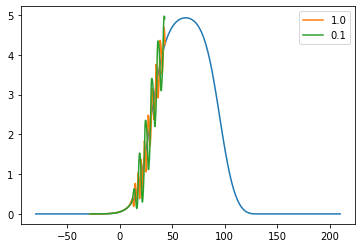

In [50]:
p = roadrunner.plot(n_points=100)

#p.plot(z_history_10[:,0], z_history_10[:,1], label="10.0")
p.plot(z_history_1[:,0], z_history_1[:,1], label="1.0")
p.plot(z_history_01[:,0], z_history_01[:,1], label="0.1")
#p.plot(z_history_10_cg_r05[:,0], z_history_10_cg_r05[:,1], label="10.0 (rear CG)")
#p.plot(z_history_05_cg_r05[:,0], z_history_05_cg_r05[:,1], label="0.5 (rear CG)")
#p.plot(z_history_01_cg_r05[:,0], z_history_01_cg_r05[:,1], label="0.1 (rear CG)")
p.legend()
plt.show()

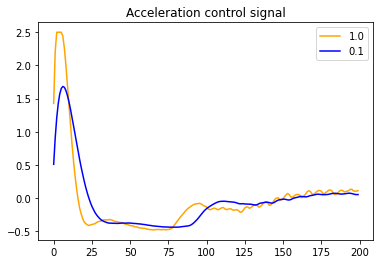

In [51]:
#plt.plot(u_history_10[:,0], label="10.0", color="red")
#plt.plot(u_history_10_cg_r05[:,0], label="10.0", linestyle='--', color="red")
#plt.plot(u_history_5[:,0], label="5.0", color="orange")
#plt.plot(u_history_5_cg_r05[:,0], label="5.0", linestyle='--', color="orange")
plt.plot(u_history_1[:,0], label="1.0", color="orange")
#plt.plot(u_history_1_cg_r05[:,0], label="1.0", linestyle='--', color="yellow")
#plt.plot(u_history_05[:,0], label="0.5", color="green")
#plt.plot(u_history_05_cg_r05[:,0], label="0.5", linestyle='--', color="green")
plt.plot(u_history_01[:,0], label="0.1", linestyle='-', color="blue")
#plt.plot(u_history_01_cg_r05[:,0], label="0.1", linestyle='--', color="blue")
plt.legend()
plt.title("Acceleration control signal")
plt.show()

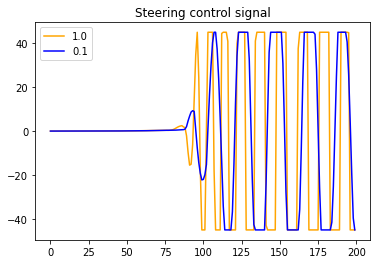

In [52]:
#plt.plot(u_history_10[:,1]*180.0/np.pi, label="10.0", color="red")
#plt.plot(u_history_10_cg_r05[:,0]*180.0/np.pi, label="10.0", linestyle='--', color="red")
#plt.plot(u_history_5[:,1]*180.0/np.pi, label="5.0", color="orange")
#plt.plot(u_history_5_cg_r05[:,0]*180.0/np.pi, label="5.0", linestyle='--', color="orange")
plt.plot(u_history_1[:,1]*180.0/np.pi, label="1.0", color="orange")
#plt.plot(u_history_1_cg_r05[:,1]*180.0/np.pi, label="1.0", linestyle='--', color="yellow")
#plt.plot(u_history_05[:,1]*180.0/np.pi, label="0.5", color="green")
#plt.plot(u_history_05_cg_r05[:,1]*180.0/np.pi, label="0.5", linestyle='--', color="green")
plt.plot(u_history_01[:,1]*180.0/np.pi, label="0.1", linestyle='-', color="blue")
#plt.plot(u_history_01_cg_r05[:,1]*180.0/np.pi, label="0.1", linestyle='--', color="blue")
plt.legend()
plt.title("Steering control signal")
plt.show()

In [ ]:
diff = u_history_10[:np.size(u_history_10_cg_r05)//2,0]-u_history_10_cg_r05[:,0]
plt.plot(diff, label="10.0")
diff0 = u_history_5[:np.size(u_history_5_cg_r05)//2,0]-u_history_5_cg_r05[:,0]
plt.plot(diff0, label="5.0")
diff1 = u_history_1[:np.size(u_history_1_cg_r05)//2,0]-u_history_1_cg_r05[:,0]
plt.plot(diff1, label="1.0")
diff2 = u_history_05[:np.size(u_history_05_cg_r05)//2,0]-u_history_05_cg_r05[:,0]
plt.plot(diff2, label="0.5")
diff3 = u_history_01[:,0]-u_history_01_cg_r05[:np.size(u_history_01)//2,0]
plt.plot(diff3, label="0.1")
plt.legend()
#plt.ylim(-0.005,0.005)
plt.title("Acceleration difference for CG shift 0.5m back")
plt.show()

In [ ]:
diff = u_history_10[:np.size(u_history_10_cg_r05)//2,1]-u_history_10_cg_r05[:,1]
plt.plot(diff, label="10.0")
diff0 = u_history_5[:np.size(u_history_5_cg_r05)//2,1]-u_history_5_cg_r05[:,1]
plt.plot(diff0, label="5.0")
diff1 = u_history_1[:np.size(u_history_1_cg_r05)//2,1]-u_history_1_cg_r05[:,1]
plt.plot(diff1, label="1.0")
diff2 = u_history_05[:np.size(u_history_05_cg_r05)//2,1]-u_history_05_cg_r05[:,1]
plt.plot(diff2, label="0.5")
diff3 = u_history_01[:,1]-u_history_01_cg_r05[:np.size(u_history_01)//2,1]
plt.plot(diff3, label="0.1")
plt.legend()
plt.title("Steering difference for CG shift 0.5m back")
plt.show()